In [1]:
import os
#import sys
#sys.path.append('../../')

import shutil
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import transforms
from torchvision import datasets

from src.features.distort_images import distort_image
from src.utils import ycbcr2rgb
from src.utils import psnr
from src.models.evaluate_models import evaluate_model

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

evaluate_model.DEVICE = device
SR_FACTOR = 3
SIGMA = 1.0

In [3]:
training_img_names = [i for i in os.listdir('./data/raw/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_gt_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_train_Y.shape[0]-32, 13):
            sub_im = im_train_Y[j:j+32, i:i+32]
            training_images_gt_patches.append(sub_im)

training_img_names = [i for i in os.listdir('./data/raw/BSDS500/data/images/test/') if i[-4:] == '.jpg']
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/test/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_train_Y.shape[0]-32, 13):
            sub_im = im_train_Y[j:j+32, i:i+32]
            training_images_gt_patches.append(sub_im)
            


In [4]:
np.max(training_images_gt_patches)

255.0

In [5]:
training_images_gt_patches = np.array(training_images_gt_patches)
print(training_images_gt_patches.shape)

#normalize
training_images_gt_patches /= 255.0

train_pixel_mean = np.mean(training_images_gt_patches)
print(train_pixel_mean)
train_pixel_std = np.std(training_images_gt_patches)
print(train_pixel_std)
#standardize
training_images_gt_patches -= train_pixel_mean
training_images_gt_patches /= train_pixel_std

training_images_gt_patches = torch.tensor(training_images_gt_patches)

(211600, 32, 32)
0.43411854967058106
0.23247274722791464


In [6]:
training_img_names = [i for i in os.listdir('./data/raw/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_training_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='./data/raw/BSDS500/data/images/train/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            training_images_training_patches.append(sub_im)
    print(idx)

training_img_names = [i for i in os.listdir('./data/raw/BSDS500/data/images/test/') if i[-4:] == '.jpg']
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/test/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]

    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='./data/raw/BSDS500/data/images/test/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            training_images_training_patches.append(sub_im)
    print(200+idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

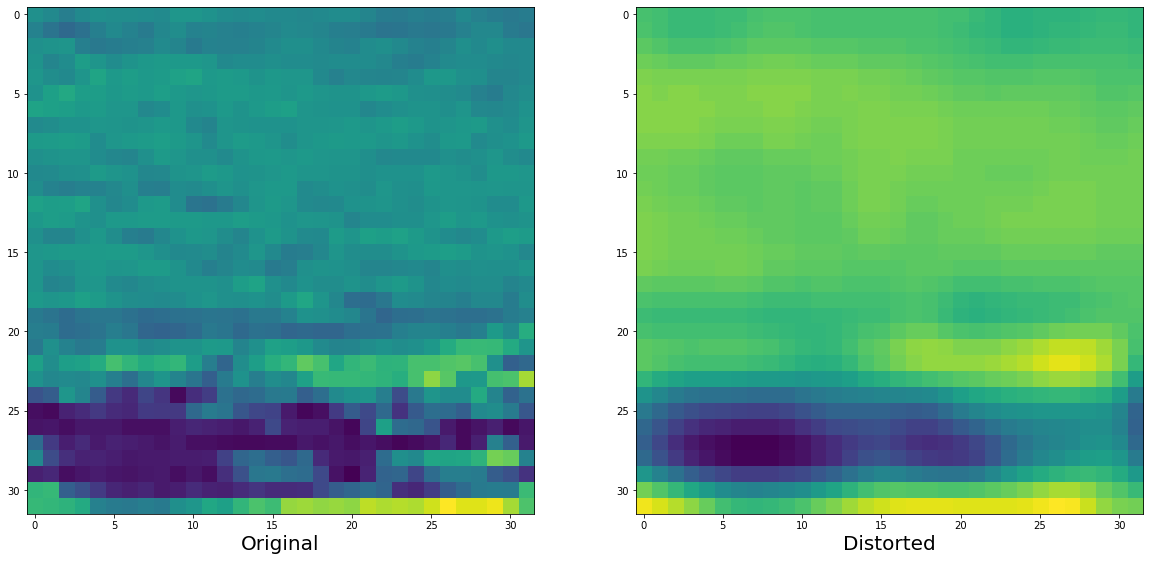

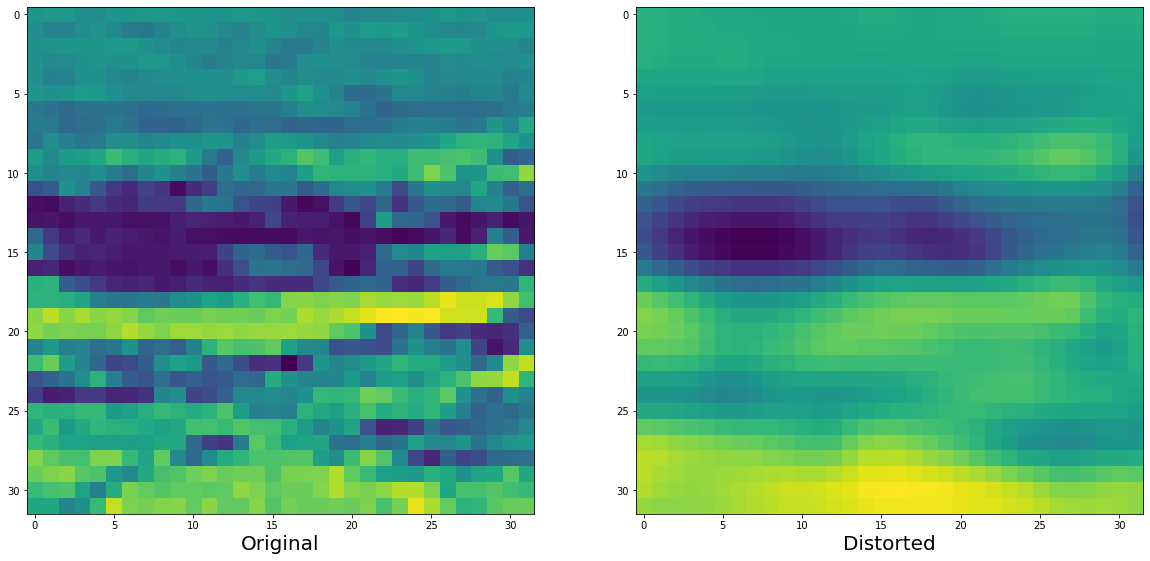

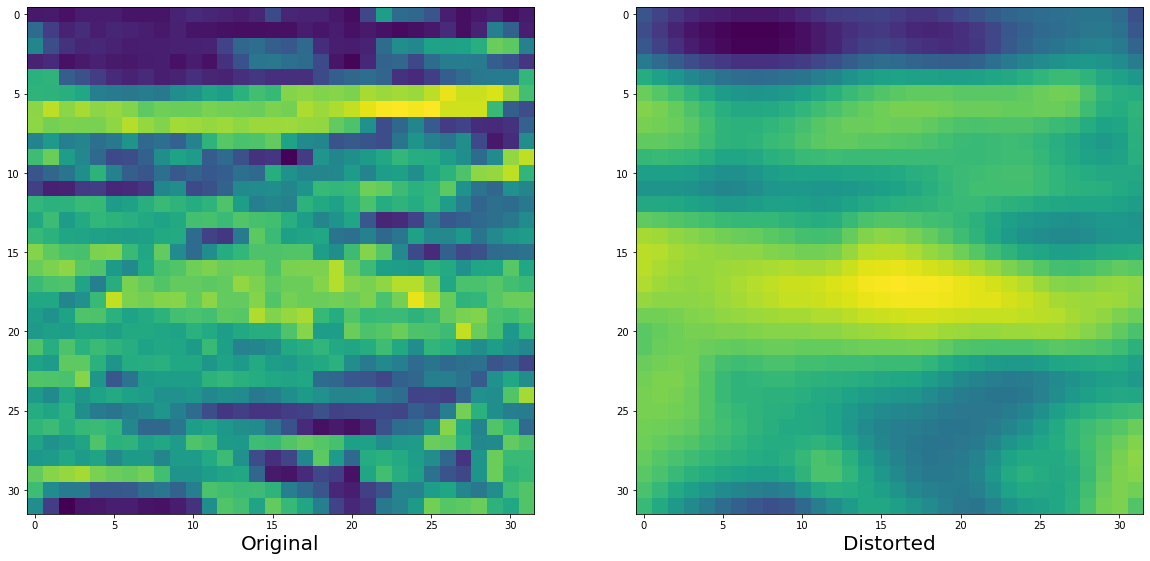

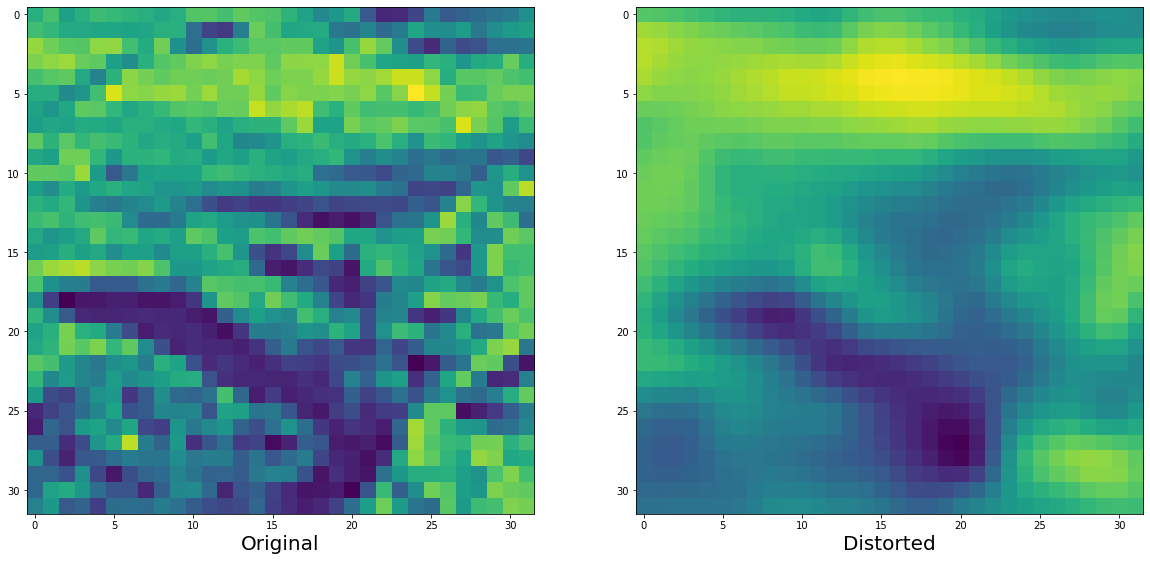

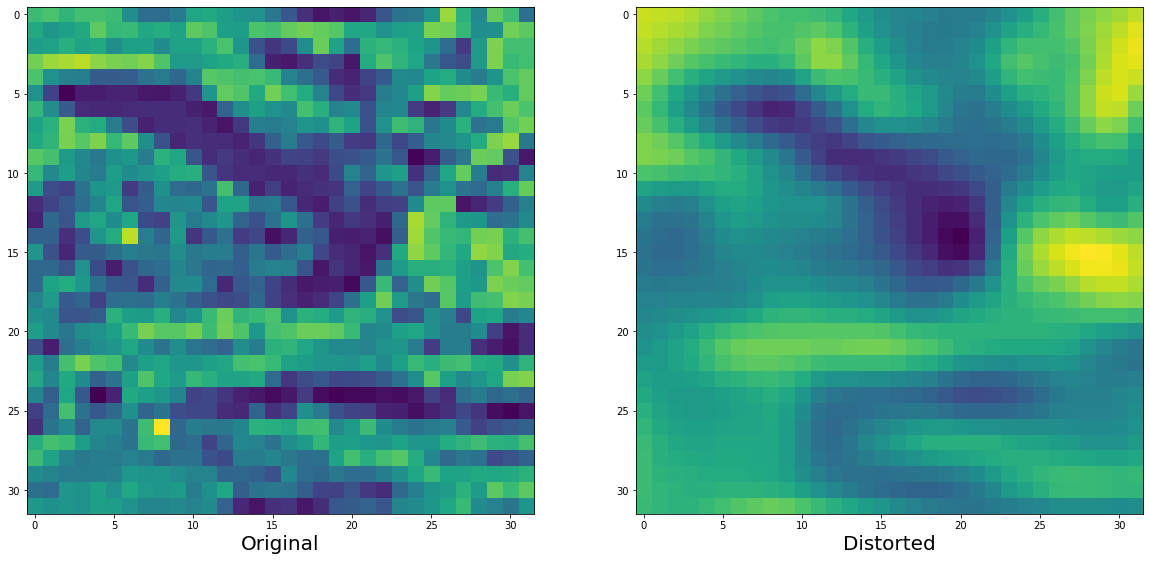

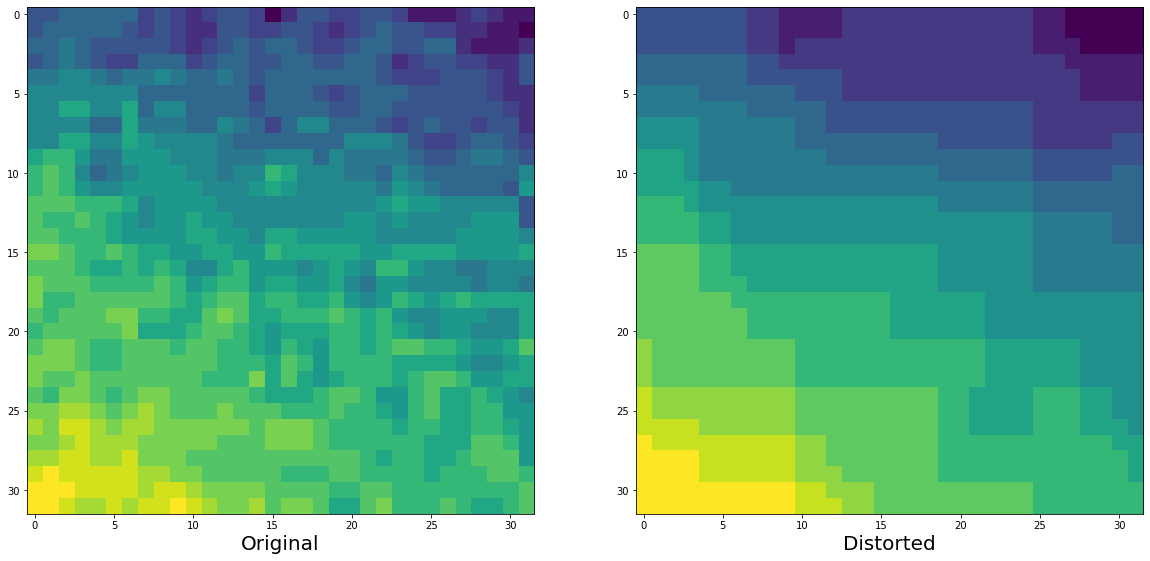

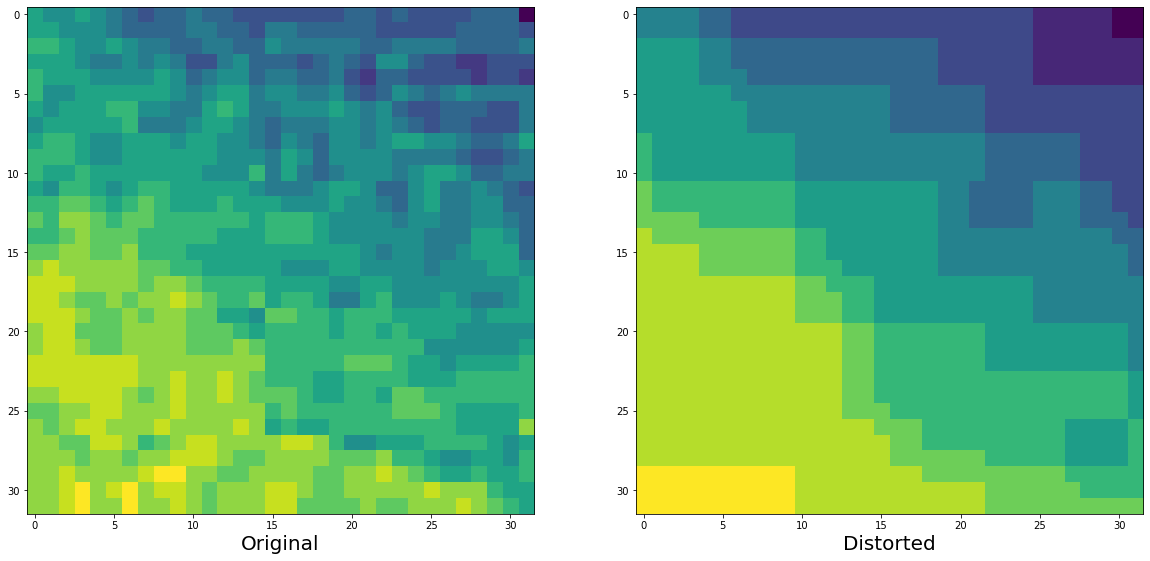

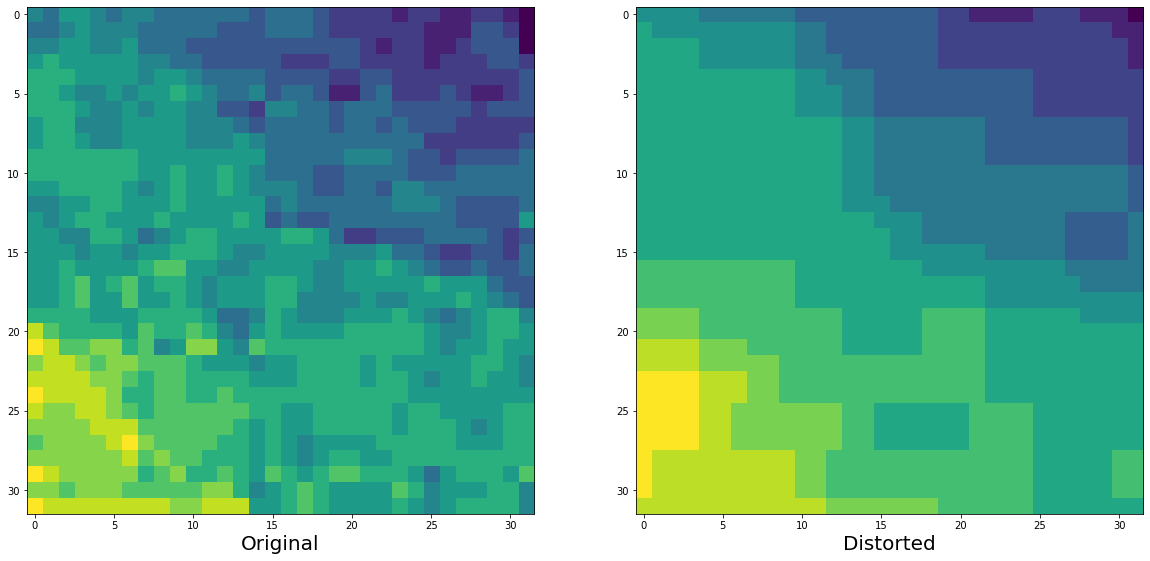

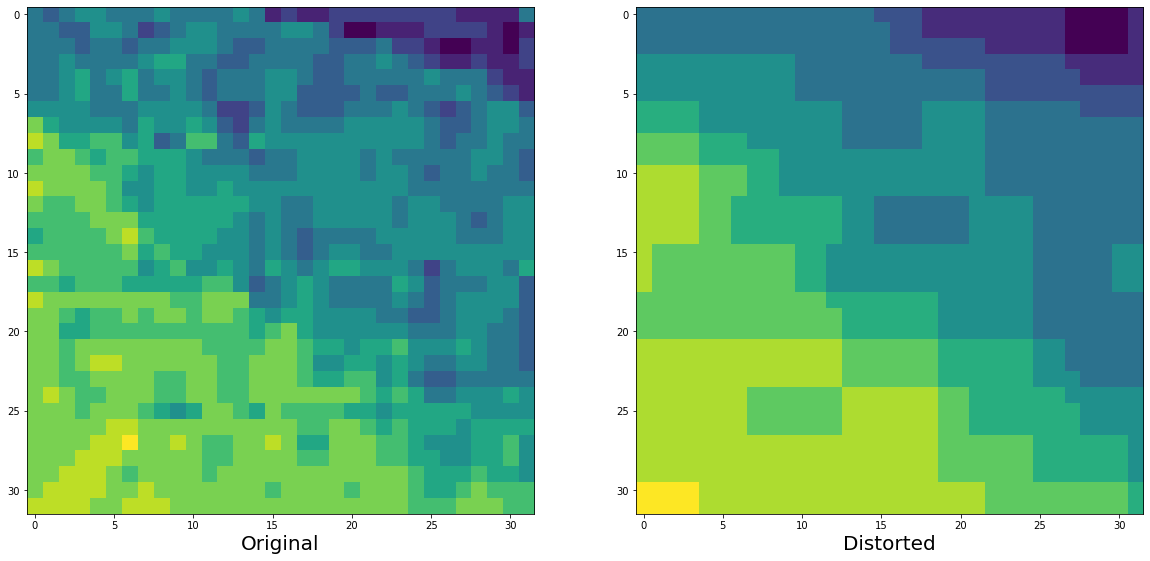

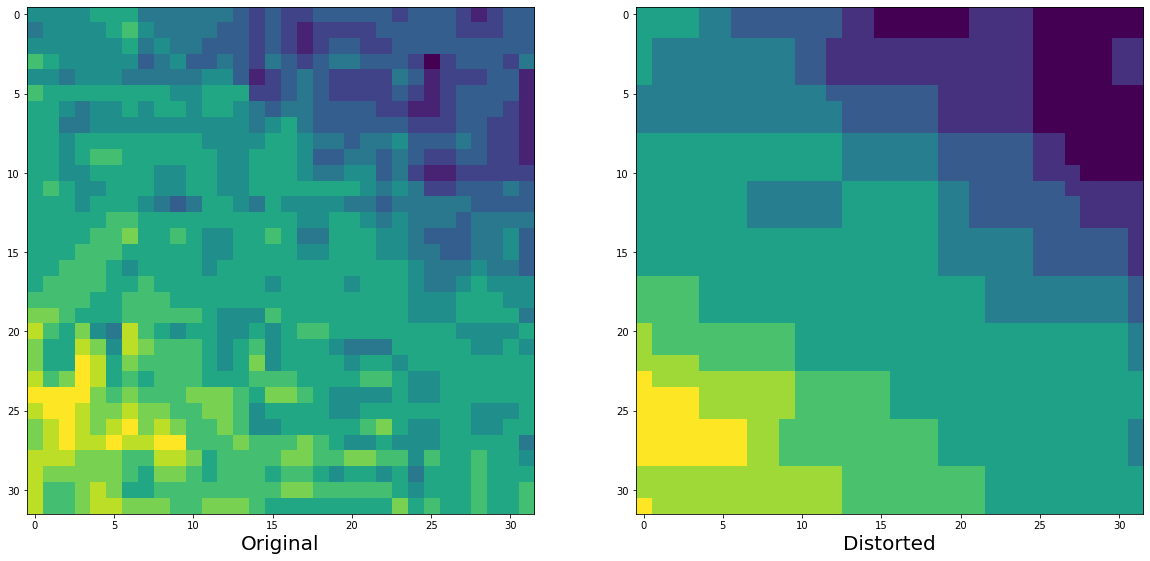

In [7]:
for i in range(10000,10010):
    
    f, axarr = plt.subplots(1,2, figsize=(20, 20))
    axarr[0].imshow(training_images_gt_patches[i])
    axarr[0].set_xlabel('Original', fontsize=20)

    axarr[1].imshow(training_images_training_patches[i])
    axarr[1].set_xlabel('Distorted', fontsize=20)


In [8]:
training_images_training_patches = np.array(training_images_training_patches)
print(training_images_training_patches.shape)

training_images_training_patches /= 255.0
training_images_training_patches -= train_pixel_mean
training_images_training_patches /= train_pixel_std

training_images_training_patches = torch.tensor(training_images_training_patches)
training_images_training_patches.shape


(211600, 32, 32)


torch.Size([211600, 32, 32])

In [9]:
my_training_dataset = data.TensorDataset(training_images_training_patches, training_images_gt_patches)
my_dataloader = data.DataLoader(my_training_dataset,
                                batch_size=128,
                                shuffle=True,
                                drop_last=True)

In [10]:
val_img_names = [img for img in os.listdir('./data/raw/BSDS500/data/images/val/') if img[-4:] == '.jpg']
val_images_gt_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/val/'+img_name)
    im_val = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_val_Y = im_val[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_val_Y.shape[0]/8) * 8
    max_y = int(im_val_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_val_Y = im_val_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_val_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_val_Y.shape[0]-32, 13):
            sub_im = im_val_Y[j:j+32, i:i+32]
            val_images_gt_patches.append(sub_im)
    print(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [11]:
val_images_gt_patches = np.array(val_images_gt_patches)
print(val_images_gt_patches.shape)
#normalize
val_images_gt_patches /= 255.0
#standardize
val_images_gt_patches -= train_pixel_mean
val_images_gt_patches /= train_pixel_std

val_images_gt_patches = torch.tensor(val_images_gt_patches)
val_images_gt_patches.shape


(52900, 32, 32)


torch.Size([52900, 32, 32])

In [12]:
val_images_val_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('./data/raw/BSDS500/data/images/val/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='./data/raw/BSDS500/data/images/val/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)

    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            val_images_val_patches.append(sub_im)
    print(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [13]:
val_images_val_patches = np.array(val_images_val_patches)
print(val_images_val_patches.shape)
#normalize
val_images_val_patches /= 255.0
#standardize
val_images_val_patches -= train_pixel_mean
val_images_val_patches /= train_pixel_std

val_images_val_patches = torch.tensor(val_images_val_patches)
val_images_val_patches.shape


(52900, 32, 32)


torch.Size([52900, 32, 32])

In [14]:
my_val_dataset = data.TensorDataset(val_images_val_patches, val_images_gt_patches)
my_val_dataloader = data.DataLoader(my_val_dataset,
                                    batch_size=128,
                                    shuffle=True,
                                    drop_last=True)


In [15]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=7, padding=3)
        
        torch.nn.init.normal_(self.conv1.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv1.bias)
        
        torch.nn.init.normal_(self.conv2.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv2.bias)
        
        torch.nn.init.normal_(self.conv3.weight, mean=0.0, std=0.001)
        torch.nn.init.zeros_(self.conv3.bias)

    def forward(self, img):
        out = F.relu(self.conv1(img))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out


In [16]:
SR_model = SRCNN()
SR_model = SR_model.to(device)
print(SR_model.named_parameters)

criterion = torch.nn.MSELoss(reduction='mean').to(device)

optimizer = optim.SGD(
                      [
                          {"params": SR_model.conv1.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv2.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv3.parameters(), "lr": 0.00001},
                      ], momentum=0.9)

<bound method Module.named_parameters of SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)>


In [17]:
checkpoint = torch.load('./checkpoint_SRCNN_w_MSE.pt')
SR_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
global_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val loss']

In [20]:
#best_val_loss = 10000.0
#global_epoch = 0
global_epoch

270

In [21]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

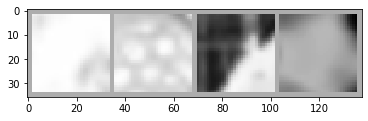

In [22]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/SR_with_MSE_loss')
my_dataloader2 = data.DataLoader(my_training_dataset, batch_size=4, shuffle=True, drop_last=True)


        
# get some random training images
dataiter = iter(my_dataloader2)
images, labels = dataiter.next()


images_2 = torch.zeros((4,3,32,32))


images_2[:,0,:,:] = images
images_2[:,1,:,:] = images
images_2[:,2,:,:] = images


# create grid of images
img_grid = torchvision.utils.make_grid(images_2, nrow=4)
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_training_images', img_grid)

writer.add_graph(SR_model, images.unsqueeze(1).float().to(device))
writer.close()


In [23]:
for epoch in range(9375-global_epoch):  # loop over the dataset multiple times
    print("epoch: ", global_epoch + 1)
    running_loss = 0.0
    for batch_i, data in enumerate(my_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, ground_truth = data
        inputs = inputs.float().to(device)
        ground_truth = ground_truth.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = SR_model(inputs.unsqueeze(1))
        
        

        loss = criterion(outputs.squeeze(), ground_truth.float())
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (global_epoch + 1, batch_i + 1, running_loss / 100))
            writer.add_scalar('training loss', running_loss / 100,
                              global_epoch * len(my_dataloader) + batch_i)
            running_loss = 0.0
    
    #end of epoch metric calculations         
    global_epoch += 1
    with torch.no_grad():

        val_loss = 0
        batch_i = 0
        for batch_i, data in enumerate(my_val_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, ground_truth = data
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = SR_model(inputs.float().unsqueeze(1))

            

            val_loss += criterion(outputs.squeeze(), ground_truth.float())
        
        #get average loss per batch, to match how loss is reported in training
        val_loss = val_loss/(len(my_val_dataloader))
        writer.add_scalar('validation loss', val_loss, global_epoch)
        
        print('epoch %d validation loss: %f'%(global_epoch, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
            print("New lowest loss found. Saving checkpoint.")
            torch.save({'epoch': global_epoch,
                        'model_state_dict': SR_model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val loss': val_loss
                        }, './checkpoint_SRCNN_w_MSE.pt')
        # eval over a unrelated dataset to track psnr
        
        mean_blur_psnr, mean_sr_psnr = evaluate_model(path='./data/raw/test_sets/Set5/', 
                                                      model=SR_model, 
                                                      pixel_mean=train_pixel_mean, 
                                                      pixel_std=train_pixel_std)
        #note: evaluate_model was called when the default arg in the module
        # was 4 for SR_FACTOR. It is set to three now, and in the FDPL run
        writer.add_scalars('Test5 PSNR (dB)', {'bicubic_psnr':mean_blur_psnr,
                                               'srcnn_psnr':mean_sr_psnr}, global_epoch)
        print("test5: bicubic = %f; srcnn = %f"%(mean_blur_psnr, mean_sr_psnr))
            
            
print('Finished Training')



epoch:  271
[271,   100] loss: 0.062
[271,   200] loss: 0.062
[271,   300] loss: 0.062
[271,   400] loss: 0.064
[271,   500] loss: 0.061
[271,   600] loss: 0.061
[271,   700] loss: 0.060
[271,   800] loss: 0.061
[271,   900] loss: 0.063
[271,  1000] loss: 0.061
[271,  1100] loss: 0.061
[271,  1200] loss: 0.062
[271,  1300] loss: 0.062
[271,  1400] loss: 0.061
[271,  1500] loss: 0.062
[271,  1600] loss: 0.061
epoch 271 validation loss: 0.067370
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.285069
epoch:  272
[272,   100] loss: 0.063
[272,   200] loss: 0.061
[272,   300] loss: 0.062
[272,   400] loss: 0.062
[272,   500] loss: 0.061
[272,   600] loss: 0.061
[272,   700] loss: 0.061
[272,   800] loss: 0.061
[272,   900] loss: 0.062
[272,  1000] loss: 0.062
[272,  1100] loss: 0.062
[272,  1200] loss: 0.061
[272,  1300] loss: 0.062
[272,  1400] loss: 0.060
[272,  1500] loss: 0.061
[272,  1600] loss: 0.062
epoch 272 validation loss: 0.067341
New lowest loss 

[286,  1000] loss: 0.061
[286,  1100] loss: 0.061
[286,  1200] loss: 0.061
[286,  1300] loss: 0.062
[286,  1400] loss: 0.062
[286,  1500] loss: 0.061
[286,  1600] loss: 0.061
epoch 286 validation loss: 0.067219
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.293908
epoch:  287
[287,   100] loss: 0.062
[287,   200] loss: 0.062
[287,   300] loss: 0.061
[287,   400] loss: 0.063
[287,   500] loss: 0.062
[287,   600] loss: 0.061
[287,   700] loss: 0.061
[287,   800] loss: 0.061
[287,   900] loss: 0.061
[287,  1000] loss: 0.062
[287,  1100] loss: 0.063
[287,  1200] loss: 0.060
[287,  1300] loss: 0.060
[287,  1400] loss: 0.061
[287,  1500] loss: 0.061
[287,  1600] loss: 0.062
epoch 287 validation loss: 0.067224
test5: bicubic = 28.016224; srcnn = 29.294882
epoch:  288
[288,   100] loss: 0.062
[288,   200] loss: 0.062
[288,   300] loss: 0.062
[288,   400] loss: 0.063
[288,   500] loss: 0.061
[288,   600] loss: 0.061
[288,   700] loss: 0.062
[288,   800] loss: 0

[305,   900] loss: 0.061
[305,  1000] loss: 0.062
[305,  1100] loss: 0.062
[305,  1200] loss: 0.061
[305,  1300] loss: 0.061
[305,  1400] loss: 0.061
[305,  1500] loss: 0.062
[305,  1600] loss: 0.061
epoch 305 validation loss: 0.067054
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.311153
epoch:  306
[306,   100] loss: 0.059
[306,   200] loss: 0.062
[306,   300] loss: 0.061
[306,   400] loss: 0.063
[306,   500] loss: 0.062
[306,   600] loss: 0.061
[306,   700] loss: 0.061
[306,   800] loss: 0.060
[306,   900] loss: 0.061
[306,  1000] loss: 0.061
[306,  1100] loss: 0.060
[306,  1200] loss: 0.061
[306,  1300] loss: 0.063
[306,  1400] loss: 0.062
[306,  1500] loss: 0.061
[306,  1600] loss: 0.062
epoch 306 validation loss: 0.067056
test5: bicubic = 28.016224; srcnn = 29.311593
epoch:  307
[307,   100] loss: 0.061
[307,   200] loss: 0.061
[307,   300] loss: 0.061
[307,   400] loss: 0.061
[307,   500] loss: 0.062
[307,   600] loss: 0.063
[307,   700] loss: 0

[321,   300] loss: 0.061
[321,   400] loss: 0.061
[321,   500] loss: 0.061
[321,   600] loss: 0.063
[321,   700] loss: 0.061
[321,   800] loss: 0.061
[321,   900] loss: 0.061
[321,  1000] loss: 0.062
[321,  1100] loss: 0.060
[321,  1200] loss: 0.062
[321,  1300] loss: 0.062
[321,  1400] loss: 0.060
[321,  1500] loss: 0.060
[321,  1600] loss: 0.061
epoch 321 validation loss: 0.066923
test5: bicubic = 28.016224; srcnn = 29.326800
epoch:  322
[322,   100] loss: 0.060
[322,   200] loss: 0.062
[322,   300] loss: 0.061
[322,   400] loss: 0.061
[322,   500] loss: 0.061
[322,   600] loss: 0.062
[322,   700] loss: 0.060
[322,   800] loss: 0.061
[322,   900] loss: 0.061
[322,  1000] loss: 0.061
[322,  1100] loss: 0.062
[322,  1200] loss: 0.062
[322,  1300] loss: 0.061
[322,  1400] loss: 0.061
[322,  1500] loss: 0.060
[322,  1600] loss: 0.062
epoch 322 validation loss: 0.066919
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.327563
epoch:  323
[323,   100] loss: 0

[337,   100] loss: 0.061
[337,   200] loss: 0.060
[337,   300] loss: 0.061
[337,   400] loss: 0.062
[337,   500] loss: 0.061
[337,   600] loss: 0.062
[337,   700] loss: 0.060
[337,   800] loss: 0.061
[337,   900] loss: 0.062
[337,  1000] loss: 0.061
[337,  1100] loss: 0.060
[337,  1200] loss: 0.061
[337,  1300] loss: 0.062
[337,  1400] loss: 0.060
[337,  1500] loss: 0.061
[337,  1600] loss: 0.062
epoch 337 validation loss: 0.066777
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.346799
epoch:  338
[338,   100] loss: 0.062
[338,   200] loss: 0.062
[338,   300] loss: 0.062
[338,   400] loss: 0.060
[338,   500] loss: 0.061
[338,   600] loss: 0.061
[338,   700] loss: 0.061
[338,   800] loss: 0.060
[338,   900] loss: 0.061
[338,  1000] loss: 0.061
[338,  1100] loss: 0.061
[338,  1200] loss: 0.061
[338,  1300] loss: 0.061
[338,  1400] loss: 0.061
[338,  1500] loss: 0.061
[338,  1600] loss: 0.060
epoch 338 validation loss: 0.066774
New lowest loss found. Savin

[352,  1600] loss: 0.062
epoch 352 validation loss: 0.066640
test5: bicubic = 28.016224; srcnn = 29.367205
epoch:  353
[353,   100] loss: 0.061
[353,   200] loss: 0.061
[353,   300] loss: 0.061
[353,   400] loss: 0.060
[353,   500] loss: 0.060
[353,   600] loss: 0.061
[353,   700] loss: 0.061
[353,   800] loss: 0.060
[353,   900] loss: 0.061
[353,  1000] loss: 0.061
[353,  1100] loss: 0.061
[353,  1200] loss: 0.061
[353,  1300] loss: 0.061
[353,  1400] loss: 0.060
[353,  1500] loss: 0.061
[353,  1600] loss: 0.061
epoch 353 validation loss: 0.066615
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.368991
epoch:  354
[354,   100] loss: 0.061
[354,   200] loss: 0.061
[354,   300] loss: 0.060
[354,   400] loss: 0.060
[354,   500] loss: 0.062
[354,   600] loss: 0.059
[354,   700] loss: 0.061
[354,   800] loss: 0.062
[354,   900] loss: 0.060
[354,  1000] loss: 0.061
[354,  1100] loss: 0.061
[354,  1200] loss: 0.060
[354,  1300] loss: 0.060
[354,  1400] loss: 0

[368,  1100] loss: 0.061
[368,  1200] loss: 0.061
[368,  1300] loss: 0.061
[368,  1400] loss: 0.061
[368,  1500] loss: 0.060
[368,  1600] loss: 0.061
epoch 368 validation loss: 0.066476
test5: bicubic = 28.016224; srcnn = 29.395409
epoch:  369
[369,   100] loss: 0.061
[369,   200] loss: 0.061
[369,   300] loss: 0.060
[369,   400] loss: 0.061
[369,   500] loss: 0.059
[369,   600] loss: 0.061
[369,   700] loss: 0.059
[369,   800] loss: 0.061
[369,   900] loss: 0.061
[369,  1000] loss: 0.060
[369,  1100] loss: 0.061
[369,  1200] loss: 0.061
[369,  1300] loss: 0.061
[369,  1400] loss: 0.061
[369,  1500] loss: 0.061
[369,  1600] loss: 0.061
epoch 369 validation loss: 0.066453
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.396706
epoch:  370
[370,   100] loss: 0.061
[370,   200] loss: 0.061
[370,   300] loss: 0.061
[370,   400] loss: 0.060
[370,   500] loss: 0.061
[370,   600] loss: 0.061
[370,   700] loss: 0.061
[370,   800] loss: 0.060
[370,   900] loss: 0

[384,   500] loss: 0.060
[384,   600] loss: 0.060
[384,   700] loss: 0.062
[384,   800] loss: 0.061
[384,   900] loss: 0.060
[384,  1000] loss: 0.061
[384,  1100] loss: 0.060
[384,  1200] loss: 0.061
[384,  1300] loss: 0.059
[384,  1400] loss: 0.061
[384,  1500] loss: 0.059
[384,  1600] loss: 0.062
epoch 384 validation loss: 0.066281
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.431985
epoch:  385
[385,   100] loss: 0.061
[385,   200] loss: 0.060
[385,   300] loss: 0.060
[385,   400] loss: 0.062
[385,   500] loss: 0.061
[385,   600] loss: 0.061
[385,   700] loss: 0.061
[385,   800] loss: 0.060
[385,   900] loss: 0.060
[385,  1000] loss: 0.060
[385,  1100] loss: 0.061
[385,  1200] loss: 0.060
[385,  1300] loss: 0.061
[385,  1400] loss: 0.060
[385,  1500] loss: 0.061
[385,  1600] loss: 0.059
epoch 385 validation loss: 0.066266
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.433825
epoch:  386
[386,   100] loss: 0.060
[38

epoch 399 validation loss: 0.066125
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.461319
epoch:  400
[400,   100] loss: 0.060
[400,   200] loss: 0.060
[400,   300] loss: 0.061
[400,   400] loss: 0.060
[400,   500] loss: 0.060
[400,   600] loss: 0.059
[400,   700] loss: 0.060
[400,   800] loss: 0.061
[400,   900] loss: 0.060
[400,  1000] loss: 0.060
[400,  1100] loss: 0.061
[400,  1200] loss: 0.060
[400,  1300] loss: 0.061
[400,  1400] loss: 0.060
[400,  1500] loss: 0.060
[400,  1600] loss: 0.061
epoch 400 validation loss: 0.066114
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.463668
epoch:  401
[401,   100] loss: 0.060
[401,   200] loss: 0.062
[401,   300] loss: 0.061
[401,   400] loss: 0.060
[401,   500] loss: 0.060
[401,   600] loss: 0.062
[401,   700] loss: 0.061
[401,   800] loss: 0.060
[401,   900] loss: 0.060
[401,  1000] loss: 0.060
[401,  1100] loss: 0.060
[401,  1200] loss: 0.059
[401,  1300] loss: 0.060
[40

[415,   700] loss: 0.060
[415,   800] loss: 0.060
[415,   900] loss: 0.061
[415,  1000] loss: 0.061
[415,  1100] loss: 0.061
[415,  1200] loss: 0.060
[415,  1300] loss: 0.060
[415,  1400] loss: 0.060
[415,  1500] loss: 0.060
[415,  1600] loss: 0.058
epoch 415 validation loss: 0.065953
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.490918
epoch:  416
[416,   100] loss: 0.060
[416,   200] loss: 0.061
[416,   300] loss: 0.060
[416,   400] loss: 0.059
[416,   500] loss: 0.061
[416,   600] loss: 0.061
[416,   700] loss: 0.060
[416,   800] loss: 0.060
[416,   900] loss: 0.061
[416,  1000] loss: 0.058
[416,  1100] loss: 0.060
[416,  1200] loss: 0.061
[416,  1300] loss: 0.061
[416,  1400] loss: 0.060
[416,  1500] loss: 0.062
[416,  1600] loss: 0.060
epoch 416 validation loss: 0.065939
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.492744
epoch:  417
[417,   100] loss: 0.061
[417,   200] loss: 0.061
[417,   300] loss: 0.060
[41

[431,   400] loss: 0.060
[431,   500] loss: 0.062
[431,   600] loss: 0.060
[431,   700] loss: 0.060
[431,   800] loss: 0.060
[431,   900] loss: 0.058
[431,  1000] loss: 0.060
[431,  1100] loss: 0.059
[431,  1200] loss: 0.060
[431,  1300] loss: 0.061
[431,  1400] loss: 0.059
[431,  1500] loss: 0.061
[431,  1600] loss: 0.060
epoch 431 validation loss: 0.065790
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.510979
epoch:  432
[432,   100] loss: 0.059
[432,   200] loss: 0.059
[432,   300] loss: 0.059
[432,   400] loss: 0.060
[432,   500] loss: 0.060
[432,   600] loss: 0.061
[432,   700] loss: 0.061
[432,   800] loss: 0.059
[432,   900] loss: 0.060
[432,  1000] loss: 0.061
[432,  1100] loss: 0.060
[432,  1200] loss: 0.060
[432,  1300] loss: 0.060
[432,  1400] loss: 0.060
[432,  1500] loss: 0.062
[432,  1600] loss: 0.061
epoch 432 validation loss: 0.065791
test5: bicubic = 28.016224; srcnn = 29.511945
epoch:  433
[433,   100] loss: 0.060
[433,   200] loss: 0

[447,   100] loss: 0.061
[447,   200] loss: 0.060
[447,   300] loss: 0.061
[447,   400] loss: 0.060
[447,   500] loss: 0.060
[447,   600] loss: 0.060
[447,   700] loss: 0.059
[447,   800] loss: 0.060
[447,   900] loss: 0.060
[447,  1000] loss: 0.059
[447,  1100] loss: 0.059
[447,  1200] loss: 0.060
[447,  1300] loss: 0.061
[447,  1400] loss: 0.059
[447,  1500] loss: 0.060
[447,  1600] loss: 0.060
epoch 447 validation loss: 0.065666
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.523919
epoch:  448
[448,   100] loss: 0.060
[448,   200] loss: 0.060
[448,   300] loss: 0.060
[448,   400] loss: 0.060
[448,   500] loss: 0.059
[448,   600] loss: 0.060
[448,   700] loss: 0.060
[448,   800] loss: 0.060
[448,   900] loss: 0.060
[448,  1000] loss: 0.061
[448,  1100] loss: 0.061
[448,  1200] loss: 0.060
[448,  1300] loss: 0.059
[448,  1400] loss: 0.060
[448,  1500] loss: 0.060
[448,  1600] loss: 0.059
epoch 448 validation loss: 0.065651
New lowest loss found. Savin

[462,  1400] loss: 0.059
[462,  1500] loss: 0.060
[462,  1600] loss: 0.060
epoch 462 validation loss: 0.065593
test5: bicubic = 28.016224; srcnn = 29.536957
epoch:  463
[463,   100] loss: 0.059
[463,   200] loss: 0.059
[463,   300] loss: 0.061
[463,   400] loss: 0.060
[463,   500] loss: 0.060
[463,   600] loss: 0.060
[463,   700] loss: 0.059
[463,   800] loss: 0.061
[463,   900] loss: 0.060
[463,  1000] loss: 0.060
[463,  1100] loss: 0.060
[463,  1200] loss: 0.060
[463,  1300] loss: 0.058
[463,  1400] loss: 0.061
[463,  1500] loss: 0.059
[463,  1600] loss: 0.059
epoch 463 validation loss: 0.065551
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.537575
epoch:  464
[464,   100] loss: 0.059
[464,   200] loss: 0.062
[464,   300] loss: 0.058
[464,   400] loss: 0.061
[464,   500] loss: 0.060
[464,   600] loss: 0.061
[464,   700] loss: 0.060
[464,   800] loss: 0.059
[464,   900] loss: 0.061
[464,  1000] loss: 0.059
[464,  1100] loss: 0.060
[464,  1200] loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[956,   800] loss: 0.059
[956,   900] loss: 0.057
[956,  1000] loss: 0.058
[956,  1100] loss: 0.057
[956,  1200] loss: 0.056
[956,  1300] loss: 0.057
[956,  1400] loss: 0.059
[956,  1500] loss: 0.059
[956,  1600] loss: 0.058
epoch 956 validation loss: 0.063487
test5: bicubic = 28.016224; srcnn = 29.828408
epoch:  957
[957,   100] loss: 0.058
[957,   200] loss: 0.058
[957,   300] loss: 0.058
[957,   400] loss: 0.058
[957,   500] loss: 0.058
[957,   600] loss: 0.058
[957,   700] loss: 0.058
[957,   800] loss: 0.057
[957,   900] loss: 0.058
[957,  1000] loss: 0.059
[957,  1100] loss: 0.058
[957,  1200] loss: 0.057
[957,  1300] loss: 0.057
[957,  1400] loss: 0.057
[957,  1500] loss: 0.057
[957,  1600] loss: 0.058
epoch 957 validation loss: 0.063484
test5: bicubic = 28.016224; srcnn = 29.828552
epoch:  958
[958,   100] loss: 0.057
[958,   200] loss: 0.058
[958,   300] loss: 0.057
[958,   400] loss: 0.057
[958,   500] loss: 0.059
[958,   600] loss: 0.058
[958,   700] loss: 0.057
[958,   800]

[972,  1200] loss: 0.057
[972,  1300] loss: 0.059
[972,  1400] loss: 0.059
[972,  1500] loss: 0.057
[972,  1600] loss: 0.058
epoch 972 validation loss: 0.063439
test5: bicubic = 28.016224; srcnn = 29.836566
epoch:  973
[973,   100] loss: 0.058
[973,   200] loss: 0.058
[973,   300] loss: 0.058
[973,   400] loss: 0.058
[973,   500] loss: 0.059
[973,   600] loss: 0.056
[973,   700] loss: 0.058
[973,   800] loss: 0.057
[973,   900] loss: 0.057
[973,  1000] loss: 0.057
[973,  1100] loss: 0.058
[973,  1200] loss: 0.058
[973,  1300] loss: 0.058
[973,  1400] loss: 0.056
[973,  1500] loss: 0.058
[973,  1600] loss: 0.058
epoch 973 validation loss: 0.063442
test5: bicubic = 28.016224; srcnn = 29.836775
epoch:  974
[974,   100] loss: 0.059
[974,   200] loss: 0.058
[974,   300] loss: 0.058
[974,   400] loss: 0.058
[974,   500] loss: 0.057
[974,   600] loss: 0.059
[974,   700] loss: 0.058
[974,   800] loss: 0.057
[974,   900] loss: 0.057
[974,  1000] loss: 0.057
[974,  1100] loss: 0.058
[974,  1200]

[988,  1400] loss: 0.057
[988,  1500] loss: 0.059
[988,  1600] loss: 0.058
epoch 988 validation loss: 0.063382
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.843225
epoch:  989
[989,   100] loss: 0.057
[989,   200] loss: 0.058
[989,   300] loss: 0.057
[989,   400] loss: 0.058
[989,   500] loss: 0.057
[989,   600] loss: 0.058
[989,   700] loss: 0.058
[989,   800] loss: 0.058
[989,   900] loss: 0.058
[989,  1000] loss: 0.057
[989,  1100] loss: 0.059
[989,  1200] loss: 0.056
[989,  1300] loss: 0.059
[989,  1400] loss: 0.058
[989,  1500] loss: 0.057
[989,  1600] loss: 0.057
epoch 989 validation loss: 0.063377
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.844583
epoch:  990
[990,   100] loss: 0.058
[990,   200] loss: 0.058
[990,   300] loss: 0.057
[990,   400] loss: 0.057
[990,   500] loss: 0.059
[990,   600] loss: 0.057
[990,   700] loss: 0.058
[990,   800] loss: 0.058
[990,   900] loss: 0.059
[990,  1000] loss: 0.057
[99

[1004,  1300] loss: 0.058
[1004,  1400] loss: 0.058
[1004,  1500] loss: 0.058
[1004,  1600] loss: 0.057
epoch 1004 validation loss: 0.063349
test5: bicubic = 28.016224; srcnn = 29.851554
epoch:  1005
[1005,   100] loss: 0.058
[1005,   200] loss: 0.059
[1005,   300] loss: 0.059
[1005,   400] loss: 0.058
[1005,   500] loss: 0.058
[1005,   600] loss: 0.056
[1005,   700] loss: 0.056
[1005,   800] loss: 0.057
[1005,   900] loss: 0.058
[1005,  1000] loss: 0.058
[1005,  1100] loss: 0.057
[1005,  1200] loss: 0.057
[1005,  1300] loss: 0.058
[1005,  1400] loss: 0.058
[1005,  1500] loss: 0.057
[1005,  1600] loss: 0.058
epoch 1005 validation loss: 0.063351
test5: bicubic = 28.016224; srcnn = 29.851738
epoch:  1006
[1006,   100] loss: 0.058
[1006,   200] loss: 0.057
[1006,   300] loss: 0.058
[1006,   400] loss: 0.057
[1006,   500] loss: 0.058
[1006,   600] loss: 0.058
[1006,   700] loss: 0.058
[1006,   800] loss: 0.058
[1006,   900] loss: 0.058
[1006,  1000] loss: 0.058
[1006,  1100] loss: 0.057
[1

[1020,   900] loss: 0.057
[1020,  1000] loss: 0.058
[1020,  1100] loss: 0.057
[1020,  1200] loss: 0.058
[1020,  1300] loss: 0.058
[1020,  1400] loss: 0.058
[1020,  1500] loss: 0.057
[1020,  1600] loss: 0.058
epoch 1020 validation loss: 0.063318
test5: bicubic = 28.016224; srcnn = 29.858566
epoch:  1021
[1021,   100] loss: 0.058
[1021,   200] loss: 0.057
[1021,   300] loss: 0.057
[1021,   400] loss: 0.057
[1021,   500] loss: 0.057
[1021,   600] loss: 0.058
[1021,   700] loss: 0.058
[1021,   800] loss: 0.058
[1021,   900] loss: 0.057
[1021,  1000] loss: 0.058
[1021,  1100] loss: 0.058
[1021,  1200] loss: 0.057
[1021,  1300] loss: 0.058
[1021,  1400] loss: 0.058
[1021,  1500] loss: 0.057
[1021,  1600] loss: 0.058
epoch 1021 validation loss: 0.063311
test5: bicubic = 28.016224; srcnn = 29.858331
epoch:  1022
[1022,   100] loss: 0.059
[1022,   200] loss: 0.057
[1022,   300] loss: 0.057
[1022,   400] loss: 0.057
[1022,   500] loss: 0.058
[1022,   600] loss: 0.057
[1022,   700] loss: 0.059
[1

[1036,   800] loss: 0.057
[1036,   900] loss: 0.056
[1036,  1000] loss: 0.058
[1036,  1100] loss: 0.059
[1036,  1200] loss: 0.057
[1036,  1300] loss: 0.057
[1036,  1400] loss: 0.058
[1036,  1500] loss: 0.060
[1036,  1600] loss: 0.058
epoch 1036 validation loss: 0.063272
test5: bicubic = 28.016224; srcnn = 29.864594
epoch:  1037
[1037,   100] loss: 0.058
[1037,   200] loss: 0.058
[1037,   300] loss: 0.058
[1037,   400] loss: 0.057
[1037,   500] loss: 0.057
[1037,   600] loss: 0.058
[1037,   700] loss: 0.058
[1037,   800] loss: 0.058
[1037,   900] loss: 0.058
[1037,  1000] loss: 0.059
[1037,  1100] loss: 0.058
[1037,  1200] loss: 0.057
[1037,  1300] loss: 0.056
[1037,  1400] loss: 0.057
[1037,  1500] loss: 0.057
[1037,  1600] loss: 0.058
epoch 1037 validation loss: 0.063270
test5: bicubic = 28.016224; srcnn = 29.864958
epoch:  1038
[1038,   100] loss: 0.059
[1038,   200] loss: 0.057
[1038,   300] loss: 0.059
[1038,   400] loss: 0.057
[1038,   500] loss: 0.057
[1038,   600] loss: 0.057
[1

epoch 1051 validation loss: 0.063218
test5: bicubic = 28.016224; srcnn = 29.871025
epoch:  1052
[1052,   100] loss: 0.057
[1052,   200] loss: 0.057
[1052,   300] loss: 0.057
[1052,   400] loss: 0.057
[1052,   500] loss: 0.058
[1052,   600] loss: 0.057
[1052,   700] loss: 0.058
[1052,   800] loss: 0.057
[1052,   900] loss: 0.058
[1052,  1000] loss: 0.057
[1052,  1100] loss: 0.058
[1052,  1200] loss: 0.057
[1052,  1300] loss: 0.056
[1052,  1400] loss: 0.059
[1052,  1500] loss: 0.057
[1052,  1600] loss: 0.057
epoch 1052 validation loss: 0.063222
test5: bicubic = 28.016224; srcnn = 29.870958
epoch:  1053
[1053,   100] loss: 0.057
[1053,   200] loss: 0.058
[1053,   300] loss: 0.057
[1053,   400] loss: 0.057
[1053,   500] loss: 0.057
[1053,   600] loss: 0.058
[1053,   700] loss: 0.058
[1053,   800] loss: 0.058
[1053,   900] loss: 0.057
[1053,  1000] loss: 0.058
[1053,  1100] loss: 0.058
[1053,  1200] loss: 0.058
[1053,  1300] loss: 0.057
[1053,  1400] loss: 0.057
[1053,  1500] loss: 0.057
[1

[1067,   900] loss: 0.057
[1067,  1000] loss: 0.058
[1067,  1100] loss: 0.058
[1067,  1200] loss: 0.056
[1067,  1300] loss: 0.057
[1067,  1400] loss: 0.059
[1067,  1500] loss: 0.058
[1067,  1600] loss: 0.058
epoch 1067 validation loss: 0.063180
test5: bicubic = 28.016224; srcnn = 29.876903
epoch:  1068
[1068,   100] loss: 0.057
[1068,   200] loss: 0.058
[1068,   300] loss: 0.058
[1068,   400] loss: 0.057
[1068,   500] loss: 0.058
[1068,   600] loss: 0.058
[1068,   700] loss: 0.057
[1068,   800] loss: 0.058
[1068,   900] loss: 0.057
[1068,  1000] loss: 0.057
[1068,  1100] loss: 0.057
[1068,  1200] loss: 0.059
[1068,  1300] loss: 0.058
[1068,  1400] loss: 0.057
[1068,  1500] loss: 0.057
[1068,  1600] loss: 0.058
epoch 1068 validation loss: 0.063177
test5: bicubic = 28.016224; srcnn = 29.876553
epoch:  1069
[1069,   100] loss: 0.057
[1069,   200] loss: 0.058
[1069,   300] loss: 0.057
[1069,   400] loss: 0.058
[1069,   500] loss: 0.057
[1069,   600] loss: 0.058
[1069,   700] loss: 0.058
[1

[1083,   600] loss: 0.057
[1083,   700] loss: 0.057
[1083,   800] loss: 0.057
[1083,   900] loss: 0.057
[1083,  1000] loss: 0.056
[1083,  1100] loss: 0.056
[1083,  1200] loss: 0.058
[1083,  1300] loss: 0.058
[1083,  1400] loss: 0.059
[1083,  1500] loss: 0.058
[1083,  1600] loss: 0.057
epoch 1083 validation loss: 0.063139
test5: bicubic = 28.016224; srcnn = 29.882656
epoch:  1084
[1084,   100] loss: 0.057
[1084,   200] loss: 0.058
[1084,   300] loss: 0.058
[1084,   400] loss: 0.058
[1084,   500] loss: 0.057
[1084,   600] loss: 0.058
[1084,   700] loss: 0.057
[1084,   800] loss: 0.057
[1084,   900] loss: 0.058
[1084,  1000] loss: 0.058
[1084,  1100] loss: 0.057
[1084,  1200] loss: 0.059
[1084,  1300] loss: 0.057
[1084,  1400] loss: 0.058
[1084,  1500] loss: 0.057
[1084,  1600] loss: 0.057
epoch 1084 validation loss: 0.063146
test5: bicubic = 28.016224; srcnn = 29.883601
epoch:  1085
[1085,   100] loss: 0.058
[1085,   200] loss: 0.059
[1085,   300] loss: 0.057
[1085,   400] loss: 0.058
[1

[1099,   100] loss: 0.057
[1099,   200] loss: 0.058
[1099,   300] loss: 0.057
[1099,   400] loss: 0.057
[1099,   500] loss: 0.056
[1099,   600] loss: 0.058
[1099,   700] loss: 0.057
[1099,   800] loss: 0.057
[1099,   900] loss: 0.057
[1099,  1000] loss: 0.057
[1099,  1100] loss: 0.057
[1099,  1200] loss: 0.058
[1099,  1300] loss: 0.058
[1099,  1400] loss: 0.057
[1099,  1500] loss: 0.058
[1099,  1600] loss: 0.057
epoch 1099 validation loss: 0.063104
test5: bicubic = 28.016224; srcnn = 29.888952
epoch:  1100
[1100,   100] loss: 0.058
[1100,   200] loss: 0.059
[1100,   300] loss: 0.057
[1100,   400] loss: 0.056
[1100,   500] loss: 0.058
[1100,   600] loss: 0.057
[1100,   700] loss: 0.058
[1100,   800] loss: 0.057
[1100,   900] loss: 0.057
[1100,  1000] loss: 0.058
[1100,  1100] loss: 0.058
[1100,  1200] loss: 0.058
[1100,  1300] loss: 0.056
[1100,  1400] loss: 0.057
[1100,  1500] loss: 0.058
[1100,  1600] loss: 0.057
epoch 1100 validation loss: 0.063104
test5: bicubic = 28.016224; srcnn =

[1114,  1200] loss: 0.059
[1114,  1300] loss: 0.057
[1114,  1400] loss: 0.057
[1114,  1500] loss: 0.058
[1114,  1600] loss: 0.057
epoch 1114 validation loss: 0.063063
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 29.894253
epoch:  1115
[1115,   100] loss: 0.057
[1115,   200] loss: 0.057
[1115,   300] loss: 0.057
[1115,   400] loss: 0.058
[1115,   500] loss: 0.057
[1115,   600] loss: 0.057
[1115,   700] loss: 0.057
[1115,   800] loss: 0.056
[1115,   900] loss: 0.057
[1115,  1000] loss: 0.059
[1115,  1100] loss: 0.058
[1115,  1200] loss: 0.059
[1115,  1300] loss: 0.057
[1115,  1400] loss: 0.058
[1115,  1500] loss: 0.056
[1115,  1600] loss: 0.057
epoch 1115 validation loss: 0.063086
test5: bicubic = 28.016224; srcnn = 29.894755
epoch:  1116
[1116,   100] loss: 0.057
[1116,   200] loss: 0.058
[1116,   300] loss: 0.058
[1116,   400] loss: 0.058
[1116,   500] loss: 0.056
[1116,   600] loss: 0.057
[1116,   700] loss: 0.058
[1116,   800] loss: 0.057
[1116,   900

[1130,   600] loss: 0.058
[1130,   700] loss: 0.057
[1130,   800] loss: 0.057
[1130,   900] loss: 0.056
[1130,  1000] loss: 0.059
[1130,  1100] loss: 0.057
[1130,  1200] loss: 0.058
[1130,  1300] loss: 0.058
[1130,  1400] loss: 0.057
[1130,  1500] loss: 0.057
[1130,  1600] loss: 0.057
epoch 1130 validation loss: 0.063036
test5: bicubic = 28.016224; srcnn = 29.899575
epoch:  1131
[1131,   100] loss: 0.057
[1131,   200] loss: 0.058
[1131,   300] loss: 0.058
[1131,   400] loss: 0.057
[1131,   500] loss: 0.056
[1131,   600] loss: 0.057
[1131,   700] loss: 0.057
[1131,   800] loss: 0.057
[1131,   900] loss: 0.057
[1131,  1000] loss: 0.058
[1131,  1100] loss: 0.058
[1131,  1200] loss: 0.057
[1131,  1300] loss: 0.057
[1131,  1400] loss: 0.057
[1131,  1500] loss: 0.058
[1131,  1600] loss: 0.056
epoch 1131 validation loss: 0.063033
test5: bicubic = 28.016224; srcnn = 29.900159
epoch:  1132
[1132,   100] loss: 0.058
[1132,   200] loss: 0.057
[1132,   300] loss: 0.057
[1132,   400] loss: 0.057
[1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[1624,  1000] loss: 0.056
[1624,  1100] loss: 0.056
[1624,  1200] loss: 0.056
[1624,  1300] loss: 0.056
[1624,  1400] loss: 0.057
[1624,  1500] loss: 0.056
[1624,  1600] loss: 0.055
epoch 1624 validation loss: 0.062132
test5: bicubic = 28.016224; srcnn = 30.063669
epoch:  1625
[1625,   100] loss: 0.055
[1625,   200] loss: 0.056
[1625,   300] loss: 0.057
[1625,   400] loss: 0.058
[1625,   500] loss: 0.057
[1625,   600] loss: 0.055
[1625,   700] loss: 0.056
[1625,   800] loss: 0.057
[1625,   900] loss: 0.057
[1625,  1000] loss: 0.056
[1625,  1100] loss: 0.056
[1625,  1200] loss: 0.057
[1625,  1300] loss: 0.057
[1625,  1400] loss: 0.057
[1625,  1500] loss: 0.056
[1625,  1600] loss: 0.056
epoch 1625 validation loss: 0.062128
test5: bicubic = 28.016224; srcnn = 30.063394
epoch:  1626
[1626,   100] loss: 0.057
[1626,   200] loss: 0.055
[1626,   300] loss: 0.056
[1626,   400] loss: 0.056
[1626,   500] loss: 0.057
[1626,   600] loss: 0.057
[1626,   700] loss: 0.057
[1626,   800] loss: 0.055
[1

[1640,   700] loss: 0.056
[1640,   800] loss: 0.056
[1640,   900] loss: 0.056
[1640,  1000] loss: 0.056
[1640,  1100] loss: 0.055
[1640,  1200] loss: 0.057
[1640,  1300] loss: 0.056
[1640,  1400] loss: 0.057
[1640,  1500] loss: 0.056
[1640,  1600] loss: 0.057
epoch 1640 validation loss: 0.062110
test5: bicubic = 28.016224; srcnn = 30.067882
epoch:  1641
[1641,   100] loss: 0.057
[1641,   200] loss: 0.057
[1641,   300] loss: 0.056
[1641,   400] loss: 0.057
[1641,   500] loss: 0.056
[1641,   600] loss: 0.056
[1641,   700] loss: 0.055
[1641,   800] loss: 0.057
[1641,   900] loss: 0.056
[1641,  1000] loss: 0.057
[1641,  1100] loss: 0.054
[1641,  1200] loss: 0.058
[1641,  1300] loss: 0.057
[1641,  1400] loss: 0.057
[1641,  1500] loss: 0.056
[1641,  1600] loss: 0.056
epoch 1641 validation loss: 0.062096
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.067951
epoch:  1642
[1642,   100] loss: 0.057
[1642,   200] loss: 0.056
[1642,   300] loss: 0.057
[1642,   400

[1656,   100] loss: 0.057
[1656,   200] loss: 0.056
[1656,   300] loss: 0.056
[1656,   400] loss: 0.055
[1656,   500] loss: 0.056
[1656,   600] loss: 0.056
[1656,   700] loss: 0.057
[1656,   800] loss: 0.057
[1656,   900] loss: 0.057
[1656,  1000] loss: 0.056
[1656,  1100] loss: 0.056
[1656,  1200] loss: 0.057
[1656,  1300] loss: 0.057
[1656,  1400] loss: 0.056
[1656,  1500] loss: 0.055
[1656,  1600] loss: 0.056
epoch 1656 validation loss: 0.062098
test5: bicubic = 28.016224; srcnn = 30.071252
epoch:  1657
[1657,   100] loss: 0.056
[1657,   200] loss: 0.056
[1657,   300] loss: 0.057
[1657,   400] loss: 0.056
[1657,   500] loss: 0.056
[1657,   600] loss: 0.057
[1657,   700] loss: 0.057
[1657,   800] loss: 0.057
[1657,   900] loss: 0.056
[1657,  1000] loss: 0.055
[1657,  1100] loss: 0.056
[1657,  1200] loss: 0.057
[1657,  1300] loss: 0.056
[1657,  1400] loss: 0.056
[1657,  1500] loss: 0.056
[1657,  1600] loss: 0.056
epoch 1657 validation loss: 0.062070
New lowest loss found. Saving check

[1671,  1500] loss: 0.057
[1671,  1600] loss: 0.056
epoch 1671 validation loss: 0.062086
test5: bicubic = 28.016224; srcnn = 30.074261
epoch:  1672
[1672,   100] loss: 0.057
[1672,   200] loss: 0.056
[1672,   300] loss: 0.055
[1672,   400] loss: 0.056
[1672,   500] loss: 0.056
[1672,   600] loss: 0.055
[1672,   700] loss: 0.056
[1672,   800] loss: 0.056
[1672,   900] loss: 0.057
[1672,  1000] loss: 0.056
[1672,  1100] loss: 0.057
[1672,  1200] loss: 0.057
[1672,  1300] loss: 0.056
[1672,  1400] loss: 0.057
[1672,  1500] loss: 0.056
[1672,  1600] loss: 0.057
epoch 1672 validation loss: 0.062074
test5: bicubic = 28.016224; srcnn = 30.075062
epoch:  1673
[1673,   100] loss: 0.056
[1673,   200] loss: 0.056
[1673,   300] loss: 0.056
[1673,   400] loss: 0.056
[1673,   500] loss: 0.056
[1673,   600] loss: 0.055
[1673,   700] loss: 0.055
[1673,   800] loss: 0.057
[1673,   900] loss: 0.057
[1673,  1000] loss: 0.056
[1673,  1100] loss: 0.057
[1673,  1200] loss: 0.056
[1673,  1300] loss: 0.057
[1

[1687,   900] loss: 0.056
[1687,  1000] loss: 0.055
[1687,  1100] loss: 0.056
[1687,  1200] loss: 0.057
[1687,  1300] loss: 0.057
[1687,  1400] loss: 0.058
[1687,  1500] loss: 0.055
[1687,  1600] loss: 0.057
epoch 1687 validation loss: 0.062038
test5: bicubic = 28.016224; srcnn = 30.077982
epoch:  1688
[1688,   100] loss: 0.056
[1688,   200] loss: 0.056
[1688,   300] loss: 0.057
[1688,   400] loss: 0.058
[1688,   500] loss: 0.056
[1688,   600] loss: 0.057
[1688,   700] loss: 0.056
[1688,   800] loss: 0.056
[1688,   900] loss: 0.057
[1688,  1000] loss: 0.056
[1688,  1100] loss: 0.056
[1688,  1200] loss: 0.055
[1688,  1300] loss: 0.057
[1688,  1400] loss: 0.056
[1688,  1500] loss: 0.057
[1688,  1600] loss: 0.056
epoch 1688 validation loss: 0.062050
test5: bicubic = 28.016224; srcnn = 30.078326
epoch:  1689
[1689,   100] loss: 0.056
[1689,   200] loss: 0.056
[1689,   300] loss: 0.056
[1689,   400] loss: 0.056
[1689,   500] loss: 0.057
[1689,   600] loss: 0.055
[1689,   700] loss: 0.056
[1

[1703,   500] loss: 0.056
[1703,   600] loss: 0.057
[1703,   700] loss: 0.055
[1703,   800] loss: 0.056
[1703,   900] loss: 0.056
[1703,  1000] loss: 0.057
[1703,  1100] loss: 0.056
[1703,  1200] loss: 0.056
[1703,  1300] loss: 0.057
[1703,  1400] loss: 0.056
[1703,  1500] loss: 0.056
[1703,  1600] loss: 0.056
epoch 1703 validation loss: 0.062009
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.081726
epoch:  1704
[1704,   100] loss: 0.057
[1704,   200] loss: 0.056
[1704,   300] loss: 0.057
[1704,   400] loss: 0.056
[1704,   500] loss: 0.057
[1704,   600] loss: 0.057
[1704,   700] loss: 0.057
[1704,   800] loss: 0.056
[1704,   900] loss: 0.057
[1704,  1000] loss: 0.057
[1704,  1100] loss: 0.056
[1704,  1200] loss: 0.055
[1704,  1300] loss: 0.054
[1704,  1400] loss: 0.056
[1704,  1500] loss: 0.056
[1704,  1600] loss: 0.056
epoch 1704 validation loss: 0.062028
test5: bicubic = 28.016224; srcnn = 30.082354
epoch:  1705
[1705,   100] loss: 0.056
[1705,   200

epoch 1718 validation loss: 0.061991
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.085165
epoch:  1719
[1719,   100] loss: 0.056
[1719,   200] loss: 0.056
[1719,   300] loss: 0.056
[1719,   400] loss: 0.056
[1719,   500] loss: 0.057
[1719,   600] loss: 0.055
[1719,   700] loss: 0.056
[1719,   800] loss: 0.057
[1719,   900] loss: 0.056
[1719,  1000] loss: 0.055
[1719,  1100] loss: 0.056
[1719,  1200] loss: 0.059
[1719,  1300] loss: 0.056
[1719,  1400] loss: 0.056
[1719,  1500] loss: 0.056
[1719,  1600] loss: 0.056
epoch 1719 validation loss: 0.062007
test5: bicubic = 28.016224; srcnn = 30.085413
epoch:  1720
[1720,   100] loss: 0.056
[1720,   200] loss: 0.056
[1720,   300] loss: 0.056
[1720,   400] loss: 0.056
[1720,   500] loss: 0.057
[1720,   600] loss: 0.056
[1720,   700] loss: 0.056
[1720,   800] loss: 0.056
[1720,   900] loss: 0.057
[1720,  1000] loss: 0.057
[1720,  1100] loss: 0.056
[1720,  1200] loss: 0.056
[1720,  1300] loss: 0.057
[1720,  1400

[1734,  1100] loss: 0.057
[1734,  1200] loss: 0.056
[1734,  1300] loss: 0.055
[1734,  1400] loss: 0.056
[1734,  1500] loss: 0.056
[1734,  1600] loss: 0.056
epoch 1734 validation loss: 0.061990
test5: bicubic = 28.016224; srcnn = 30.089479
epoch:  1735
[1735,   100] loss: 0.057
[1735,   200] loss: 0.056
[1735,   300] loss: 0.056
[1735,   400] loss: 0.057
[1735,   500] loss: 0.056
[1735,   600] loss: 0.057
[1735,   700] loss: 0.055
[1735,   800] loss: 0.058
[1735,   900] loss: 0.056
[1735,  1000] loss: 0.056
[1735,  1100] loss: 0.056
[1735,  1200] loss: 0.056
[1735,  1300] loss: 0.055
[1735,  1400] loss: 0.056
[1735,  1500] loss: 0.057
[1735,  1600] loss: 0.057
epoch 1735 validation loss: 0.061973
test5: bicubic = 28.016224; srcnn = 30.088738
epoch:  1736
[1736,   100] loss: 0.055
[1736,   200] loss: 0.056
[1736,   300] loss: 0.057
[1736,   400] loss: 0.056
[1736,   500] loss: 0.055
[1736,   600] loss: 0.056
[1736,   700] loss: 0.057
[1736,   800] loss: 0.057
[1736,   900] loss: 0.056
[1

[1750,   700] loss: 0.054
[1750,   800] loss: 0.056
[1750,   900] loss: 0.057
[1750,  1000] loss: 0.054
[1750,  1100] loss: 0.056
[1750,  1200] loss: 0.057
[1750,  1300] loss: 0.056
[1750,  1400] loss: 0.056
[1750,  1500] loss: 0.057
[1750,  1600] loss: 0.056
epoch 1750 validation loss: 0.061956
test5: bicubic = 28.016224; srcnn = 30.091973
epoch:  1751
[1751,   100] loss: 0.056
[1751,   200] loss: 0.057
[1751,   300] loss: 0.056
[1751,   400] loss: 0.056
[1751,   500] loss: 0.056
[1751,   600] loss: 0.056
[1751,   700] loss: 0.055
[1751,   800] loss: 0.057
[1751,   900] loss: 0.056
[1751,  1000] loss: 0.056
[1751,  1100] loss: 0.057
[1751,  1200] loss: 0.055
[1751,  1300] loss: 0.056
[1751,  1400] loss: 0.058
[1751,  1500] loss: 0.056
[1751,  1600] loss: 0.056
epoch 1751 validation loss: 0.061960
test5: bicubic = 28.016224; srcnn = 30.092753
epoch:  1752
[1752,   100] loss: 0.058
[1752,   200] loss: 0.057
[1752,   300] loss: 0.056
[1752,   400] loss: 0.055
[1752,   500] loss: 0.057
[1

[1766,   300] loss: 0.055
[1766,   400] loss: 0.056
[1766,   500] loss: 0.056
[1766,   600] loss: 0.057
[1766,   700] loss: 0.056
[1766,   800] loss: 0.055
[1766,   900] loss: 0.056
[1766,  1000] loss: 0.056
[1766,  1100] loss: 0.057
[1766,  1200] loss: 0.057
[1766,  1300] loss: 0.056
[1766,  1400] loss: 0.057
[1766,  1500] loss: 0.056
[1766,  1600] loss: 0.056
epoch 1766 validation loss: 0.061935
test5: bicubic = 28.016224; srcnn = 30.095816
epoch:  1767
[1767,   100] loss: 0.056
[1767,   200] loss: 0.056
[1767,   300] loss: 0.057
[1767,   400] loss: 0.056
[1767,   500] loss: 0.056
[1767,   600] loss: 0.056
[1767,   700] loss: 0.056
[1767,   800] loss: 0.057
[1767,   900] loss: 0.056
[1767,  1000] loss: 0.056
[1767,  1100] loss: 0.056
[1767,  1200] loss: 0.056
[1767,  1300] loss: 0.056
[1767,  1400] loss: 0.057
[1767,  1500] loss: 0.057
[1767,  1600] loss: 0.055
epoch 1767 validation loss: 0.061946
test5: bicubic = 28.016224; srcnn = 30.096044
epoch:  1768
[1768,   100] loss: 0.056
[1

[1782,   100] loss: 0.056
[1782,   200] loss: 0.056
[1782,   300] loss: 0.056
[1782,   400] loss: 0.057
[1782,   500] loss: 0.057
[1782,   600] loss: 0.055
[1782,   700] loss: 0.056
[1782,   800] loss: 0.056
[1782,   900] loss: 0.056
[1782,  1000] loss: 0.056
[1782,  1100] loss: 0.056
[1782,  1200] loss: 0.056
[1782,  1300] loss: 0.055
[1782,  1400] loss: 0.057
[1782,  1500] loss: 0.056
[1782,  1600] loss: 0.057
epoch 1782 validation loss: 0.061909
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.099401
epoch:  1783
[1783,   100] loss: 0.058
[1783,   200] loss: 0.056
[1783,   300] loss: 0.057
[1783,   400] loss: 0.057
[1783,   500] loss: 0.056
[1783,   600] loss: 0.055
[1783,   700] loss: 0.056
[1783,   800] loss: 0.056
[1783,   900] loss: 0.056
[1783,  1000] loss: 0.055
[1783,  1100] loss: 0.056
[1783,  1200] loss: 0.057
[1783,  1300] loss: 0.057
[1783,  1400] loss: 0.055
[1783,  1500] loss: 0.057
[1783,  1600] loss: 0.055
epoch 1783 validation loss: 0.

[1797,  1200] loss: 0.055
[1797,  1300] loss: 0.056
[1797,  1400] loss: 0.056
[1797,  1500] loss: 0.056
[1797,  1600] loss: 0.056
epoch 1797 validation loss: 0.061898
test5: bicubic = 28.016224; srcnn = 30.102723
epoch:  1798
[1798,   100] loss: 0.056
[1798,   200] loss: 0.056
[1798,   300] loss: 0.057
[1798,   400] loss: 0.055
[1798,   500] loss: 0.057
[1798,   600] loss: 0.056
[1798,   700] loss: 0.057
[1798,   800] loss: 0.056
[1798,   900] loss: 0.056
[1798,  1000] loss: 0.055
[1798,  1100] loss: 0.056
[1798,  1200] loss: 0.056
[1798,  1300] loss: 0.056
[1798,  1400] loss: 0.057
[1798,  1500] loss: 0.056
[1798,  1600] loss: 0.055
epoch 1798 validation loss: 0.061907
test5: bicubic = 28.016224; srcnn = 30.103063
epoch:  1799
[1799,   100] loss: 0.056
[1799,   200] loss: 0.055
[1799,   300] loss: 0.056
[1799,   400] loss: 0.056
[1799,   500] loss: 0.057
[1799,   600] loss: 0.056
[1799,   700] loss: 0.056
[1799,   800] loss: 0.056
[1799,   900] loss: 0.055
[1799,  1000] loss: 0.056
[1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2300,   900] loss: 0.055
[2300,  1000] loss: 0.056
[2300,  1100] loss: 0.055
[2300,  1200] loss: 0.056
[2300,  1300] loss: 0.056
[2300,  1400] loss: 0.056
[2300,  1500] loss: 0.056
[2300,  1600] loss: 0.056
epoch 2300 validation loss: 0.061358
test5: bicubic = 28.016224; srcnn = 30.201705
epoch:  2301
[2301,   100] loss: 0.056
[2301,   200] loss: 0.056
[2301,   300] loss: 0.056
[2301,   400] loss: 0.055
[2301,   500] loss: 0.055
[2301,   600] loss: 0.057
[2301,   700] loss: 0.055
[2301,   800] loss: 0.056
[2301,   900] loss: 0.056
[2301,  1000] loss: 0.055
[2301,  1100] loss: 0.056
[2301,  1200] loss: 0.057
[2301,  1300] loss: 0.055
[2301,  1400] loss: 0.055
[2301,  1500] loss: 0.055
[2301,  1600] loss: 0.056
epoch 2301 validation loss: 0.061352
test5: bicubic = 28.016224; srcnn = 30.202142
epoch:  2302
[2302,   100] loss: 0.056
[2302,   200] loss: 0.055
[2302,   300] loss: 0.055
[2302,   400] loss: 0.054
[2302,   500] loss: 0.056
[2302,   600] loss: 0.057
[2302,   700] loss: 0.055
[2

[2316,   800] loss: 0.056
[2316,   900] loss: 0.055
[2316,  1000] loss: 0.056
[2316,  1100] loss: 0.055
[2316,  1200] loss: 0.056
[2316,  1300] loss: 0.055
[2316,  1400] loss: 0.055
[2316,  1500] loss: 0.056
[2316,  1600] loss: 0.055
epoch 2316 validation loss: 0.061340
test5: bicubic = 28.016224; srcnn = 30.203698
epoch:  2317
[2317,   100] loss: 0.056
[2317,   200] loss: 0.055
[2317,   300] loss: 0.055
[2317,   400] loss: 0.056
[2317,   500] loss: 0.056
[2317,   600] loss: 0.058
[2317,   700] loss: 0.055
[2317,   800] loss: 0.054
[2317,   900] loss: 0.056
[2317,  1000] loss: 0.055
[2317,  1100] loss: 0.057
[2317,  1200] loss: 0.055
[2317,  1300] loss: 0.055
[2317,  1400] loss: 0.056
[2317,  1500] loss: 0.055
[2317,  1600] loss: 0.055
epoch 2317 validation loss: 0.061323
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.203922
epoch:  2318
[2318,   100] loss: 0.055
[2318,   200] loss: 0.055
[2318,   300] loss: 0.055
[2318,   400] loss: 0.056
[2318,   500

[2332,   400] loss: 0.056
[2332,   500] loss: 0.055
[2332,   600] loss: 0.055
[2332,   700] loss: 0.056
[2332,   800] loss: 0.056
[2332,   900] loss: 0.056
[2332,  1000] loss: 0.056
[2332,  1100] loss: 0.056
[2332,  1200] loss: 0.055
[2332,  1300] loss: 0.056
[2332,  1400] loss: 0.055
[2332,  1500] loss: 0.056
[2332,  1600] loss: 0.055
epoch 2332 validation loss: 0.061322
test5: bicubic = 28.016224; srcnn = 30.205605
epoch:  2333
[2333,   100] loss: 0.055
[2333,   200] loss: 0.057
[2333,   300] loss: 0.055
[2333,   400] loss: 0.055
[2333,   500] loss: 0.055
[2333,   600] loss: 0.056
[2333,   700] loss: 0.056
[2333,   800] loss: 0.055
[2333,   900] loss: 0.055
[2333,  1000] loss: 0.056
[2333,  1100] loss: 0.055
[2333,  1200] loss: 0.054
[2333,  1300] loss: 0.056
[2333,  1400] loss: 0.055
[2333,  1500] loss: 0.057
[2333,  1600] loss: 0.056
epoch 2333 validation loss: 0.061314
test5: bicubic = 28.016224; srcnn = 30.206391
epoch:  2334
[2334,   100] loss: 0.055
[2334,   200] loss: 0.056
[2

[2348,   100] loss: 0.056
[2348,   200] loss: 0.056
[2348,   300] loss: 0.055
[2348,   400] loss: 0.056
[2348,   500] loss: 0.056
[2348,   600] loss: 0.056
[2348,   700] loss: 0.056
[2348,   800] loss: 0.056
[2348,   900] loss: 0.055
[2348,  1000] loss: 0.055
[2348,  1100] loss: 0.055
[2348,  1200] loss: 0.055
[2348,  1300] loss: 0.055
[2348,  1400] loss: 0.056
[2348,  1500] loss: 0.056
[2348,  1600] loss: 0.055
epoch 2348 validation loss: 0.061316
test5: bicubic = 28.016224; srcnn = 30.208311
epoch:  2349
[2349,   100] loss: 0.054
[2349,   200] loss: 0.056
[2349,   300] loss: 0.056
[2349,   400] loss: 0.055
[2349,   500] loss: 0.056
[2349,   600] loss: 0.055
[2349,   700] loss: 0.056
[2349,   800] loss: 0.055
[2349,   900] loss: 0.056
[2349,  1000] loss: 0.056
[2349,  1100] loss: 0.056
[2349,  1200] loss: 0.057
[2349,  1300] loss: 0.056
[2349,  1400] loss: 0.054
[2349,  1500] loss: 0.055
[2349,  1600] loss: 0.055
epoch 2349 validation loss: 0.061310
test5: bicubic = 28.016224; srcnn =

[2364,   100] loss: 0.056
[2364,   200] loss: 0.054
[2364,   300] loss: 0.054
[2364,   400] loss: 0.057
[2364,   500] loss: 0.054
[2364,   600] loss: 0.056
[2364,   700] loss: 0.055
[2364,   800] loss: 0.056
[2364,   900] loss: 0.055
[2364,  1000] loss: 0.056
[2364,  1100] loss: 0.055
[2364,  1200] loss: 0.056
[2364,  1300] loss: 0.055
[2364,  1400] loss: 0.056
[2364,  1500] loss: 0.056
[2364,  1600] loss: 0.056
epoch 2364 validation loss: 0.061301
test5: bicubic = 28.016224; srcnn = 30.210427
epoch:  2365
[2365,   100] loss: 0.055
[2365,   200] loss: 0.055
[2365,   300] loss: 0.056
[2365,   400] loss: 0.055
[2365,   500] loss: 0.055
[2365,   600] loss: 0.056
[2365,   700] loss: 0.055
[2365,   800] loss: 0.055
[2365,   900] loss: 0.055
[2365,  1000] loss: 0.055
[2365,  1100] loss: 0.057
[2365,  1200] loss: 0.056
[2365,  1300] loss: 0.056
[2365,  1400] loss: 0.056
[2365,  1500] loss: 0.056
[2365,  1600] loss: 0.055
epoch 2365 validation loss: 0.061289
test5: bicubic = 28.016224; srcnn =

[2379,  1300] loss: 0.056
[2379,  1400] loss: 0.056
[2379,  1500] loss: 0.057
[2379,  1600] loss: 0.055
epoch 2379 validation loss: 0.061261
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.212718
epoch:  2380
[2380,   100] loss: 0.055
[2380,   200] loss: 0.057
[2380,   300] loss: 0.056
[2380,   400] loss: 0.056
[2380,   500] loss: 0.054
[2380,   600] loss: 0.055
[2380,   700] loss: 0.056
[2380,   800] loss: 0.056
[2380,   900] loss: 0.055
[2380,  1000] loss: 0.054
[2380,  1100] loss: 0.056
[2380,  1200] loss: 0.055
[2380,  1300] loss: 0.056
[2380,  1400] loss: 0.056
[2380,  1500] loss: 0.056
[2380,  1600] loss: 0.055
epoch 2380 validation loss: 0.061272
test5: bicubic = 28.016224; srcnn = 30.213667
epoch:  2381
[2381,   100] loss: 0.055
[2381,   200] loss: 0.055
[2381,   300] loss: 0.056
[2381,   400] loss: 0.056
[2381,   500] loss: 0.056
[2381,   600] loss: 0.054
[2381,   700] loss: 0.055
[2381,   800] loss: 0.055
[2381,   900] loss: 0.056
[2381,  1000

[2395,  1000] loss: 0.056
[2395,  1100] loss: 0.055
[2395,  1200] loss: 0.055
[2395,  1300] loss: 0.055
[2395,  1400] loss: 0.055
[2395,  1500] loss: 0.055
[2395,  1600] loss: 0.055
epoch 2395 validation loss: 0.061256
test5: bicubic = 28.016224; srcnn = 30.215052
epoch:  2396
[2396,   100] loss: 0.056
[2396,   200] loss: 0.055
[2396,   300] loss: 0.055
[2396,   400] loss: 0.055
[2396,   500] loss: 0.054
[2396,   600] loss: 0.055
[2396,   700] loss: 0.055
[2396,   800] loss: 0.056
[2396,   900] loss: 0.056
[2396,  1000] loss: 0.056
[2396,  1100] loss: 0.056
[2396,  1200] loss: 0.055
[2396,  1300] loss: 0.056
[2396,  1400] loss: 0.055
[2396,  1500] loss: 0.056
[2396,  1600] loss: 0.056
epoch 2396 validation loss: 0.061261
test5: bicubic = 28.016224; srcnn = 30.215133
epoch:  2397
[2397,   100] loss: 0.056
[2397,   200] loss: 0.054
[2397,   300] loss: 0.055
[2397,   400] loss: 0.056
[2397,   500] loss: 0.057
[2397,   600] loss: 0.055
[2397,   700] loss: 0.055
[2397,   800] loss: 0.055
[2

[2411,   400] loss: 0.055
[2411,   500] loss: 0.056
[2411,   600] loss: 0.056
[2411,   700] loss: 0.054
[2411,   800] loss: 0.057
[2411,   900] loss: 0.055
[2411,  1000] loss: 0.055
[2411,  1100] loss: 0.056
[2411,  1200] loss: 0.056
[2411,  1300] loss: 0.055
[2411,  1400] loss: 0.056
[2411,  1500] loss: 0.057
[2411,  1600] loss: 0.056
epoch 2411 validation loss: 0.061240
test5: bicubic = 28.016224; srcnn = 30.217375
epoch:  2412
[2412,   100] loss: 0.056
[2412,   200] loss: 0.056
[2412,   300] loss: 0.055
[2412,   400] loss: 0.056
[2412,   500] loss: 0.055
[2412,   600] loss: 0.055
[2412,   700] loss: 0.056
[2412,   800] loss: 0.055
[2412,   900] loss: 0.056
[2412,  1000] loss: 0.056
[2412,  1100] loss: 0.055
[2412,  1200] loss: 0.055
[2412,  1300] loss: 0.054
[2412,  1400] loss: 0.055
[2412,  1500] loss: 0.056
[2412,  1600] loss: 0.056
epoch 2412 validation loss: 0.061241
test5: bicubic = 28.016224; srcnn = 30.213710
epoch:  2413
[2413,   100] loss: 0.055
[2413,   200] loss: 0.057
[2

[2427,   100] loss: 0.056
[2427,   200] loss: 0.055
[2427,   300] loss: 0.056
[2427,   400] loss: 0.055
[2427,   500] loss: 0.056
[2427,   600] loss: 0.055
[2427,   700] loss: 0.055
[2427,   800] loss: 0.055
[2427,   900] loss: 0.056
[2427,  1000] loss: 0.056
[2427,  1100] loss: 0.056
[2427,  1200] loss: 0.055
[2427,  1300] loss: 0.055
[2427,  1400] loss: 0.055
[2427,  1500] loss: 0.054
[2427,  1600] loss: 0.056
epoch 2427 validation loss: 0.061243
test5: bicubic = 28.016224; srcnn = 30.218099
epoch:  2428
[2428,   100] loss: 0.055
[2428,   200] loss: 0.055
[2428,   300] loss: 0.055
[2428,   400] loss: 0.056
[2428,   500] loss: 0.054
[2428,   600] loss: 0.056
[2428,   700] loss: 0.055
[2428,   800] loss: 0.055
[2428,   900] loss: 0.055
[2428,  1000] loss: 0.057
[2428,  1100] loss: 0.055
[2428,  1200] loss: 0.054
[2428,  1300] loss: 0.057
[2428,  1400] loss: 0.057
[2428,  1500] loss: 0.056
[2428,  1600] loss: 0.056
epoch 2428 validation loss: 0.061219
New lowest loss found. Saving check

[2443,   100] loss: 0.056
[2443,   200] loss: 0.055
[2443,   300] loss: 0.055
[2443,   400] loss: 0.055
[2443,   500] loss: 0.055
[2443,   600] loss: 0.055
[2443,   700] loss: 0.057
[2443,   800] loss: 0.056
[2443,   900] loss: 0.054
[2443,  1000] loss: 0.056
[2443,  1100] loss: 0.056
[2443,  1200] loss: 0.056
[2443,  1300] loss: 0.055
[2443,  1400] loss: 0.055
[2443,  1500] loss: 0.056
[2443,  1600] loss: 0.055
epoch 2443 validation loss: 0.061214
test5: bicubic = 28.016224; srcnn = 30.220945
epoch:  2444
[2444,   100] loss: 0.054
[2444,   200] loss: 0.057
[2444,   300] loss: 0.056
[2444,   400] loss: 0.055
[2444,   500] loss: 0.056
[2444,   600] loss: 0.055
[2444,   700] loss: 0.056
[2444,   800] loss: 0.056
[2444,   900] loss: 0.054
[2444,  1000] loss: 0.056
[2444,  1100] loss: 0.054
[2444,  1200] loss: 0.055
[2444,  1300] loss: 0.056
[2444,  1400] loss: 0.057
[2444,  1500] loss: 0.055
[2444,  1600] loss: 0.056
epoch 2444 validation loss: 0.061211
New lowest loss found. Saving check

[2458,  1600] loss: 0.055
epoch 2458 validation loss: 0.061204
test5: bicubic = 28.016224; srcnn = 30.220939
epoch:  2459
[2459,   100] loss: 0.056
[2459,   200] loss: 0.055
[2459,   300] loss: 0.055
[2459,   400] loss: 0.055
[2459,   500] loss: 0.055
[2459,   600] loss: 0.055
[2459,   700] loss: 0.055
[2459,   800] loss: 0.056
[2459,   900] loss: 0.055
[2459,  1000] loss: 0.055
[2459,  1100] loss: 0.056
[2459,  1200] loss: 0.055
[2459,  1300] loss: 0.056
[2459,  1400] loss: 0.054
[2459,  1500] loss: 0.056
[2459,  1600] loss: 0.057
epoch 2459 validation loss: 0.061200
test5: bicubic = 28.016224; srcnn = 30.223396
epoch:  2460
[2460,   100] loss: 0.056
[2460,   200] loss: 0.057
[2460,   300] loss: 0.055
[2460,   400] loss: 0.055
[2460,   500] loss: 0.055
[2460,   600] loss: 0.056
[2460,   700] loss: 0.055
[2460,   800] loss: 0.055
[2460,   900] loss: 0.056
[2460,  1000] loss: 0.056
[2460,  1100] loss: 0.055
[2460,  1200] loss: 0.055
[2460,  1300] loss: 0.055
[2460,  1400] loss: 0.055
[2

[2474,  1200] loss: 0.056
[2474,  1300] loss: 0.056
[2474,  1400] loss: 0.055
[2474,  1500] loss: 0.055
[2474,  1600] loss: 0.055
epoch 2474 validation loss: 0.061196
test5: bicubic = 28.016224; srcnn = 30.223256
epoch:  2475
[2475,   100] loss: 0.056
[2475,   200] loss: 0.054
[2475,   300] loss: 0.055
[2475,   400] loss: 0.057
[2475,   500] loss: 0.056
[2475,   600] loss: 0.055
[2475,   700] loss: 0.056
[2475,   800] loss: 0.055
[2475,   900] loss: 0.054
[2475,  1000] loss: 0.055
[2475,  1100] loss: 0.055
[2475,  1200] loss: 0.055
[2475,  1300] loss: 0.055
[2475,  1400] loss: 0.057
[2475,  1500] loss: 0.056
[2475,  1600] loss: 0.055
epoch 2475 validation loss: 0.061182
test5: bicubic = 28.016224; srcnn = 30.222927
epoch:  2476
[2476,   100] loss: 0.056
[2476,   200] loss: 0.055
[2476,   300] loss: 0.055
[2476,   400] loss: 0.056
[2476,   500] loss: 0.055
[2476,   600] loss: 0.055
[2476,   700] loss: 0.056
[2476,   800] loss: 0.056
[2476,   900] loss: 0.056
[2476,  1000] loss: 0.056
[2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2959,   700] loss: 0.054
[2959,   800] loss: 0.053
[2959,   900] loss: 0.054
[2959,  1000] loss: 0.055
[2959,  1100] loss: 0.055
[2959,  1200] loss: 0.054
[2959,  1300] loss: 0.055
[2959,  1400] loss: 0.055
[2959,  1500] loss: 0.056
[2959,  1600] loss: 0.056
epoch 2959 validation loss: 0.060720
test5: bicubic = 28.016224; srcnn = 30.282776
epoch:  2960
[2960,   100] loss: 0.056
[2960,   200] loss: 0.054
[2960,   300] loss: 0.055
[2960,   400] loss: 0.055
[2960,   500] loss: 0.054
[2960,   600] loss: 0.056
[2960,   700] loss: 0.056
[2960,   800] loss: 0.056
[2960,   900] loss: 0.056
[2960,  1000] loss: 0.054
[2960,  1100] loss: 0.055
[2960,  1200] loss: 0.055
[2960,  1300] loss: 0.055
[2960,  1400] loss: 0.055
[2960,  1500] loss: 0.054
[2960,  1600] loss: 0.054
epoch 2960 validation loss: 0.060692
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.283571
epoch:  2961
[2961,   100] loss: 0.055
[2961,   200] loss: 0.054
[2961,   300] loss: 0.055
[2961,   400

[2975,   600] loss: 0.055
[2975,   700] loss: 0.055
[2975,   800] loss: 0.056
[2975,   900] loss: 0.053
[2975,  1000] loss: 0.054
[2975,  1100] loss: 0.054
[2975,  1200] loss: 0.055
[2975,  1300] loss: 0.054
[2975,  1400] loss: 0.056
[2975,  1500] loss: 0.055
[2975,  1600] loss: 0.055
epoch 2975 validation loss: 0.060718
test5: bicubic = 28.016224; srcnn = 30.285353
epoch:  2976
[2976,   100] loss: 0.055
[2976,   200] loss: 0.055
[2976,   300] loss: 0.056
[2976,   400] loss: 0.055
[2976,   500] loss: 0.054
[2976,   600] loss: 0.053
[2976,   700] loss: 0.054
[2976,   800] loss: 0.055
[2976,   900] loss: 0.056
[2976,  1000] loss: 0.056
[2976,  1100] loss: 0.056
[2976,  1200] loss: 0.055
[2976,  1300] loss: 0.055
[2976,  1400] loss: 0.055
[2976,  1500] loss: 0.054
[2976,  1600] loss: 0.055
epoch 2976 validation loss: 0.060718
test5: bicubic = 28.016224; srcnn = 30.284206
epoch:  2977
[2977,   100] loss: 0.055
[2977,   200] loss: 0.054
[2977,   300] loss: 0.055
[2977,   400] loss: 0.054
[2

[2991,   500] loss: 0.055
[2991,   600] loss: 0.055
[2991,   700] loss: 0.053
[2991,   800] loss: 0.055
[2991,   900] loss: 0.054
[2991,  1000] loss: 0.055
[2991,  1100] loss: 0.054
[2991,  1200] loss: 0.054
[2991,  1300] loss: 0.055
[2991,  1400] loss: 0.055
[2991,  1500] loss: 0.056
[2991,  1600] loss: 0.054
epoch 2991 validation loss: 0.060702
test5: bicubic = 28.016224; srcnn = 30.287340
epoch:  2992
[2992,   100] loss: 0.055
[2992,   200] loss: 0.054
[2992,   300] loss: 0.054
[2992,   400] loss: 0.055
[2992,   500] loss: 0.055
[2992,   600] loss: 0.055
[2992,   700] loss: 0.053
[2992,   800] loss: 0.055
[2992,   900] loss: 0.056
[2992,  1000] loss: 0.055
[2992,  1100] loss: 0.054
[2992,  1200] loss: 0.055
[2992,  1300] loss: 0.055
[2992,  1400] loss: 0.055
[2992,  1500] loss: 0.056
[2992,  1600] loss: 0.055
epoch 2992 validation loss: 0.060700
test5: bicubic = 28.016224; srcnn = 30.287301
epoch:  2993
[2993,   100] loss: 0.055
[2993,   200] loss: 0.055
[2993,   300] loss: 0.055
[2

[3007,   600] loss: 0.055
[3007,   700] loss: 0.055
[3007,   800] loss: 0.053
[3007,   900] loss: 0.055
[3007,  1000] loss: 0.055
[3007,  1100] loss: 0.054
[3007,  1200] loss: 0.055
[3007,  1300] loss: 0.055
[3007,  1400] loss: 0.055
[3007,  1500] loss: 0.055
[3007,  1600] loss: 0.055
epoch 3007 validation loss: 0.060679
test5: bicubic = 28.016224; srcnn = 30.289317
epoch:  3008
[3008,   100] loss: 0.055
[3008,   200] loss: 0.055
[3008,   300] loss: 0.056
[3008,   400] loss: 0.056
[3008,   500] loss: 0.055
[3008,   600] loss: 0.055
[3008,   700] loss: 0.055
[3008,   800] loss: 0.055
[3008,   900] loss: 0.053
[3008,  1000] loss: 0.055
[3008,  1100] loss: 0.055
[3008,  1200] loss: 0.055
[3008,  1300] loss: 0.054
[3008,  1400] loss: 0.054
[3008,  1500] loss: 0.054
[3008,  1600] loss: 0.054
epoch 3008 validation loss: 0.060685
test5: bicubic = 28.016224; srcnn = 30.288501
epoch:  3009
[3009,   100] loss: 0.054
[3009,   200] loss: 0.055
[3009,   300] loss: 0.056
[3009,   400] loss: 0.055
[3

[3023,   300] loss: 0.055
[3023,   400] loss: 0.055
[3023,   500] loss: 0.055
[3023,   600] loss: 0.055
[3023,   700] loss: 0.055
[3023,   800] loss: 0.055
[3023,   900] loss: 0.054
[3023,  1000] loss: 0.055
[3023,  1100] loss: 0.054
[3023,  1200] loss: 0.055
[3023,  1300] loss: 0.055
[3023,  1400] loss: 0.055
[3023,  1500] loss: 0.055
[3023,  1600] loss: 0.054
epoch 3023 validation loss: 0.060649
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.290504
epoch:  3024
[3024,   100] loss: 0.054
[3024,   200] loss: 0.055
[3024,   300] loss: 0.054
[3024,   400] loss: 0.055
[3024,   500] loss: 0.055
[3024,   600] loss: 0.055
[3024,   700] loss: 0.056
[3024,   800] loss: 0.054
[3024,   900] loss: 0.054
[3024,  1000] loss: 0.054
[3024,  1100] loss: 0.055
[3024,  1200] loss: 0.055
[3024,  1300] loss: 0.055
[3024,  1400] loss: 0.055
[3024,  1500] loss: 0.055
[3024,  1600] loss: 0.055
epoch 3024 validation loss: 0.060668
test5: bicubic = 28.016224; srcnn = 30.290494

[3039,   100] loss: 0.056
[3039,   200] loss: 0.054
[3039,   300] loss: 0.055
[3039,   400] loss: 0.055
[3039,   500] loss: 0.054
[3039,   600] loss: 0.054
[3039,   700] loss: 0.054
[3039,   800] loss: 0.055
[3039,   900] loss: 0.054
[3039,  1000] loss: 0.055
[3039,  1100] loss: 0.054
[3039,  1200] loss: 0.056
[3039,  1300] loss: 0.056
[3039,  1400] loss: 0.054
[3039,  1500] loss: 0.055
[3039,  1600] loss: 0.056
epoch 3039 validation loss: 0.060654
test5: bicubic = 28.016224; srcnn = 30.292311
epoch:  3040
[3040,   100] loss: 0.054
[3040,   200] loss: 0.055
[3040,   300] loss: 0.055
[3040,   400] loss: 0.055
[3040,   500] loss: 0.055
[3040,   600] loss: 0.055
[3040,   700] loss: 0.056
[3040,   800] loss: 0.054
[3040,   900] loss: 0.056
[3040,  1000] loss: 0.054
[3040,  1100] loss: 0.054
[3040,  1200] loss: 0.054
[3040,  1300] loss: 0.057
[3040,  1400] loss: 0.056
[3040,  1500] loss: 0.054
[3040,  1600] loss: 0.055
epoch 3040 validation loss: 0.060643
test5: bicubic = 28.016224; srcnn =

[3055,   100] loss: 0.055
[3055,   200] loss: 0.054
[3055,   300] loss: 0.055
[3055,   400] loss: 0.054
[3055,   500] loss: 0.056
[3055,   600] loss: 0.054
[3055,   700] loss: 0.055
[3055,   800] loss: 0.055
[3055,   900] loss: 0.055
[3055,  1000] loss: 0.056
[3055,  1100] loss: 0.054
[3055,  1200] loss: 0.054
[3055,  1300] loss: 0.055
[3055,  1400] loss: 0.055
[3055,  1500] loss: 0.055
[3055,  1600] loss: 0.054
epoch 3055 validation loss: 0.060651
test5: bicubic = 28.016224; srcnn = 30.294591
epoch:  3056
[3056,   100] loss: 0.054
[3056,   200] loss: 0.055
[3056,   300] loss: 0.056
[3056,   400] loss: 0.054
[3056,   500] loss: 0.055
[3056,   600] loss: 0.055
[3056,   700] loss: 0.055
[3056,   800] loss: 0.056
[3056,   900] loss: 0.054
[3056,  1000] loss: 0.055
[3056,  1100] loss: 0.054
[3056,  1200] loss: 0.055
[3056,  1300] loss: 0.055
[3056,  1400] loss: 0.054
[3056,  1500] loss: 0.054
[3056,  1600] loss: 0.055
epoch 3056 validation loss: 0.060627
New lowest loss found. Saving check

[3070,  1500] loss: 0.056
[3070,  1600] loss: 0.056
epoch 3070 validation loss: 0.060632
test5: bicubic = 28.016224; srcnn = 30.295518
epoch:  3071
[3071,   100] loss: 0.054
[3071,   200] loss: 0.055
[3071,   300] loss: 0.054
[3071,   400] loss: 0.054
[3071,   500] loss: 0.054
[3071,   600] loss: 0.056
[3071,   700] loss: 0.056
[3071,   800] loss: 0.056
[3071,   900] loss: 0.055
[3071,  1000] loss: 0.055
[3071,  1100] loss: 0.055
[3071,  1200] loss: 0.054
[3071,  1300] loss: 0.055
[3071,  1400] loss: 0.055
[3071,  1500] loss: 0.055
[3071,  1600] loss: 0.055
epoch 3071 validation loss: 0.060619
test5: bicubic = 28.016224; srcnn = 30.296122
epoch:  3072
[3072,   100] loss: 0.054
[3072,   200] loss: 0.055
[3072,   300] loss: 0.055
[3072,   400] loss: 0.054
[3072,   500] loss: 0.054
[3072,   600] loss: 0.054
[3072,   700] loss: 0.055
[3072,   800] loss: 0.056
[3072,   900] loss: 0.055
[3072,  1000] loss: 0.055
[3072,  1100] loss: 0.054
[3072,  1200] loss: 0.055
[3072,  1300] loss: 0.056
[3

[3086,  1400] loss: 0.054
[3086,  1500] loss: 0.055
[3086,  1600] loss: 0.055
epoch 3086 validation loss: 0.060609
test5: bicubic = 28.016224; srcnn = 30.297265
epoch:  3087
[3087,   100] loss: 0.056
[3087,   200] loss: 0.055
[3087,   300] loss: 0.055
[3087,   400] loss: 0.055
[3087,   500] loss: 0.054
[3087,   600] loss: 0.055
[3087,   700] loss: 0.054
[3087,   800] loss: 0.054
[3087,   900] loss: 0.054
[3087,  1000] loss: 0.055
[3087,  1100] loss: 0.056
[3087,  1200] loss: 0.054
[3087,  1300] loss: 0.054
[3087,  1400] loss: 0.054
[3087,  1500] loss: 0.055
[3087,  1600] loss: 0.056
epoch 3087 validation loss: 0.060609
test5: bicubic = 28.016224; srcnn = 30.297984
epoch:  3088
[3088,   100] loss: 0.056
[3088,   200] loss: 0.054
[3088,   300] loss: 0.054
[3088,   400] loss: 0.054
[3088,   500] loss: 0.054
[3088,   600] loss: 0.055
[3088,   700] loss: 0.055
[3088,   800] loss: 0.054
[3088,   900] loss: 0.055
[3088,  1000] loss: 0.055
[3088,  1100] loss: 0.055
[3088,  1200] loss: 0.055
[3

[3102,  1300] loss: 0.055
[3102,  1400] loss: 0.055
[3102,  1500] loss: 0.055
[3102,  1600] loss: 0.055
epoch 3102 validation loss: 0.060593
test5: bicubic = 28.016224; srcnn = 30.299662
epoch:  3103
[3103,   100] loss: 0.055
[3103,   200] loss: 0.055
[3103,   300] loss: 0.055
[3103,   400] loss: 0.054
[3103,   500] loss: 0.054
[3103,   600] loss: 0.055
[3103,   700] loss: 0.054
[3103,   800] loss: 0.054
[3103,   900] loss: 0.055
[3103,  1000] loss: 0.055
[3103,  1100] loss: 0.055
[3103,  1200] loss: 0.055
[3103,  1300] loss: 0.054
[3103,  1400] loss: 0.055
[3103,  1500] loss: 0.055
[3103,  1600] loss: 0.056
epoch 3103 validation loss: 0.060590
test5: bicubic = 28.016224; srcnn = 30.300506
epoch:  3104
[3104,   100] loss: 0.055
[3104,   200] loss: 0.054
[3104,   300] loss: 0.054
[3104,   400] loss: 0.055
[3104,   500] loss: 0.055
[3104,   600] loss: 0.054
[3104,   700] loss: 0.053
[3104,   800] loss: 0.055
[3104,   900] loss: 0.055
[3104,  1000] loss: 0.055
[3104,  1100] loss: 0.055
[3

[3118,   700] loss: 0.054
[3118,   800] loss: 0.055
[3118,   900] loss: 0.055
[3118,  1000] loss: 0.056
[3118,  1100] loss: 0.055
[3118,  1200] loss: 0.054
[3118,  1300] loss: 0.054
[3118,  1400] loss: 0.055
[3118,  1500] loss: 0.054
[3118,  1600] loss: 0.054
epoch 3118 validation loss: 0.060578
test5: bicubic = 28.016224; srcnn = 30.300877
epoch:  3119
[3119,   100] loss: 0.056
[3119,   200] loss: 0.055
[3119,   300] loss: 0.055
[3119,   400] loss: 0.054
[3119,   500] loss: 0.055
[3119,   600] loss: 0.056
[3119,   700] loss: 0.055
[3119,   800] loss: 0.054
[3119,   900] loss: 0.054
[3119,  1000] loss: 0.054
[3119,  1100] loss: 0.055
[3119,  1200] loss: 0.054
[3119,  1300] loss: 0.054
[3119,  1400] loss: 0.056
[3119,  1500] loss: 0.055
[3119,  1600] loss: 0.054
epoch 3119 validation loss: 0.060578
test5: bicubic = 28.016224; srcnn = 30.301413
epoch:  3120
[3120,   100] loss: 0.056
[3120,   200] loss: 0.054
[3120,   300] loss: 0.056
[3120,   400] loss: 0.056
[3120,   500] loss: 0.053
[3

[3134,   300] loss: 0.055
[3134,   400] loss: 0.055
[3134,   500] loss: 0.054
[3134,   600] loss: 0.055
[3134,   700] loss: 0.055
[3134,   800] loss: 0.055
[3134,   900] loss: 0.054
[3134,  1000] loss: 0.054
[3134,  1100] loss: 0.055
[3134,  1200] loss: 0.055
[3134,  1300] loss: 0.055
[3134,  1400] loss: 0.055
[3134,  1500] loss: 0.054
[3134,  1600] loss: 0.055
epoch 3134 validation loss: 0.060579
test5: bicubic = 28.016224; srcnn = 30.302306
epoch:  3135
[3135,   100] loss: 0.054
[3135,   200] loss: 0.055
[3135,   300] loss: 0.055
[3135,   400] loss: 0.055
[3135,   500] loss: 0.055
[3135,   600] loss: 0.054
[3135,   700] loss: 0.055
[3135,   800] loss: 0.054
[3135,   900] loss: 0.054
[3135,  1000] loss: 0.056
[3135,  1100] loss: 0.055
[3135,  1200] loss: 0.054
[3135,  1300] loss: 0.054
[3135,  1400] loss: 0.054


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[3618,  1200] loss: 0.055
[3618,  1300] loss: 0.054
[3618,  1400] loss: 0.054
[3618,  1500] loss: 0.054
[3618,  1600] loss: 0.054
epoch 3618 validation loss: 0.060164
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.350818
epoch:  3619
[3619,   100] loss: 0.054
[3619,   200] loss: 0.054
[3619,   300] loss: 0.054
[3619,   400] loss: 0.054
[3619,   500] loss: 0.055
[3619,   600] loss: 0.055
[3619,   700] loss: 0.054
[3619,   800] loss: 0.054
[3619,   900] loss: 0.055
[3619,  1000] loss: 0.054
[3619,  1100] loss: 0.054
[3619,  1200] loss: 0.054
[3619,  1300] loss: 0.053
[3619,  1400] loss: 0.054
[3619,  1500] loss: 0.055
[3619,  1600] loss: 0.054
epoch 3619 validation loss: 0.060180
test5: bicubic = 28.016224; srcnn = 30.351402
epoch:  3620
[3620,   100] loss: 0.055
[3620,   200] loss: 0.054
[3620,   300] loss: 0.054
[3620,   400] loss: 0.053
[3620,   500] loss: 0.054
[3620,   600] loss: 0.055
[3620,   700] loss: 0.054
[3620,   800] loss: 0.055
[3620,   900

[3634,   900] loss: 0.055
[3634,  1000] loss: 0.055
[3634,  1100] loss: 0.054
[3634,  1200] loss: 0.055
[3634,  1300] loss: 0.054
[3634,  1400] loss: 0.055
[3634,  1500] loss: 0.054
[3634,  1600] loss: 0.055
epoch 3634 validation loss: 0.060165
test5: bicubic = 28.016224; srcnn = 30.353898
epoch:  3635
[3635,   100] loss: 0.054
[3635,   200] loss: 0.054
[3635,   300] loss: 0.055
[3635,   400] loss: 0.054
[3635,   500] loss: 0.054
[3635,   600] loss: 0.055
[3635,   700] loss: 0.055
[3635,   800] loss: 0.055
[3635,   900] loss: 0.054
[3635,  1000] loss: 0.054
[3635,  1100] loss: 0.054
[3635,  1200] loss: 0.053
[3635,  1300] loss: 0.054
[3635,  1400] loss: 0.054
[3635,  1500] loss: 0.055
[3635,  1600] loss: 0.055
epoch 3635 validation loss: 0.060163
test5: bicubic = 28.016224; srcnn = 30.352666
epoch:  3636
[3636,   100] loss: 0.054
[3636,   200] loss: 0.054
[3636,   300] loss: 0.053
[3636,   400] loss: 0.054
[3636,   500] loss: 0.055
[3636,   600] loss: 0.055
[3636,   700] loss: 0.055
[3

[3650,   600] loss: 0.055
[3650,   700] loss: 0.054
[3650,   800] loss: 0.054
[3650,   900] loss: 0.055
[3650,  1000] loss: 0.055
[3650,  1100] loss: 0.056
[3650,  1200] loss: 0.054
[3650,  1300] loss: 0.055
[3650,  1400] loss: 0.054
[3650,  1500] loss: 0.054
[3650,  1600] loss: 0.053
epoch 3650 validation loss: 0.060144
test5: bicubic = 28.016224; srcnn = 30.355222
epoch:  3651
[3651,   100] loss: 0.054
[3651,   200] loss: 0.055
[3651,   300] loss: 0.055
[3651,   400] loss: 0.054
[3651,   500] loss: 0.055
[3651,   600] loss: 0.054
[3651,   700] loss: 0.055
[3651,   800] loss: 0.056
[3651,   900] loss: 0.055
[3651,  1000] loss: 0.053
[3651,  1100] loss: 0.055
[3651,  1200] loss: 0.053
[3651,  1300] loss: 0.053
[3651,  1400] loss: 0.054
[3651,  1500] loss: 0.054
[3651,  1600] loss: 0.054
epoch 3651 validation loss: 0.060139
test5: bicubic = 28.016224; srcnn = 30.354864
epoch:  3652
[3652,   100] loss: 0.054
[3652,   200] loss: 0.054
[3652,   300] loss: 0.055
[3652,   400] loss: 0.055
[3

[3666,   300] loss: 0.054
[3666,   400] loss: 0.054
[3666,   500] loss: 0.054
[3666,   600] loss: 0.055
[3666,   700] loss: 0.055
[3666,   800] loss: 0.054
[3666,   900] loss: 0.054
[3666,  1000] loss: 0.054
[3666,  1100] loss: 0.055
[3666,  1200] loss: 0.055
[3666,  1300] loss: 0.055
[3666,  1400] loss: 0.053
[3666,  1500] loss: 0.054
[3666,  1600] loss: 0.055
epoch 3666 validation loss: 0.060149
test5: bicubic = 28.016224; srcnn = 30.357306
epoch:  3667
[3667,   100] loss: 0.053
[3667,   200] loss: 0.056
[3667,   300] loss: 0.055
[3667,   400] loss: 0.055
[3667,   500] loss: 0.054
[3667,   600] loss: 0.054
[3667,   700] loss: 0.054
[3667,   800] loss: 0.053
[3667,   900] loss: 0.053
[3667,  1000] loss: 0.056
[3667,  1100] loss: 0.055
[3667,  1200] loss: 0.055
[3667,  1300] loss: 0.054
[3667,  1400] loss: 0.054
[3667,  1500] loss: 0.055
[3667,  1600] loss: 0.053
epoch 3667 validation loss: 0.060128
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.357080

[3682,   100] loss: 0.054
[3682,   200] loss: 0.056
[3682,   300] loss: 0.055
[3682,   400] loss: 0.054
[3682,   500] loss: 0.053
[3682,   600] loss: 0.055
[3682,   700] loss: 0.054
[3682,   800] loss: 0.053
[3682,   900] loss: 0.055
[3682,  1000] loss: 0.054
[3682,  1100] loss: 0.054
[3682,  1200] loss: 0.054
[3682,  1300] loss: 0.054
[3682,  1400] loss: 0.054
[3682,  1500] loss: 0.054
[3682,  1600] loss: 0.055
epoch 3682 validation loss: 0.060126
test5: bicubic = 28.016224; srcnn = 30.358062
epoch:  3683
[3683,   100] loss: 0.054
[3683,   200] loss: 0.055
[3683,   300] loss: 0.055
[3683,   400] loss: 0.054
[3683,   500] loss: 0.053
[3683,   600] loss: 0.055
[3683,   700] loss: 0.053
[3683,   800] loss: 0.054
[3683,   900] loss: 0.054
[3683,  1000] loss: 0.055
[3683,  1100] loss: 0.055
[3683,  1200] loss: 0.055
[3683,  1300] loss: 0.055
[3683,  1400] loss: 0.054
[3683,  1500] loss: 0.054
[3683,  1600] loss: 0.055
epoch 3683 validation loss: 0.060129
test5: bicubic = 28.016224; srcnn =

[3698,   100] loss: 0.055
[3698,   200] loss: 0.054
[3698,   300] loss: 0.054
[3698,   400] loss: 0.054
[3698,   500] loss: 0.054
[3698,   600] loss: 0.054
[3698,   700] loss: 0.055
[3698,   800] loss: 0.055
[3698,   900] loss: 0.054
[3698,  1000] loss: 0.056
[3698,  1100] loss: 0.055
[3698,  1200] loss: 0.053
[3698,  1300] loss: 0.054
[3698,  1400] loss: 0.054
[3698,  1500] loss: 0.055
[3698,  1600] loss: 0.054
epoch 3698 validation loss: 0.060116
test5: bicubic = 28.016224; srcnn = 30.358311
epoch:  3699
[3699,   100] loss: 0.054
[3699,   200] loss: 0.055
[3699,   300] loss: 0.054
[3699,   400] loss: 0.055
[3699,   500] loss: 0.054
[3699,   600] loss: 0.054
[3699,   700] loss: 0.055
[3699,   800] loss: 0.055
[3699,   900] loss: 0.054
[3699,  1000] loss: 0.053
[3699,  1100] loss: 0.054
[3699,  1200] loss: 0.055
[3699,  1300] loss: 0.055
[3699,  1400] loss: 0.054
[3699,  1500] loss: 0.054
[3699,  1600] loss: 0.053
epoch 3699 validation loss: 0.060126
test5: bicubic = 28.016224; srcnn =

[3714,   100] loss: 0.054
[3714,   200] loss: 0.055
[3714,   300] loss: 0.055
[3714,   400] loss: 0.055
[3714,   500] loss: 0.055
[3714,   600] loss: 0.053
[3714,   700] loss: 0.054
[3714,   800] loss: 0.055
[3714,   900] loss: 0.054
[3714,  1000] loss: 0.055
[3714,  1100] loss: 0.055
[3714,  1200] loss: 0.054
[3714,  1300] loss: 0.054
[3714,  1400] loss: 0.054
[3714,  1500] loss: 0.054
[3714,  1600] loss: 0.054
epoch 3714 validation loss: 0.060103
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.359486
epoch:  3715
[3715,   100] loss: 0.055
[3715,   200] loss: 0.055
[3715,   300] loss: 0.054
[3715,   400] loss: 0.053
[3715,   500] loss: 0.054
[3715,   600] loss: 0.054
[3715,   700] loss: 0.055
[3715,   800] loss: 0.054
[3715,   900] loss: 0.053
[3715,  1000] loss: 0.055
[3715,  1100] loss: 0.055
[3715,  1200] loss: 0.054
[3715,  1300] loss: 0.054
[3715,  1400] loss: 0.055
[3715,  1500] loss: 0.054
[3715,  1600] loss: 0.055
epoch 3715 validation loss: 0.

[3730,   100] loss: 0.055
[3730,   200] loss: 0.053
[3730,   300] loss: 0.055
[3730,   400] loss: 0.053
[3730,   500] loss: 0.054
[3730,   600] loss: 0.055
[3730,   700] loss: 0.055
[3730,   800] loss: 0.053
[3730,   900] loss: 0.055
[3730,  1000] loss: 0.054
[3730,  1100] loss: 0.055
[3730,  1200] loss: 0.054
[3730,  1300] loss: 0.054
[3730,  1400] loss: 0.054
[3730,  1500] loss: 0.054
[3730,  1600] loss: 0.054
epoch 3730 validation loss: 0.060095
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.361499
epoch:  3731
[3731,   100] loss: 0.055
[3731,   200] loss: 0.054
[3731,   300] loss: 0.054
[3731,   400] loss: 0.054
[3731,   500] loss: 0.055
[3731,   600] loss: 0.055
[3731,   700] loss: 0.053
[3731,   800] loss: 0.054
[3731,   900] loss: 0.055
[3731,  1000] loss: 0.054
[3731,  1100] loss: 0.055
[3731,  1200] loss: 0.055
[3731,  1300] loss: 0.054
[3731,  1400] loss: 0.054
[3731,  1500] loss: 0.054
[3731,  1600] loss: 0.054
epoch 3731 validation loss: 0.

[3745,  1600] loss: 0.054
epoch 3745 validation loss: 0.060097
test5: bicubic = 28.016224; srcnn = 30.362163
epoch:  3746
[3746,   100] loss: 0.054
[3746,   200] loss: 0.054
[3746,   300] loss: 0.054
[3746,   400] loss: 0.055
[3746,   500] loss: 0.053
[3746,   600] loss: 0.055
[3746,   700] loss: 0.054
[3746,   800] loss: 0.054
[3746,   900] loss: 0.055
[3746,  1000] loss: 0.054
[3746,  1100] loss: 0.053
[3746,  1200] loss: 0.055
[3746,  1300] loss: 0.054
[3746,  1400] loss: 0.055
[3746,  1500] loss: 0.054
[3746,  1600] loss: 0.054
epoch 3746 validation loss: 0.060079
test5: bicubic = 28.016224; srcnn = 30.362425
epoch:  3747
[3747,   100] loss: 0.055
[3747,   200] loss: 0.055
[3747,   300] loss: 0.055
[3747,   400] loss: 0.054
[3747,   500] loss: 0.055
[3747,   600] loss: 0.053
[3747,   700] loss: 0.053
[3747,   800] loss: 0.054
[3747,   900] loss: 0.054
[3747,  1000] loss: 0.053
[3747,  1100] loss: 0.054
[3747,  1200] loss: 0.054
[3747,  1300] loss: 0.055
[3747,  1400] loss: 0.055
[3

[3761,  1500] loss: 0.054
[3761,  1600] loss: 0.054
epoch 3761 validation loss: 0.060089
test5: bicubic = 28.016224; srcnn = 30.363635
epoch:  3762
[3762,   100] loss: 0.053
[3762,   200] loss: 0.054
[3762,   300] loss: 0.054
[3762,   400] loss: 0.053
[3762,   500] loss: 0.053
[3762,   600] loss: 0.055
[3762,   700] loss: 0.054
[3762,   800] loss: 0.055
[3762,   900] loss: 0.055
[3762,  1000] loss: 0.054
[3762,  1100] loss: 0.055
[3762,  1200] loss: 0.055
[3762,  1300] loss: 0.054
[3762,  1400] loss: 0.055
[3762,  1500] loss: 0.055
[3762,  1600] loss: 0.055
epoch 3762 validation loss: 0.060080
test5: bicubic = 28.016224; srcnn = 30.363199
epoch:  3763
[3763,   100] loss: 0.055
[3763,   200] loss: 0.053
[3763,   300] loss: 0.054
[3763,   400] loss: 0.056
[3763,   500] loss: 0.055
[3763,   600] loss: 0.054
[3763,   700] loss: 0.054
[3763,   800] loss: 0.054
[3763,   900] loss: 0.055
[3763,  1000] loss: 0.055
[3763,  1100] loss: 0.055
[3763,  1200] loss: 0.055
[3763,  1300] loss: 0.054
[3

[3777,  1100] loss: 0.054
[3777,  1200] loss: 0.054
[3777,  1300] loss: 0.054
[3777,  1400] loss: 0.054
[3777,  1500] loss: 0.054
[3777,  1600] loss: 0.054
epoch 3777 validation loss: 0.060055
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.364701
epoch:  3778
[3778,   100] loss: 0.055
[3778,   200] loss: 0.054
[3778,   300] loss: 0.055
[3778,   400] loss: 0.054
[3778,   500] loss: 0.054
[3778,   600] loss: 0.053
[3778,   700] loss: 0.054
[3778,   800] loss: 0.054
[3778,   900] loss: 0.053
[3778,  1000] loss: 0.055
[3778,  1100] loss: 0.055
[3778,  1200] loss: 0.054
[3778,  1300] loss: 0.054
[3778,  1400] loss: 0.054
[3778,  1500] loss: 0.055
[3778,  1600] loss: 0.054
epoch 3778 validation loss: 0.060074
test5: bicubic = 28.016224; srcnn = 30.365709
epoch:  3779
[3779,   100] loss: 0.054
[3779,   200] loss: 0.054
[3779,   300] loss: 0.055
[3779,   400] loss: 0.055
[3779,   500] loss: 0.054
[3779,   600] loss: 0.054
[3779,   700] loss: 0.053
[3779,   800

[3793,   800] loss: 0.054
[3793,   900] loss: 0.054
[3793,  1000] loss: 0.054
[3793,  1100] loss: 0.054
[3793,  1200] loss: 0.055
[3793,  1300] loss: 0.054
[3793,  1400] loss: 0.055
[3793,  1500] loss: 0.055
[3793,  1600] loss: 0.053
epoch 3793 validation loss: 0.060067
test5: bicubic = 28.016224; srcnn = 30.366614
epoch:  3794
[3794,   100] loss: 0.055
[3794,   200] loss: 0.055
[3794,   300] loss: 0.053
[3794,   400] loss: 0.053
[3794,   500] loss: 0.054
[3794,   600] loss: 0.053
[3794,   700] loss: 0.055
[3794,   800] loss: 0.054
[3794,   900] loss: 0.055
[3794,  1000] loss: 0.054
[3794,  1100] loss: 0.054
[3794,  1200] loss: 0.054
[3794,  1300] loss: 0.054
[3794,  1400] loss: 0.055
[3794,  1500] loss: 0.054
[3794,  1600] loss: 0.054
epoch 3794 validation loss: 0.060072
test5: bicubic = 28.016224; srcnn = 30.365706
epoch:  3795
[3795,   100] loss: 0.053
[3795,   200] loss: 0.056


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[4277,  1200] loss: 0.054
[4277,  1300] loss: 0.054
[4277,  1400] loss: 0.053
[4277,  1500] loss: 0.053
[4277,  1600] loss: 0.055
epoch 4277 validation loss: 0.059787
test5: bicubic = 28.016224; srcnn = 30.405035
epoch:  4278
[4278,   100] loss: 0.053
[4278,   200] loss: 0.054
[4278,   300] loss: 0.055
[4278,   400] loss: 0.053
[4278,   500] loss: 0.054
[4278,   600] loss: 0.055
[4278,   700] loss: 0.053
[4278,   800] loss: 0.054
[4278,   900] loss: 0.053
[4278,  1000] loss: 0.053
[4278,  1100] loss: 0.055
[4278,  1200] loss: 0.054
[4278,  1300] loss: 0.054
[4278,  1400] loss: 0.053
[4278,  1500] loss: 0.055
[4278,  1600] loss: 0.054
epoch 4278 validation loss: 0.059792
test5: bicubic = 28.016224; srcnn = 30.409746
epoch:  4279
[4279,   100] loss: 0.053
[4279,   200] loss: 0.054
[4279,   300] loss: 0.056
[4279,   400] loss: 0.053
[4279,   500] loss: 0.054
[4279,   600] loss: 0.055
[4279,   700] loss: 0.055
[4279,   800] loss: 0.054
[4279,   900] loss: 0.055
[4279,  1000] loss: 0.054
[4

[4293,  1100] loss: 0.054
[4293,  1200] loss: 0.055
[4293,  1300] loss: 0.053
[4293,  1400] loss: 0.054
[4293,  1500] loss: 0.055
[4293,  1600] loss: 0.053
epoch 4293 validation loss: 0.059784
test5: bicubic = 28.016224; srcnn = 30.406036
epoch:  4294
[4294,   100] loss: 0.055
[4294,   200] loss: 0.054
[4294,   300] loss: 0.054
[4294,   400] loss: 0.054
[4294,   500] loss: 0.055
[4294,   600] loss: 0.053
[4294,   700] loss: 0.054
[4294,   800] loss: 0.054
[4294,   900] loss: 0.053
[4294,  1000] loss: 0.054
[4294,  1100] loss: 0.055
[4294,  1200] loss: 0.053
[4294,  1300] loss: 0.053
[4294,  1400] loss: 0.054
[4294,  1500] loss: 0.054
[4294,  1600] loss: 0.053
epoch 4294 validation loss: 0.059793
test5: bicubic = 28.016224; srcnn = 30.411263
epoch:  4295
[4295,   100] loss: 0.055
[4295,   200] loss: 0.055
[4295,   300] loss: 0.053
[4295,   400] loss: 0.053
[4295,   500] loss: 0.055
[4295,   600] loss: 0.053
[4295,   700] loss: 0.054
[4295,   800] loss: 0.053
[4295,   900] loss: 0.053
[4

[4309,  1000] loss: 0.053
[4309,  1100] loss: 0.054
[4309,  1200] loss: 0.055
[4309,  1300] loss: 0.055
[4309,  1400] loss: 0.053
[4309,  1500] loss: 0.053
[4309,  1600] loss: 0.054
epoch 4309 validation loss: 0.059781
test5: bicubic = 28.016224; srcnn = 30.410279
epoch:  4310
[4310,   100] loss: 0.054
[4310,   200] loss: 0.054
[4310,   300] loss: 0.053
[4310,   400] loss: 0.054
[4310,   500] loss: 0.053
[4310,   600] loss: 0.054
[4310,   700] loss: 0.054
[4310,   800] loss: 0.054
[4310,   900] loss: 0.054
[4310,  1000] loss: 0.054
[4310,  1100] loss: 0.054
[4310,  1200] loss: 0.054
[4310,  1300] loss: 0.053
[4310,  1400] loss: 0.055
[4310,  1500] loss: 0.054
[4310,  1600] loss: 0.054
epoch 4310 validation loss: 0.059788
test5: bicubic = 28.016224; srcnn = 30.411252
epoch:  4311
[4311,   100] loss: 0.054
[4311,   200] loss: 0.054
[4311,   300] loss: 0.054
[4311,   400] loss: 0.053
[4311,   500] loss: 0.055
[4311,   600] loss: 0.054
[4311,   700] loss: 0.052
[4311,   800] loss: 0.054
[4

[4325,   900] loss: 0.054
[4325,  1000] loss: 0.054
[4325,  1100] loss: 0.054
[4325,  1200] loss: 0.054
[4325,  1300] loss: 0.053
[4325,  1400] loss: 0.054
[4325,  1500] loss: 0.053
[4325,  1600] loss: 0.053
epoch 4325 validation loss: 0.059761
test5: bicubic = 28.016224; srcnn = 30.414018
epoch:  4326
[4326,   100] loss: 0.055
[4326,   200] loss: 0.055
[4326,   300] loss: 0.054
[4326,   400] loss: 0.055
[4326,   500] loss: 0.053
[4326,   600] loss: 0.055
[4326,   700] loss: 0.053
[4326,   800] loss: 0.053
[4326,   900] loss: 0.054
[4326,  1000] loss: 0.053
[4326,  1100] loss: 0.053
[4326,  1200] loss: 0.054
[4326,  1300] loss: 0.054
[4326,  1400] loss: 0.055
[4326,  1500] loss: 0.054
[4326,  1600] loss: 0.054
epoch 4326 validation loss: 0.059763
test5: bicubic = 28.016224; srcnn = 30.408009
epoch:  4327
[4327,   100] loss: 0.054
[4327,   200] loss: 0.053
[4327,   300] loss: 0.053
[4327,   400] loss: 0.052
[4327,   500] loss: 0.054
[4327,   600] loss: 0.054
[4327,   700] loss: 0.054
[4

[4341,   800] loss: 0.053
[4341,   900] loss: 0.054
[4341,  1000] loss: 0.053
[4341,  1100] loss: 0.055
[4341,  1200] loss: 0.054
[4341,  1300] loss: 0.056
[4341,  1400] loss: 0.053
[4341,  1500] loss: 0.053
[4341,  1600] loss: 0.054
epoch 4341 validation loss: 0.059763
test5: bicubic = 28.016224; srcnn = 30.411754
epoch:  4342
[4342,   100] loss: 0.054
[4342,   200] loss: 0.053
[4342,   300] loss: 0.053
[4342,   400] loss: 0.053
[4342,   500] loss: 0.055
[4342,   600] loss: 0.054
[4342,   700] loss: 0.054
[4342,   800] loss: 0.055
[4342,   900] loss: 0.055
[4342,  1000] loss: 0.055
[4342,  1100] loss: 0.054
[4342,  1200] loss: 0.054
[4342,  1300] loss: 0.055
[4342,  1400] loss: 0.054
[4342,  1500] loss: 0.053
[4342,  1600] loss: 0.054
epoch 4342 validation loss: 0.059735
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.413365
epoch:  4343
[4343,   100] loss: 0.054
[4343,   200] loss: 0.055
[4343,   300] loss: 0.054
[4343,   400] loss: 0.053
[4343,   500

[4357,   700] loss: 0.053
[4357,   800] loss: 0.054
[4357,   900] loss: 0.054
[4357,  1000] loss: 0.053
[4357,  1100] loss: 0.054
[4357,  1200] loss: 0.054
[4357,  1300] loss: 0.054
[4357,  1400] loss: 0.055
[4357,  1500] loss: 0.054
[4357,  1600] loss: 0.055
epoch 4357 validation loss: 0.059735
test5: bicubic = 28.016224; srcnn = 30.416443
epoch:  4358
[4358,   100] loss: 0.053
[4358,   200] loss: 0.053
[4358,   300] loss: 0.054
[4358,   400] loss: 0.054
[4358,   500] loss: 0.054
[4358,   600] loss: 0.055
[4358,   700] loss: 0.055
[4358,   800] loss: 0.053
[4358,   900] loss: 0.052
[4358,  1000] loss: 0.055
[4358,  1100] loss: 0.054
[4358,  1200] loss: 0.055
[4358,  1300] loss: 0.053
[4358,  1400] loss: 0.054
[4358,  1500] loss: 0.053
[4358,  1600] loss: 0.054
epoch 4358 validation loss: 0.059762
test5: bicubic = 28.016224; srcnn = 30.414523
epoch:  4359
[4359,   100] loss: 0.054
[4359,   200] loss: 0.055
[4359,   300] loss: 0.055
[4359,   400] loss: 0.053
[4359,   500] loss: 0.054
[4

[4373,   800] loss: 0.053
[4373,   900] loss: 0.056
[4373,  1000] loss: 0.054
[4373,  1100] loss: 0.052
[4373,  1200] loss: 0.055
[4373,  1300] loss: 0.053
[4373,  1400] loss: 0.054
[4373,  1500] loss: 0.054
[4373,  1600] loss: 0.054
epoch 4373 validation loss: 0.059738
test5: bicubic = 28.016224; srcnn = 30.410427
epoch:  4374
[4374,   100] loss: 0.055
[4374,   200] loss: 0.054
[4374,   300] loss: 0.053
[4374,   400] loss: 0.054
[4374,   500] loss: 0.053
[4374,   600] loss: 0.053
[4374,   700] loss: 0.054
[4374,   800] loss: 0.055
[4374,   900] loss: 0.053
[4374,  1000] loss: 0.054
[4374,  1100] loss: 0.055
[4374,  1200] loss: 0.053
[4374,  1300] loss: 0.054
[4374,  1400] loss: 0.055
[4374,  1500] loss: 0.053
[4374,  1600] loss: 0.053
epoch 4374 validation loss: 0.059758
test5: bicubic = 28.016224; srcnn = 30.416229
epoch:  4375
[4375,   100] loss: 0.055
[4375,   200] loss: 0.053
[4375,   300] loss: 0.054
[4375,   400] loss: 0.053
[4375,   500] loss: 0.054
[4375,   600] loss: 0.055
[4

[4389,   700] loss: 0.053
[4389,   800] loss: 0.054
[4389,   900] loss: 0.054
[4389,  1000] loss: 0.054
[4389,  1100] loss: 0.055
[4389,  1200] loss: 0.053
[4389,  1300] loss: 0.054
[4389,  1400] loss: 0.054
[4389,  1500] loss: 0.054
[4389,  1600] loss: 0.054
epoch 4389 validation loss: 0.059733
test5: bicubic = 28.016224; srcnn = 30.416110
epoch:  4390
[4390,   100] loss: 0.055
[4390,   200] loss: 0.053
[4390,   300] loss: 0.054
[4390,   400] loss: 0.054
[4390,   500] loss: 0.054
[4390,   600] loss: 0.053
[4390,   700] loss: 0.053
[4390,   800] loss: 0.054
[4390,   900] loss: 0.055
[4390,  1000] loss: 0.053
[4390,  1100] loss: 0.054
[4390,  1200] loss: 0.055
[4390,  1300] loss: 0.054
[4390,  1400] loss: 0.054
[4390,  1500] loss: 0.054
[4390,  1600] loss: 0.053
epoch 4390 validation loss: 0.059749
test5: bicubic = 28.016224; srcnn = 30.416246
epoch:  4391
[4391,   100] loss: 0.053
[4391,   200] loss: 0.054
[4391,   300] loss: 0.053
[4391,   400] loss: 0.054
[4391,   500] loss: 0.054
[4

[4405,   100] loss: 0.054
[4405,   200] loss: 0.054
[4405,   300] loss: 0.054
[4405,   400] loss: 0.054
[4405,   500] loss: 0.055
[4405,   600] loss: 0.053
[4405,   700] loss: 0.053
[4405,   800] loss: 0.054
[4405,   900] loss: 0.053
[4405,  1000] loss: 0.054
[4405,  1100] loss: 0.054
[4405,  1200] loss: 0.053
[4405,  1300] loss: 0.054
[4405,  1400] loss: 0.055
[4405,  1500] loss: 0.054
[4405,  1600] loss: 0.054
epoch 4405 validation loss: 0.059719
test5: bicubic = 28.016224; srcnn = 30.419129
epoch:  4406
[4406,   100] loss: 0.055
[4406,   200] loss: 0.053
[4406,   300] loss: 0.054
[4406,   400] loss: 0.053
[4406,   500] loss: 0.053
[4406,   600] loss: 0.054
[4406,   700] loss: 0.055
[4406,   800] loss: 0.054
[4406,   900] loss: 0.054
[4406,  1000] loss: 0.055
[4406,  1100] loss: 0.053
[4406,  1200] loss: 0.054
[4406,  1300] loss: 0.055
[4406,  1400] loss: 0.054
[4406,  1500] loss: 0.054
[4406,  1600] loss: 0.052
epoch 4406 validation loss: 0.059724
test5: bicubic = 28.016224; srcnn =

[4421,   100] loss: 0.054
[4421,   200] loss: 0.055
[4421,   300] loss: 0.054
[4421,   400] loss: 0.053
[4421,   500] loss: 0.054
[4421,   600] loss: 0.055
[4421,   700] loss: 0.054
[4421,   800] loss: 0.053
[4421,   900] loss: 0.054
[4421,  1000] loss: 0.054
[4421,  1100] loss: 0.053
[4421,  1200] loss: 0.054
[4421,  1300] loss: 0.054
[4421,  1400] loss: 0.054
[4421,  1500] loss: 0.053
[4421,  1600] loss: 0.054
epoch 4421 validation loss: 0.059724
test5: bicubic = 28.016224; srcnn = 30.417404
epoch:  4422
[4422,   100] loss: 0.054
[4422,   200] loss: 0.054
[4422,   300] loss: 0.053
[4422,   400] loss: 0.053
[4422,   500] loss: 0.054
[4422,   600] loss: 0.053
[4422,   700] loss: 0.053
[4422,   800] loss: 0.055
[4422,   900] loss: 0.053
[4422,  1000] loss: 0.054
[4422,  1100] loss: 0.055
[4422,  1200] loss: 0.054
[4422,  1300] loss: 0.054
[4422,  1400] loss: 0.054
[4422,  1500] loss: 0.054
[4422,  1600] loss: 0.054
epoch 4422 validation loss: 0.059723
test5: bicubic = 28.016224; srcnn =

[4437,   100] loss: 0.055
[4437,   200] loss: 0.053
[4437,   300] loss: 0.054
[4437,   400] loss: 0.054
[4437,   500] loss: 0.054
[4437,   600] loss: 0.054
[4437,   700] loss: 0.053
[4437,   800] loss: 0.054
[4437,   900] loss: 0.053
[4437,  1000] loss: 0.054
[4437,  1100] loss: 0.053
[4437,  1200] loss: 0.054
[4437,  1300] loss: 0.053
[4437,  1400] loss: 0.054
[4437,  1500] loss: 0.054
[4437,  1600] loss: 0.055
epoch 4437 validation loss: 0.059714
test5: bicubic = 28.016224; srcnn = 30.420648
epoch:  4438
[4438,   100] loss: 0.055
[4438,   200] loss: 0.054
[4438,   300] loss: 0.054
[4438,   400] loss: 0.054
[4438,   500] loss: 0.053
[4438,   600] loss: 0.055
[4438,   700] loss: 0.055
[4438,   800] loss: 0.053
[4438,   900] loss: 0.052
[4438,  1000] loss: 0.055
[4438,  1100] loss: 0.053
[4438,  1200] loss: 0.053
[4438,  1300] loss: 0.053
[4438,  1400] loss: 0.054
[4438,  1500] loss: 0.056
[4438,  1600] loss: 0.053
epoch 4438 validation loss: 0.059709
test5: bicubic = 28.016224; srcnn =

[4453,   100] loss: 0.054
[4453,   200] loss: 0.053
[4453,   300] loss: 0.054
[4453,   400] loss: 0.053
[4453,   500] loss: 0.054
[4453,   600] loss: 0.053
[4453,   700] loss: 0.055
[4453,   800] loss: 0.054
[4453,   900] loss: 0.053
[4453,  1000] loss: 0.054
[4453,  1100] loss: 0.053
[4453,  1200] loss: 0.055
[4453,  1300] loss: 0.054
[4453,  1400] loss: 0.054
[4453,  1500] loss: 0.054
[4453,  1600] loss: 0.054
epoch 4453 validation loss: 0.059694
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.421778
epoch:  4454


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[4713,  1300] loss: 0.054
[4713,  1400] loss: 0.053
[4713,  1500] loss: 0.053
[4713,  1600] loss: 0.054
epoch 4713 validation loss: 0.059595
test5: bicubic = 28.016224; srcnn = 30.432351
epoch:  4714
[4714,   100] loss: 0.054
[4714,   200] loss: 0.054
[4714,   300] loss: 0.054
[4714,   400] loss: 0.053
[4714,   500] loss: 0.054
[4714,   600] loss: 0.054
[4714,   700] loss: 0.054
[4714,   800] loss: 0.054
[4714,   900] loss: 0.054
[4714,  1000] loss: 0.053
[4714,  1100] loss: 0.053
[4714,  1200] loss: 0.053
[4714,  1300] loss: 0.055
[4714,  1400] loss: 0.054
[4714,  1500] loss: 0.053
[4714,  1600] loss: 0.053
epoch 4714 validation loss: 0.059610
test5: bicubic = 28.016224; srcnn = 30.434422
epoch:  4715
[4715,   100] loss: 0.054
[4715,   200] loss: 0.054
[4715,   300] loss: 0.052
[4715,   400] loss: 0.055
[4715,   500] loss: 0.053
[4715,   600] loss: 0.054
[4715,   700] loss: 0.055
[4715,   800] loss: 0.053
[4715,   900] loss: 0.054
[4715,  1000] loss: 0.055
[4715,  1100] loss: 0.054
[4

[4729,  1400] loss: 0.055
[4729,  1500] loss: 0.053
[4729,  1600] loss: 0.054
epoch 4729 validation loss: 0.059583
test5: bicubic = 28.016224; srcnn = 30.435661
epoch:  4730
[4730,   100] loss: 0.054
[4730,   200] loss: 0.054
[4730,   300] loss: 0.054
[4730,   400] loss: 0.054
[4730,   500] loss: 0.053
[4730,   600] loss: 0.054
[4730,   700] loss: 0.053
[4730,   800] loss: 0.055
[4730,   900] loss: 0.052
[4730,  1000] loss: 0.053
[4730,  1100] loss: 0.054
[4730,  1200] loss: 0.053
[4730,  1300] loss: 0.054
[4730,  1400] loss: 0.055
[4730,  1500] loss: 0.055
[4730,  1600] loss: 0.053
epoch 4730 validation loss: 0.059597
test5: bicubic = 28.016224; srcnn = 30.434979
epoch:  4731
[4731,   100] loss: 0.054
[4731,   200] loss: 0.054
[4731,   300] loss: 0.055
[4731,   400] loss: 0.053
[4731,   500] loss: 0.054
[4731,   600] loss: 0.053
[4731,   700] loss: 0.055
[4731,   800] loss: 0.053
[4731,   900] loss: 0.054
[4731,  1000] loss: 0.053
[4731,  1100] loss: 0.055
[4731,  1200] loss: 0.054
[4

[4745,  1300] loss: 0.053
[4745,  1400] loss: 0.053
[4745,  1500] loss: 0.053
[4745,  1600] loss: 0.053
epoch 4745 validation loss: 0.059587
test5: bicubic = 28.016224; srcnn = 30.434303
epoch:  4746
[4746,   100] loss: 0.054
[4746,   200] loss: 0.053
[4746,   300] loss: 0.054
[4746,   400] loss: 0.053
[4746,   500] loss: 0.054
[4746,   600] loss: 0.054
[4746,   700] loss: 0.053
[4746,   800] loss: 0.054
[4746,   900] loss: 0.055
[4746,  1000] loss: 0.053
[4746,  1100] loss: 0.054
[4746,  1200] loss: 0.054
[4746,  1300] loss: 0.053
[4746,  1400] loss: 0.054
[4746,  1500] loss: 0.054
[4746,  1600] loss: 0.054
epoch 4746 validation loss: 0.059593
test5: bicubic = 28.016224; srcnn = 30.436792
epoch:  4747
[4747,   100] loss: 0.055
[4747,   200] loss: 0.053
[4747,   300] loss: 0.054
[4747,   400] loss: 0.053
[4747,   500] loss: 0.053
[4747,   600] loss: 0.053
[4747,   700] loss: 0.053
[4747,   800] loss: 0.054
[4747,   900] loss: 0.055
[4747,  1000] loss: 0.053
[4747,  1100] loss: 0.054
[4

[4765,   100] loss: 0.054
[4765,   200] loss: 0.053
[4765,   300] loss: 0.054
[4765,   400] loss: 0.053
[4765,   500] loss: 0.054
[4765,   600] loss: 0.054
[4765,   700] loss: 0.054
[4765,   800] loss: 0.054
[4765,   900] loss: 0.053
[4765,  1000] loss: 0.053
[4765,  1100] loss: 0.054
[4765,  1200] loss: 0.053
[4765,  1300] loss: 0.055
[4765,  1400] loss: 0.054
[4765,  1500] loss: 0.054
[4765,  1600] loss: 0.054
epoch 4765 validation loss: 0.059580
test5: bicubic = 28.016224; srcnn = 30.437197
epoch:  4766
[4766,   100] loss: 0.055
[4766,   200] loss: 0.054
[4766,   300] loss: 0.053
[4766,   400] loss: 0.054
[4766,   500] loss: 0.054
[4766,   600] loss: 0.055
[4766,   700] loss: 0.054
[4766,   800] loss: 0.054
[4766,   900] loss: 0.052
[4766,  1000] loss: 0.053
[4766,  1100] loss: 0.054
[4766,  1200] loss: 0.053
[4766,  1300] loss: 0.054
[4766,  1400] loss: 0.054
[4766,  1500] loss: 0.053
[4766,  1600] loss: 0.054
epoch 4766 validation loss: 0.059589
test5: bicubic = 28.016224; srcnn =

[4781,   100] loss: 0.055
[4781,   200] loss: 0.052
[4781,   300] loss: 0.054
[4781,   400] loss: 0.053
[4781,   500] loss: 0.053
[4781,   600] loss: 0.055
[4781,   700] loss: 0.054
[4781,   800] loss: 0.054
[4781,   900] loss: 0.054
[4781,  1000] loss: 0.054
[4781,  1100] loss: 0.054
[4781,  1200] loss: 0.052
[4781,  1300] loss: 0.054
[4781,  1400] loss: 0.054
[4781,  1500] loss: 0.052
[4781,  1600] loss: 0.054
epoch 4781 validation loss: 0.059552
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.440805
epoch:  4782
[4782,   100] loss: 0.055
[4782,   200] loss: 0.053
[4782,   300] loss: 0.052
[4782,   400] loss: 0.053
[4782,   500] loss: 0.054
[4782,   600] loss: 0.055
[4782,   700] loss: 0.053
[4782,   800] loss: 0.054
[4782,   900] loss: 0.054
[4782,  1000] loss: 0.054
[4782,  1100] loss: 0.053
[4782,  1200] loss: 0.053
[4782,  1300] loss: 0.054
[4782,  1400] loss: 0.054
[4782,  1500] loss: 0.054
[4782,  1600] loss: 0.053
epoch 4782 validation loss: 0.

[4797,   100] loss: 0.053
[4797,   200] loss: 0.054
[4797,   300] loss: 0.053
[4797,   400] loss: 0.054
[4797,   500] loss: 0.054
[4797,   600] loss: 0.053
[4797,   700] loss: 0.054
[4797,   800] loss: 0.054
[4797,   900] loss: 0.055
[4797,  1000] loss: 0.054
[4797,  1100] loss: 0.054
[4797,  1200] loss: 0.053
[4797,  1300] loss: 0.053
[4797,  1400] loss: 0.053
[4797,  1500] loss: 0.054
[4797,  1600] loss: 0.053
epoch 4797 validation loss: 0.059568
test5: bicubic = 28.016224; srcnn = 30.434633
epoch:  4798
[4798,   100] loss: 0.054
[4798,   200] loss: 0.055
[4798,   300] loss: 0.054
[4798,   400] loss: 0.054
[4798,   500] loss: 0.054
[4798,   600] loss: 0.054
[4798,   700] loss: 0.054
[4798,   800] loss: 0.054
[4798,   900] loss: 0.053
[4798,  1000] loss: 0.053
[4798,  1100] loss: 0.053
[4798,  1200] loss: 0.053
[4798,  1300] loss: 0.054
[4798,  1400] loss: 0.053
[4798,  1500] loss: 0.054
[4798,  1600] loss: 0.052
epoch 4798 validation loss: 0.059554
test5: bicubic = 28.016224; srcnn =

[4813,   100] loss: 0.054
[4813,   200] loss: 0.054
[4813,   300] loss: 0.054
[4813,   400] loss: 0.054
[4813,   500] loss: 0.054
[4813,   600] loss: 0.053
[4813,   700] loss: 0.054
[4813,   800] loss: 0.054
[4813,   900] loss: 0.053
[4813,  1000] loss: 0.054
[4813,  1100] loss: 0.053
[4813,  1200] loss: 0.054
[4813,  1300] loss: 0.053
[4813,  1400] loss: 0.054
[4813,  1500] loss: 0.053
[4813,  1600] loss: 0.053
epoch 4813 validation loss: 0.059551
test5: bicubic = 28.016224; srcnn = 30.438619
epoch:  4814
[4814,   100] loss: 0.053
[4814,   200] loss: 0.054
[4814,   300] loss: 0.054
[4814,   400] loss: 0.055
[4814,   500] loss: 0.054
[4814,   600] loss: 0.054
[4814,   700] loss: 0.053
[4814,   800] loss: 0.053
[4814,   900] loss: 0.053
[4814,  1000] loss: 0.053
[4814,  1100] loss: 0.055
[4814,  1200] loss: 0.053
[4814,  1300] loss: 0.054
[4814,  1400] loss: 0.054
[4814,  1500] loss: 0.054
[4814,  1600] loss: 0.053
epoch 4814 validation loss: 0.059565
test5: bicubic = 28.016224; srcnn =

[4829,   100] loss: 0.054
[4829,   200] loss: 0.054
[4829,   300] loss: 0.054
[4829,   400] loss: 0.053
[4829,   500] loss: 0.054
[4829,   600] loss: 0.053
[4829,   700] loss: 0.053
[4829,   800] loss: 0.054
[4829,   900] loss: 0.054
[4829,  1000] loss: 0.055
[4829,  1100] loss: 0.053
[4829,  1200] loss: 0.054
[4829,  1300] loss: 0.053
[4829,  1400] loss: 0.054
[4829,  1500] loss: 0.054
[4829,  1600] loss: 0.053
epoch 4829 validation loss: 0.059563
test5: bicubic = 28.016224; srcnn = 30.438888
epoch:  4830
[4830,   100] loss: 0.054
[4830,   200] loss: 0.054
[4830,   300] loss: 0.053
[4830,   400] loss: 0.055
[4830,   500] loss: 0.054
[4830,   600] loss: 0.054
[4830,   700] loss: 0.054
[4830,   800] loss: 0.052
[4830,   900] loss: 0.053
[4830,  1000] loss: 0.054
[4830,  1100] loss: 0.054
[4830,  1200] loss: 0.054
[4830,  1300] loss: 0.054
[4830,  1400] loss: 0.054
[4830,  1500] loss: 0.053
[4830,  1600] loss: 0.052
epoch 4830 validation loss: 0.059550
test5: bicubic = 28.016224; srcnn =

[4845,   100] loss: 0.054
[4845,   200] loss: 0.054
[4845,   300] loss: 0.053
[4845,   400] loss: 0.053
[4845,   500] loss: 0.054
[4845,   600] loss: 0.053
[4845,   700] loss: 0.054
[4845,   800] loss: 0.054
[4845,   900] loss: 0.054
[4845,  1000] loss: 0.053
[4845,  1100] loss: 0.054
[4845,  1200] loss: 0.053
[4845,  1300] loss: 0.054
[4845,  1400] loss: 0.054
[4845,  1500] loss: 0.054
[4845,  1600] loss: 0.054
epoch 4845 validation loss: 0.059545
test5: bicubic = 28.016224; srcnn = 30.440931
epoch:  4846
[4846,   100] loss: 0.053
[4846,   200] loss: 0.054
[4846,   300] loss: 0.054
[4846,   400] loss: 0.053
[4846,   500] loss: 0.054
[4846,   600] loss: 0.054
[4846,   700] loss: 0.055
[4846,   800] loss: 0.054
[4846,   900] loss: 0.052
[4846,  1000] loss: 0.055
[4846,  1100] loss: 0.053
[4846,  1200] loss: 0.053
[4846,  1300] loss: 0.053
[4846,  1400] loss: 0.054
[4846,  1500] loss: 0.054
[4846,  1600] loss: 0.054
epoch 4846 validation loss: 0.059564
test5: bicubic = 28.016224; srcnn =

[4861,   200] loss: 0.053
[4861,   300] loss: 0.055
[4861,   400] loss: 0.054
[4861,   500] loss: 0.054
[4861,   600] loss: 0.053
[4861,   700] loss: 0.054
[4861,   800] loss: 0.053
[4861,   900] loss: 0.053
[4861,  1000] loss: 0.053
[4861,  1100] loss: 0.054
[4861,  1200] loss: 0.054
[4861,  1300] loss: 0.054
[4861,  1400] loss: 0.054
[4861,  1500] loss: 0.054
[4861,  1600] loss: 0.054
epoch 4861 validation loss: 0.059551
test5: bicubic = 28.016224; srcnn = 30.436814
epoch:  4862
[4862,   100] loss: 0.055
[4862,   200] loss: 0.053
[4862,   300] loss: 0.056
[4862,   400] loss: 0.053
[4862,   500] loss: 0.054
[4862,   600] loss: 0.054
[4862,   700] loss: 0.053
[4862,   800] loss: 0.055
[4862,   900] loss: 0.053
[4862,  1000] loss: 0.053
[4862,  1100] loss: 0.053
[4862,  1200] loss: 0.053
[4862,  1300] loss: 0.054
[4862,  1400] loss: 0.054
[4862,  1500] loss: 0.054
[4862,  1600] loss: 0.054
epoch 4862 validation loss: 0.059536
test5: bicubic = 28.016224; srcnn = 30.438496
epoch:  4863
[4

[4877,   300] loss: 0.054
[4877,   400] loss: 0.054
[4877,   500] loss: 0.053
[4877,   600] loss: 0.053
[4877,   700] loss: 0.054
[4877,   800] loss: 0.055
[4877,   900] loss: 0.053
[4877,  1000] loss: 0.053
[4877,  1100] loss: 0.053
[4877,  1200] loss: 0.054
[4877,  1300] loss: 0.053
[4877,  1400] loss: 0.054
[4877,  1500] loss: 0.054
[4877,  1600] loss: 0.053
epoch 4877 validation loss: 0.059534
test5: bicubic = 28.016224; srcnn = 30.441446
epoch:  4878
[4878,   100] loss: 0.052
[4878,   200] loss: 0.053
[4878,   300] loss: 0.053
[4878,   400] loss: 0.054
[4878,   500] loss: 0.054
[4878,   600] loss: 0.053
[4878,   700] loss: 0.055
[4878,   800] loss: 0.053
[4878,   900] loss: 0.053
[4878,  1000] loss: 0.053
[4878,  1100] loss: 0.053
[4878,  1200] loss: 0.055
[4878,  1300] loss: 0.053
[4878,  1400] loss: 0.055
[4878,  1500] loss: 0.055
[4878,  1600] loss: 0.055
epoch 4878 validation loss: 0.059533
test5: bicubic = 28.016224; srcnn = 30.441369
epoch:  4879
[4879,   100] loss: 0.053
[4

[4893,   400] loss: 0.054
[4893,   500] loss: 0.053
[4893,   600] loss: 0.053
[4893,   700] loss: 0.053
[4893,   800] loss: 0.055
[4893,   900] loss: 0.054
[4893,  1000] loss: 0.054
[4893,  1100] loss: 0.053
[4893,  1200] loss: 0.054
[4893,  1300] loss: 0.054
[4893,  1400] loss: 0.053
[4893,  1500] loss: 0.054
[4893,  1600] loss: 0.053
epoch 4893 validation loss: 0.059552
test5: bicubic = 28.016224; srcnn = 30.440240
epoch:  4894
[4894,   100] loss: 0.052
[4894,   200] loss: 0.054
[4894,   300] loss: 0.054
[4894,   400] loss: 0.055
[4894,   500] loss: 0.053
[4894,   600] loss: 0.053
[4894,   700] loss: 0.054
[4894,   800] loss: 0.054
[4894,   900] loss: 0.055
[4894,  1000] loss: 0.054
[4894,  1100] loss: 0.054
[4894,  1200] loss: 0.053
[4894,  1300] loss: 0.054
[4894,  1400] loss: 0.054
[4894,  1500] loss: 0.054
[4894,  1600] loss: 0.053
epoch 4894 validation loss: 0.059543
test5: bicubic = 28.016224; srcnn = 30.439936
epoch:  4895
[4895,   100] loss: 0.054
[4895,   200] loss: 0.053
[4

[4909,   300] loss: 0.054
[4909,   400] loss: 0.053
[4909,   500] loss: 0.054
[4909,   600] loss: 0.053
[4909,   700] loss: 0.052
[4909,   800] loss: 0.054
[4909,   900] loss: 0.054
[4909,  1000] loss: 0.054
[4909,  1100] loss: 0.054
[4909,  1200] loss: 0.055
[4909,  1300] loss: 0.053
[4909,  1400] loss: 0.054
[4909,  1500] loss: 0.054
[4909,  1600] loss: 0.055
epoch 4909 validation loss: 0.059519
test5: bicubic = 28.016224; srcnn = 30.437451
epoch:  4910
[4910,   100] loss: 0.054
[4910,   200] loss: 0.054
[4910,   300] loss: 0.053
[4910,   400] loss: 0.053
[4910,   500] loss: 0.054
[4910,   600] loss: 0.053
[4910,   700] loss: 0.053
[4910,   800] loss: 0.054
[4910,   900] loss: 0.055
[4910,  1000] loss: 0.053
[4910,  1100] loss: 0.053
[4910,  1200] loss: 0.053
[4910,  1300] loss: 0.054
[4910,  1400] loss: 0.053
[4910,  1500] loss: 0.054
[4910,  1600] loss: 0.054
epoch 4910 validation loss: 0.059529
test5: bicubic = 28.016224; srcnn = 30.440990
epoch:  4911
[4911,   100] loss: 0.054
[4

[4925,   100] loss: 0.053
[4925,   200] loss: 0.053
[4925,   300] loss: 0.054
[4925,   400] loss: 0.053
[4925,   500] loss: 0.054
[4925,   600] loss: 0.054
[4925,   700] loss: 0.054
[4925,   800] loss: 0.053
[4925,   900] loss: 0.054
[4925,  1000] loss: 0.055
[4925,  1100] loss: 0.054
[4925,  1200] loss: 0.055
[4925,  1300] loss: 0.053
[4925,  1400] loss: 0.053
[4925,  1500] loss: 0.054
[4925,  1600] loss: 0.054
epoch 4925 validation loss: 0.059515
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.437635
epoch:  4926
[4926,   100] loss: 0.054
[4926,   200] loss: 0.053
[4926,   300] loss: 0.053
[4926,   400] loss: 0.053
[4926,   500] loss: 0.054
[4926,   600] loss: 0.054
[4926,   700] loss: 0.053
[4926,   800] loss: 0.054
[4926,   900] loss: 0.053
[4926,  1000] loss: 0.055
[4926,  1100] loss: 0.054
[4926,  1200] loss: 0.053
[4926,  1300] loss: 0.054
[4926,  1400] loss: 0.053
[4926,  1500] loss: 0.052
[4926,  1600] loss: 0.055
epoch 4926 validation loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[5200,  1300] loss: 0.053
[5200,  1400] loss: 0.053
[5200,  1500] loss: 0.054
[5200,  1600] loss: 0.054
epoch 5200 validation loss: 0.059432
test5: bicubic = 28.016224; srcnn = 30.456823
epoch:  5201
[5201,   100] loss: 0.054
[5201,   200] loss: 0.054
[5201,   300] loss: 0.053
[5201,   400] loss: 0.055
[5201,   500] loss: 0.053
[5201,   600] loss: 0.054
[5201,   700] loss: 0.054
[5201,   800] loss: 0.054
[5201,   900] loss: 0.053
[5201,  1000] loss: 0.053
[5201,  1100] loss: 0.054
[5201,  1200] loss: 0.053
[5201,  1300] loss: 0.054
[5201,  1400] loss: 0.052
[5201,  1500] loss: 0.053
[5201,  1600] loss: 0.054
epoch 5201 validation loss: 0.059438
test5: bicubic = 28.016224; srcnn = 30.455731
epoch:  5202
[5202,   100] loss: 0.053
[5202,   200] loss: 0.054
[5202,   300] loss: 0.054
[5202,   400] loss: 0.053
[5202,   500] loss: 0.054
[5202,   600] loss: 0.054
[5202,   700] loss: 0.054
[5202,   800] loss: 0.053
[5202,   900] loss: 0.053
[5202,  1000] loss: 0.053
[5202,  1100] loss: 0.055
[5

[5216,  1400] loss: 0.053
[5216,  1500] loss: 0.054
[5216,  1600] loss: 0.053
epoch 5216 validation loss: 0.059428
test5: bicubic = 28.016224; srcnn = 30.457349
epoch:  5217
[5217,   100] loss: 0.053
[5217,   200] loss: 0.054
[5217,   300] loss: 0.053
[5217,   400] loss: 0.054
[5217,   500] loss: 0.054
[5217,   600] loss: 0.053
[5217,   700] loss: 0.054
[5217,   800] loss: 0.054
[5217,   900] loss: 0.053
[5217,  1000] loss: 0.054
[5217,  1100] loss: 0.054
[5217,  1200] loss: 0.053
[5217,  1300] loss: 0.053
[5217,  1400] loss: 0.052
[5217,  1500] loss: 0.055
[5217,  1600] loss: 0.054
epoch 5217 validation loss: 0.059416
test5: bicubic = 28.016224; srcnn = 30.454229
epoch:  5218
[5218,   100] loss: 0.052
[5218,   200] loss: 0.053
[5218,   300] loss: 0.054
[5218,   400] loss: 0.053
[5218,   500] loss: 0.053
[5218,   600] loss: 0.054
[5218,   700] loss: 0.054
[5218,   800] loss: 0.054
[5218,   900] loss: 0.053
[5218,  1000] loss: 0.053
[5218,  1100] loss: 0.053
[5218,  1200] loss: 0.055
[5

[5232,  1500] loss: 0.055
[5232,  1600] loss: 0.054
epoch 5232 validation loss: 0.059432
test5: bicubic = 28.016224; srcnn = 30.456717
epoch:  5233
[5233,   100] loss: 0.053
[5233,   200] loss: 0.054
[5233,   300] loss: 0.055
[5233,   400] loss: 0.055
[5233,   500] loss: 0.053
[5233,   600] loss: 0.053
[5233,   700] loss: 0.054
[5233,   800] loss: 0.053
[5233,   900] loss: 0.053
[5233,  1000] loss: 0.053
[5233,  1100] loss: 0.053
[5233,  1200] loss: 0.054
[5233,  1300] loss: 0.054
[5233,  1400] loss: 0.053
[5233,  1500] loss: 0.054
[5233,  1600] loss: 0.053
epoch 5233 validation loss: 0.059447
test5: bicubic = 28.016224; srcnn = 30.457722
epoch:  5234
[5234,   100] loss: 0.055
[5234,   200] loss: 0.053
[5234,   300] loss: 0.053
[5234,   400] loss: 0.052
[5234,   500] loss: 0.054
[5234,   600] loss: 0.054
[5234,   700] loss: 0.053
[5234,   800] loss: 0.054
[5234,   900] loss: 0.052
[5234,  1000] loss: 0.053
[5234,  1100] loss: 0.053
[5234,  1200] loss: 0.054
[5234,  1300] loss: 0.054
[5

[5248,  1200] loss: 0.054
[5248,  1300] loss: 0.055
[5248,  1400] loss: 0.055
[5248,  1500] loss: 0.053
[5248,  1600] loss: 0.054
epoch 5248 validation loss: 0.059433
test5: bicubic = 28.016224; srcnn = 30.457671
epoch:  5249
[5249,   100] loss: 0.054
[5249,   200] loss: 0.054
[5249,   300] loss: 0.054
[5249,   400] loss: 0.053
[5249,   500] loss: 0.054
[5249,   600] loss: 0.055
[5249,   700] loss: 0.053
[5249,   800] loss: 0.053
[5249,   900] loss: 0.053
[5249,  1000] loss: 0.054
[5249,  1100] loss: 0.054
[5249,  1200] loss: 0.053
[5249,  1300] loss: 0.053
[5249,  1400] loss: 0.054
[5249,  1500] loss: 0.054
[5249,  1600] loss: 0.054
epoch 5249 validation loss: 0.059426
test5: bicubic = 28.016224; srcnn = 30.457425
epoch:  5250
[5250,   100] loss: 0.054
[5250,   200] loss: 0.054
[5250,   300] loss: 0.055
[5250,   400] loss: 0.053
[5250,   500] loss: 0.052
[5250,   600] loss: 0.055
[5250,   700] loss: 0.053
[5250,   800] loss: 0.053
[5250,   900] loss: 0.053
[5250,  1000] loss: 0.054
[5

[5264,  1100] loss: 0.053
[5264,  1200] loss: 0.053
[5264,  1300] loss: 0.054
[5264,  1400] loss: 0.054
[5264,  1500] loss: 0.054
[5264,  1600] loss: 0.054
epoch 5264 validation loss: 0.059428
test5: bicubic = 28.016224; srcnn = 30.458453
epoch:  5265
[5265,   100] loss: 0.053
[5265,   200] loss: 0.055
[5265,   300] loss: 0.054
[5265,   400] loss: 0.053
[5265,   500] loss: 0.052
[5265,   600] loss: 0.053
[5265,   700] loss: 0.053
[5265,   800] loss: 0.054
[5265,   900] loss: 0.054
[5265,  1000] loss: 0.054
[5265,  1100] loss: 0.053
[5265,  1200] loss: 0.054
[5265,  1300] loss: 0.053
[5265,  1400] loss: 0.054
[5265,  1500] loss: 0.054
[5265,  1600] loss: 0.053
epoch 5265 validation loss: 0.059409
test5: bicubic = 28.016224; srcnn = 30.458002
epoch:  5266
[5266,   100] loss: 0.054
[5266,   200] loss: 0.053
[5266,   300] loss: 0.054
[5266,   400] loss: 0.054
[5266,   500] loss: 0.054
[5266,   600] loss: 0.054
[5266,   700] loss: 0.053
[5266,   800] loss: 0.054
[5266,   900] loss: 0.053
[5

[5280,  1200] loss: 0.053
[5280,  1300] loss: 0.053
[5280,  1400] loss: 0.054
[5280,  1500] loss: 0.054
[5280,  1600] loss: 0.053
epoch 5280 validation loss: 0.059409
test5: bicubic = 28.016224; srcnn = 30.456975
epoch:  5281
[5281,   100] loss: 0.054
[5281,   200] loss: 0.054
[5281,   300] loss: 0.054
[5281,   400] loss: 0.052
[5281,   500] loss: 0.055
[5281,   600] loss: 0.054
[5281,   700] loss: 0.054
[5281,   800] loss: 0.052
[5281,   900] loss: 0.053
[5281,  1000] loss: 0.053
[5281,  1100] loss: 0.054
[5281,  1200] loss: 0.053
[5281,  1300] loss: 0.053
[5281,  1400] loss: 0.054
[5281,  1500] loss: 0.053
[5281,  1600] loss: 0.053
epoch 5281 validation loss: 0.059409
test5: bicubic = 28.016224; srcnn = 30.457909
epoch:  5282
[5282,   100] loss: 0.054
[5282,   200] loss: 0.054
[5282,   300] loss: 0.053
[5282,   400] loss: 0.054
[5282,   500] loss: 0.054
[5282,   600] loss: 0.053
[5282,   700] loss: 0.054
[5282,   800] loss: 0.054
[5282,   900] loss: 0.054
[5282,  1000] loss: 0.054
[5

[5296,  1300] loss: 0.054
[5296,  1400] loss: 0.053
[5296,  1500] loss: 0.053
[5296,  1600] loss: 0.054
epoch 5296 validation loss: 0.059404
test5: bicubic = 28.016224; srcnn = 30.457984
epoch:  5297
[5297,   100] loss: 0.055
[5297,   200] loss: 0.054
[5297,   300] loss: 0.053
[5297,   400] loss: 0.053
[5297,   500] loss: 0.054
[5297,   600] loss: 0.054
[5297,   700] loss: 0.053
[5297,   800] loss: 0.053
[5297,   900] loss: 0.054
[5297,  1000] loss: 0.053
[5297,  1100] loss: 0.053
[5297,  1200] loss: 0.054
[5297,  1300] loss: 0.054
[5297,  1400] loss: 0.055
[5297,  1500] loss: 0.054
[5297,  1600] loss: 0.052
epoch 5297 validation loss: 0.059411
test5: bicubic = 28.016224; srcnn = 30.455339
epoch:  5298
[5298,   100] loss: 0.052
[5298,   200] loss: 0.054
[5298,   300] loss: 0.052
[5298,   400] loss: 0.054
[5298,   500] loss: 0.054
[5298,   600] loss: 0.054
[5298,   700] loss: 0.053
[5298,   800] loss: 0.054
[5298,   900] loss: 0.054
[5298,  1000] loss: 0.053
[5298,  1100] loss: 0.055
[5

[5312,  1400] loss: 0.054
[5312,  1500] loss: 0.053
[5312,  1600] loss: 0.055
epoch 5312 validation loss: 0.059411
test5: bicubic = 28.016224; srcnn = 30.460299
epoch:  5313
[5313,   100] loss: 0.053
[5313,   200] loss: 0.055
[5313,   300] loss: 0.053
[5313,   400] loss: 0.054
[5313,   500] loss: 0.053
[5313,   600] loss: 0.053
[5313,   700] loss: 0.053
[5313,   800] loss: 0.054
[5313,   900] loss: 0.052
[5313,  1000] loss: 0.054
[5313,  1100] loss: 0.053
[5313,  1200] loss: 0.053
[5313,  1300] loss: 0.053
[5313,  1400] loss: 0.055
[5313,  1500] loss: 0.053
[5313,  1600] loss: 0.053
epoch 5313 validation loss: 0.059399
test5: bicubic = 28.016224; srcnn = 30.457965
epoch:  5314
[5314,   100] loss: 0.054
[5314,   200] loss: 0.055
[5314,   300] loss: 0.054
[5314,   400] loss: 0.054
[5314,   500] loss: 0.054
[5314,   600] loss: 0.053
[5314,   700] loss: 0.054
[5314,   800] loss: 0.053
[5314,   900] loss: 0.053
[5314,  1000] loss: 0.053
[5314,  1100] loss: 0.054
[5314,  1200] loss: 0.053
[5

[5328,  1500] loss: 0.054
[5328,  1600] loss: 0.053
epoch 5328 validation loss: 0.059402
test5: bicubic = 28.016224; srcnn = 30.461976
epoch:  5329
[5329,   100] loss: 0.054
[5329,   200] loss: 0.053
[5329,   300] loss: 0.053
[5329,   400] loss: 0.054
[5329,   500] loss: 0.053
[5329,   600] loss: 0.054
[5329,   700] loss: 0.054
[5329,   800] loss: 0.054
[5329,   900] loss: 0.053
[5329,  1000] loss: 0.054
[5329,  1100] loss: 0.054
[5329,  1200] loss: 0.053
[5329,  1300] loss: 0.054
[5329,  1400] loss: 0.054
[5329,  1500] loss: 0.054
[5329,  1600] loss: 0.054
epoch 5329 validation loss: 0.059395
test5: bicubic = 28.016224; srcnn = 30.456589
epoch:  5330
[5330,   100] loss: 0.054
[5330,   200] loss: 0.053
[5330,   300] loss: 0.053
[5330,   400] loss: 0.053
[5330,   500] loss: 0.054
[5330,   600] loss: 0.053
[5330,   700] loss: 0.054
[5330,   800] loss: 0.054
[5330,   900] loss: 0.053
[5330,  1000] loss: 0.053
[5330,  1100] loss: 0.055
[5330,  1200] loss: 0.054
[5330,  1300] loss: 0.054
[5

[5344,  1600] loss: 0.054
epoch 5344 validation loss: 0.059392
test5: bicubic = 28.016224; srcnn = 30.460025
epoch:  5345
[5345,   100] loss: 0.053
[5345,   200] loss: 0.054
[5345,   300] loss: 0.054
[5345,   400] loss: 0.054
[5345,   500] loss: 0.054
[5345,   600] loss: 0.053
[5345,   700] loss: 0.053
[5345,   800] loss: 0.053
[5345,   900] loss: 0.053
[5345,  1000] loss: 0.054
[5345,  1100] loss: 0.054
[5345,  1200] loss: 0.053
[5345,  1300] loss: 0.055
[5345,  1400] loss: 0.053
[5345,  1500] loss: 0.054
[5345,  1600] loss: 0.054
epoch 5345 validation loss: 0.059399
test5: bicubic = 28.016224; srcnn = 30.462677
epoch:  5346
[5346,   100] loss: 0.053
[5346,   200] loss: 0.054
[5346,   300] loss: 0.054
[5346,   400] loss: 0.053
[5346,   500] loss: 0.054
[5346,   600] loss: 0.053
[5346,   700] loss: 0.054
[5346,   800] loss: 0.054
[5346,   900] loss: 0.054
[5346,  1000] loss: 0.054
[5346,  1100] loss: 0.053
[5346,  1200] loss: 0.052
[5346,  1300] loss: 0.054
[5346,  1400] loss: 0.054
[5

epoch 5360 validation loss: 0.059387
test5: bicubic = 28.016224; srcnn = 30.461091
epoch:  5361
[5361,   100] loss: 0.054
[5361,   200] loss: 0.055
[5361,   300] loss: 0.053
[5361,   400] loss: 0.054
[5361,   500] loss: 0.054
[5361,   600] loss: 0.054
[5361,   700] loss: 0.055
[5361,   800] loss: 0.053
[5361,   900] loss: 0.055
[5361,  1000] loss: 0.054
[5361,  1100] loss: 0.053
[5361,  1200] loss: 0.053
[5361,  1300] loss: 0.054
[5361,  1400] loss: 0.052
[5361,  1500] loss: 0.054
[5361,  1600] loss: 0.054
epoch 5361 validation loss: 0.059388
test5: bicubic = 28.016224; srcnn = 30.462279
epoch:  5362
[5362,   100] loss: 0.054
[5362,   200] loss: 0.055
[5362,   300] loss: 0.054
[5362,   400] loss: 0.054
[5362,   500] loss: 0.053
[5362,   600] loss: 0.053
[5362,   700] loss: 0.053
[5362,   800] loss: 0.053
[5362,   900] loss: 0.053
[5362,  1000] loss: 0.054
[5362,  1100] loss: 0.054
[5362,  1200] loss: 0.053
[5362,  1300] loss: 0.055
[5362,  1400] loss: 0.052
[5362,  1500] loss: 0.053
[5

[5377,   100] loss: 0.053
[5377,   200] loss: 0.054
[5377,   300] loss: 0.053
[5377,   400] loss: 0.053
[5377,   500] loss: 0.054
[5377,   600] loss: 0.053
[5377,   700] loss: 0.054
[5377,   800] loss: 0.054
[5377,   900] loss: 0.053
[5377,  1000] loss: 0.053
[5377,  1100] loss: 0.055
[5377,  1200] loss: 0.055
[5377,  1300] loss: 0.052
[5377,  1400] loss: 0.054
[5377,  1500] loss: 0.054
[5377,  1600] loss: 0.054
epoch 5377 validation loss: 0.059385
test5: bicubic = 28.016224; srcnn = 30.460154
epoch:  5378
[5378,   100] loss: 0.054
[5378,   200] loss: 0.053
[5378,   300] loss: 0.054
[5378,   400] loss: 0.053
[5378,   500] loss: 0.054
[5378,   600] loss: 0.054
[5378,   700] loss: 0.054
[5378,   800] loss: 0.054
[5378,   900] loss: 0.054
[5378,  1000] loss: 0.053
[5378,  1100] loss: 0.053
[5378,  1200] loss: 0.053
[5378,  1300] loss: 0.054
[5378,  1400] loss: 0.054
[5378,  1500] loss: 0.054
[5378,  1600] loss: 0.053
epoch 5378 validation loss: 0.059388
test5: bicubic = 28.016224; srcnn =

[5393,   100] loss: 0.055
[5393,   200] loss: 0.053
[5393,   300] loss: 0.052
[5393,   400] loss: 0.054
[5393,   500] loss: 0.054
[5393,   600] loss: 0.053
[5393,   700] loss: 0.052
[5393,   800] loss: 0.053
[5393,   900] loss: 0.053
[5393,  1000] loss: 0.053
[5393,  1100] loss: 0.054
[5393,  1200] loss: 0.053
[5393,  1300] loss: 0.053
[5393,  1400] loss: 0.054
[5393,  1500] loss: 0.055
[5393,  1600] loss: 0.054
epoch 5393 validation loss: 0.059387
test5: bicubic = 28.016224; srcnn = 30.461814
epoch:  5394
[5394,   100] loss: 0.054
[5394,   200] loss: 0.054
[5394,   300] loss: 0.053
[5394,   400] loss: 0.054
[5394,   500] loss: 0.054
[5394,   600] loss: 0.053
[5394,   700] loss: 0.053
[5394,   800] loss: 0.053
[5394,   900] loss: 0.054
[5394,  1000] loss: 0.054
[5394,  1100] loss: 0.053
[5394,  1200] loss: 0.054
[5394,  1300] loss: 0.053
[5394,  1400] loss: 0.053
[5394,  1500] loss: 0.053
[5394,  1600] loss: 0.055
epoch 5394 validation loss: 0.059385
test5: bicubic = 28.016224; srcnn =

[5409,   200] loss: 0.055
[5409,   300] loss: 0.054
[5409,   400] loss: 0.053
[5409,   500] loss: 0.054
[5409,   600] loss: 0.054
[5409,   700] loss: 0.053
[5409,   800] loss: 0.053
[5409,   900] loss: 0.054
[5409,  1000] loss: 0.052
[5409,  1100] loss: 0.054
[5409,  1200] loss: 0.054
[5409,  1300] loss: 0.053
[5409,  1400] loss: 0.053
[5409,  1500] loss: 0.053
[5409,  1600] loss: 0.053
epoch 5409 validation loss: 0.059367
test5: bicubic = 28.016224; srcnn = 30.461518
epoch:  5410
[5410,   100] loss: 0.054
[5410,   200] loss: 0.053
[5410,   300] loss: 0.053
[5410,   400] loss: 0.054
[5410,   500] loss: 0.054
[5410,   600] loss: 0.051
[5410,   700] loss: 0.054
[5410,   800] loss: 0.055
[5410,   900] loss: 0.054
[5410,  1000] loss: 0.054
[5410,  1100] loss: 0.054
[5410,  1200] loss: 0.053
[5410,  1300] loss: 0.054
[5410,  1400] loss: 0.054
[5410,  1500] loss: 0.053
[5410,  1600] loss: 0.053
epoch 5410 validation loss: 0.059370
test5: bicubic = 28.016224; srcnn = 30.460998
epoch:  5411
[5

[5425,   100] loss: 0.054
[5425,   200] loss: 0.053
[5425,   300] loss: 0.053
[5425,   400] loss: 0.054
[5425,   500] loss: 0.053
[5425,   600] loss: 0.053
[5425,   700] loss: 0.053
[5425,   800] loss: 0.054
[5425,   900] loss: 0.055
[5425,  1000] loss: 0.053
[5425,  1100] loss: 0.054
[5425,  1200] loss: 0.054
[5425,  1300] loss: 0.053
[5425,  1400] loss: 0.054
[5425,  1500] loss: 0.053
[5425,  1600] loss: 0.053
epoch 5425 validation loss: 0.059383
test5: bicubic = 28.016224; srcnn = 30.464493
epoch:  5426
[5426,   100] loss: 0.053
[5426,   200] loss: 0.054
[5426,   300] loss: 0.053
[5426,   400] loss: 0.053
[5426,   500] loss: 0.053
[5426,   600] loss: 0.055
[5426,   700] loss: 0.055
[5426,   800] loss: 0.054
[5426,   900] loss: 0.053
[5426,  1000] loss: 0.053
[5426,  1100] loss: 0.053
[5426,  1200] loss: 0.053
[5426,  1300] loss: 0.053
[5426,  1400] loss: 0.054
[5426,  1500] loss: 0.053
[5426,  1600] loss: 0.053
epoch 5426 validation loss: 0.059380
test5: bicubic = 28.016224; srcnn =

[5440,  1600] loss: 0.052
epoch 5440 validation loss: 0.059365
test5: bicubic = 28.016224; srcnn = 30.462417
epoch:  5441
[5441,   100] loss: 0.053
[5441,   200] loss: 0.053
[5441,   300] loss: 0.053
[5441,   400] loss: 0.055
[5441,   500] loss: 0.053
[5441,   600] loss: 0.054
[5441,   700] loss: 0.052
[5441,   800] loss: 0.053
[5441,   900] loss: 0.054
[5441,  1000] loss: 0.055
[5441,  1100] loss: 0.054
[5441,  1200] loss: 0.053
[5441,  1300] loss: 0.053
[5441,  1400] loss: 0.053
[5441,  1500] loss: 0.053
[5441,  1600] loss: 0.053
epoch 5441 validation loss: 0.059374
test5: bicubic = 28.016224; srcnn = 30.464699
epoch:  5442
[5442,   100] loss: 0.054
[5442,   200] loss: 0.054
[5442,   300] loss: 0.053
[5442,   400] loss: 0.053
[5442,   500] loss: 0.054
[5442,   600] loss: 0.053
[5442,   700] loss: 0.054
[5442,   800] loss: 0.053
[5442,   900] loss: 0.053
[5442,  1000] loss: 0.054
[5442,  1100] loss: 0.053
[5442,  1200] loss: 0.054
[5442,  1300] loss: 0.054
[5442,  1400] loss: 0.053
[5

epoch 5456 validation loss: 0.059354
test5: bicubic = 28.016224; srcnn = 30.465042
epoch:  5457
[5457,   100] loss: 0.054
[5457,   200] loss: 0.054
[5457,   300] loss: 0.054
[5457,   400] loss: 0.052
[5457,   500] loss: 0.053
[5457,   600] loss: 0.053
[5457,   700] loss: 0.054
[5457,   800] loss: 0.053
[5457,   900] loss: 0.053
[5457,  1000] loss: 0.054
[5457,  1100] loss: 0.054
[5457,  1200] loss: 0.054
[5457,  1300] loss: 0.054
[5457,  1400] loss: 0.054
[5457,  1500] loss: 0.054
[5457,  1600] loss: 0.054
epoch 5457 validation loss: 0.059367
test5: bicubic = 28.016224; srcnn = 30.466276
epoch:  5458
[5458,   100] loss: 0.053
[5458,   200] loss: 0.054
[5458,   300] loss: 0.053
[5458,   400] loss: 0.053
[5458,   500] loss: 0.052
[5458,   600] loss: 0.054
[5458,   700] loss: 0.053
[5458,   800] loss: 0.054
[5458,   900] loss: 0.054
[5458,  1000] loss: 0.053
[5458,  1100] loss: 0.054
[5458,  1200] loss: 0.053
[5458,  1300] loss: 0.054
[5458,  1400] loss: 0.054
[5458,  1500] loss: 0.053
[5

[5472,  1600] loss: 0.053
epoch 5472 validation loss: 0.059359
test5: bicubic = 28.016224; srcnn = 30.468008
epoch:  5473
[5473,   100] loss: 0.054
[5473,   200] loss: 0.054
[5473,   300] loss: 0.054
[5473,   400] loss: 0.053
[5473,   500] loss: 0.053
[5473,   600] loss: 0.053
[5473,   700] loss: 0.053
[5473,   800] loss: 0.053
[5473,   900] loss: 0.054
[5473,  1000] loss: 0.054
[5473,  1100] loss: 0.054
[5473,  1200] loss: 0.053
[5473,  1300] loss: 0.054
[5473,  1400] loss: 0.054
[5473,  1500] loss: 0.054
[5473,  1600] loss: 0.053
epoch 5473 validation loss: 0.059363
test5: bicubic = 28.016224; srcnn = 30.466877
epoch:  5474
[5474,   100] loss: 0.054
[5474,   200] loss: 0.054
[5474,   300] loss: 0.054
[5474,   400] loss: 0.052
[5474,   500] loss: 0.054
[5474,   600] loss: 0.054
[5474,   700] loss: 0.053
[5474,   800] loss: 0.054
[5474,   900] loss: 0.054
[5474,  1000] loss: 0.053
[5474,  1100] loss: 0.053
[5474,  1200] loss: 0.053
[5474,  1300] loss: 0.053
[5474,  1400] loss: 0.054
[5

[5488,  1300] loss: 0.055
[5488,  1400] loss: 0.053
[5488,  1500] loss: 0.054
[5488,  1600] loss: 0.053
epoch 5488 validation loss: 0.059358
test5: bicubic = 28.016224; srcnn = 30.464980
epoch:  5489
[5489,   100] loss: 0.053
[5489,   200] loss: 0.054
[5489,   300] loss: 0.054
[5489,   400] loss: 0.054
[5489,   500] loss: 0.054
[5489,   600] loss: 0.054
[5489,   700] loss: 0.053
[5489,   800] loss: 0.053
[5489,   900] loss: 0.053
[5489,  1000] loss: 0.053
[5489,  1100] loss: 0.055
[5489,  1200] loss: 0.054
[5489,  1300] loss: 0.054
[5489,  1400] loss: 0.054
[5489,  1500] loss: 0.053
[5489,  1600] loss: 0.053
epoch 5489 validation loss: 0.059350
test5: bicubic = 28.016224; srcnn = 30.466964
epoch:  5490
[5490,   100] loss: 0.052
[5490,   200] loss: 0.053
[5490,   300] loss: 0.053
[5490,   400] loss: 0.054
[5490,   500] loss: 0.053
[5490,   600] loss: 0.053
[5490,   700] loss: 0.053
[5490,   800] loss: 0.054
[5490,   900] loss: 0.055
[5490,  1000] loss: 0.053
[5490,  1100] loss: 0.054
[5

[5506,  1600] loss: 0.053
epoch 5506 validation loss: 0.059352
test5: bicubic = 28.016224; srcnn = 30.467732
epoch:  5507
[5507,   100] loss: 0.053
[5507,   200] loss: 0.054
[5507,   300] loss: 0.053
[5507,   400] loss: 0.053
[5507,   500] loss: 0.054
[5507,   600] loss: 0.054
[5507,   700] loss: 0.052
[5507,   800] loss: 0.053
[5507,   900] loss: 0.054
[5507,  1000] loss: 0.053
[5507,  1100] loss: 0.054
[5507,  1200] loss: 0.053
[5507,  1300] loss: 0.054
[5507,  1400] loss: 0.053
[5507,  1500] loss: 0.054
[5507,  1600] loss: 0.053
epoch 5507 validation loss: 0.059340
test5: bicubic = 28.016224; srcnn = 30.465520
epoch:  5508
[5508,   100] loss: 0.054
[5508,   200] loss: 0.053
[5508,   300] loss: 0.053
[5508,   400] loss: 0.054
[5508,   500] loss: 0.053
[5508,   600] loss: 0.053
[5508,   700] loss: 0.054
[5508,   800] loss: 0.054
[5508,   900] loss: 0.054
[5508,  1000] loss: 0.053
[5508,  1100] loss: 0.054
[5508,  1200] loss: 0.054
[5508,  1300] loss: 0.053
[5508,  1400] loss: 0.054
[5

[5522,  1500] loss: 0.053
[5522,  1600] loss: 0.054
epoch 5522 validation loss: 0.059340
test5: bicubic = 28.016224; srcnn = 30.466817
epoch:  5523
[5523,   100] loss: 0.052
[5523,   200] loss: 0.053
[5523,   300] loss: 0.054
[5523,   400] loss: 0.052
[5523,   500] loss: 0.053
[5523,   600] loss: 0.054
[5523,   700] loss: 0.054
[5523,   800] loss: 0.054
[5523,   900] loss: 0.054
[5523,  1000] loss: 0.053
[5523,  1100] loss: 0.052
[5523,  1200] loss: 0.055
[5523,  1300] loss: 0.055
[5523,  1400] loss: 0.053
[5523,  1500] loss: 0.054
[5523,  1600] loss: 0.054
epoch 5523 validation loss: 0.059337
test5: bicubic = 28.016224; srcnn = 30.469289
epoch:  5524
[5524,   100] loss: 0.052
[5524,   200] loss: 0.054
[5524,   300] loss: 0.053
[5524,   400] loss: 0.054
[5524,   500] loss: 0.053
[5524,   600] loss: 0.054
[5524,   700] loss: 0.053
[5524,   800] loss: 0.053
[5524,   900] loss: 0.054
[5524,  1000] loss: 0.054
[5524,  1100] loss: 0.054
[5524,  1200] loss: 0.054
[5524,  1300] loss: 0.053
[5

[5538,  1200] loss: 0.052
[5538,  1300] loss: 0.053
[5538,  1400] loss: 0.052
[5538,  1500] loss: 0.053
[5538,  1600] loss: 0.053
epoch 5538 validation loss: 0.059332
test5: bicubic = 28.016224; srcnn = 30.468380
epoch:  5539
[5539,   100] loss: 0.053
[5539,   200] loss: 0.054
[5539,   300] loss: 0.054
[5539,   400] loss: 0.054
[5539,   500] loss: 0.053
[5539,   600] loss: 0.054
[5539,   700] loss: 0.053
[5539,   800] loss: 0.054
[5539,   900] loss: 0.053
[5539,  1000] loss: 0.054
[5539,  1100] loss: 0.054
[5539,  1200] loss: 0.053
[5539,  1300] loss: 0.054
[5539,  1400] loss: 0.053
[5539,  1500] loss: 0.053
[5539,  1600] loss: 0.053
epoch 5539 validation loss: 0.059340
test5: bicubic = 28.016224; srcnn = 30.466915
epoch:  5540
[5540,   100] loss: 0.053
[5540,   200] loss: 0.054
[5540,   300] loss: 0.054
[5540,   400] loss: 0.054
[5540,   500] loss: 0.053
[5540,   600] loss: 0.053
[5540,   700] loss: 0.054
[5540,   800] loss: 0.054
[5540,   900] loss: 0.054
[5540,  1000] loss: 0.053
[5

[5554,  1300] loss: 0.054
[5554,  1400] loss: 0.054
[5554,  1500] loss: 0.053
[5554,  1600] loss: 0.052
epoch 5554 validation loss: 0.059317
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.468868
epoch:  5555
[5555,   100] loss: 0.053
[5555,   200] loss: 0.053
[5555,   300] loss: 0.054
[5555,   400] loss: 0.054
[5555,   500] loss: 0.054
[5555,   600] loss: 0.054
[5555,   700] loss: 0.053
[5555,   800] loss: 0.054
[5555,   900] loss: 0.055
[5555,  1000] loss: 0.054
[5555,  1100] loss: 0.053
[5555,  1200] loss: 0.054
[5555,  1300] loss: 0.054
[5555,  1400] loss: 0.053
[5555,  1500] loss: 0.053
[5555,  1600] loss: 0.052
epoch 5555 validation loss: 0.059325
test5: bicubic = 28.016224; srcnn = 30.468670
epoch:  5556
[5556,   100] loss: 0.053
[5556,   200] loss: 0.053
[5556,   300] loss: 0.054
[5556,   400] loss: 0.053
[5556,   500] loss: 0.054
[5556,   600] loss: 0.054
[5556,   700] loss: 0.054
[5556,   800] loss: 0.054
[5556,   900] loss: 0.053
[5556,  1000

[5570,  1000] loss: 0.054
[5570,  1100] loss: 0.053
[5570,  1200] loss: 0.053
[5570,  1300] loss: 0.054
[5570,  1400] loss: 0.054
[5570,  1500] loss: 0.054
[5570,  1600] loss: 0.055
epoch 5570 validation loss: 0.059333
test5: bicubic = 28.016224; srcnn = 30.469890
epoch:  5571
[5571,   100] loss: 0.054
[5571,   200] loss: 0.053
[5571,   300] loss: 0.054
[5571,   400] loss: 0.053
[5571,   500] loss: 0.054
[5571,   600] loss: 0.053
[5571,   700] loss: 0.052
[5571,   800] loss: 0.054
[5571,   900] loss: 0.054
[5571,  1000] loss: 0.054
[5571,  1100] loss: 0.053
[5571,  1200] loss: 0.053
[5571,  1300] loss: 0.053
[5571,  1400] loss: 0.054
[5571,  1500] loss: 0.053
[5571,  1600] loss: 0.053
epoch 5571 validation loss: 0.059336
test5: bicubic = 28.016224; srcnn = 30.469797
epoch:  5572
[5572,   100] loss: 0.054
[5572,   200] loss: 0.052
[5572,   300] loss: 0.054
[5572,   400] loss: 0.053
[5572,   500] loss: 0.052
[5572,   600] loss: 0.053
[5572,   700] loss: 0.054
[5572,   800] loss: 0.055
[5

[5586,  1100] loss: 0.053
[5586,  1200] loss: 0.053
[5586,  1300] loss: 0.053
[5586,  1400] loss: 0.054
[5586,  1500] loss: 0.053
[5586,  1600] loss: 0.053
epoch 5586 validation loss: 0.059328
test5: bicubic = 28.016224; srcnn = 30.471157
epoch:  5587
[5587,   100] loss: 0.054
[5587,   200] loss: 0.053
[5587,   300] loss: 0.053
[5587,   400] loss: 0.054
[5587,   500] loss: 0.053
[5587,   600] loss: 0.053
[5587,   700] loss: 0.054
[5587,   800] loss: 0.053
[5587,   900] loss: 0.053
[5587,  1000] loss: 0.052
[5587,  1100] loss: 0.053
[5587,  1200] loss: 0.054
[5587,  1300] loss: 0.056
[5587,  1400] loss: 0.054
[5587,  1500] loss: 0.053
[5587,  1600] loss: 0.053
epoch 5587 validation loss: 0.059327
test5: bicubic = 28.016224; srcnn = 30.466865
epoch:  5588
[5588,   100] loss: 0.053
[5588,   200] loss: 0.054
[5588,   300] loss: 0.053
[5588,   400] loss: 0.054
[5588,   500] loss: 0.052
[5588,   600] loss: 0.053
[5588,   700] loss: 0.054
[5588,   800] loss: 0.054
[5588,   900] loss: 0.054
[5

[5602,  1200] loss: 0.054
[5602,  1300] loss: 0.053
[5602,  1400] loss: 0.053
[5602,  1500] loss: 0.053
[5602,  1600] loss: 0.054
epoch 5602 validation loss: 0.059329
test5: bicubic = 28.016224; srcnn = 30.469671
epoch:  5603
[5603,   100] loss: 0.053
[5603,   200] loss: 0.054
[5603,   300] loss: 0.054
[5603,   400] loss: 0.054
[5603,   500] loss: 0.054
[5603,   600] loss: 0.053
[5603,   700] loss: 0.053
[5603,   800] loss: 0.054
[5603,   900] loss: 0.054
[5603,  1000] loss: 0.053
[5603,  1100] loss: 0.053
[5603,  1200] loss: 0.053
[5603,  1300] loss: 0.053
[5603,  1400] loss: 0.054
[5603,  1500] loss: 0.053
[5603,  1600] loss: 0.053
epoch 5603 validation loss: 0.059295
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.471739
epoch:  5604
[5604,   100] loss: 0.055
[5604,   200] loss: 0.053
[5604,   300] loss: 0.054
[5604,   400] loss: 0.053
[5604,   500] loss: 0.054
[5604,   600] loss: 0.054
[5604,   700] loss: 0.054
[5604,   800] loss: 0.052
[5604,   900

[5618,  1100] loss: 0.054
[5618,  1200] loss: 0.053
[5618,  1300] loss: 0.054
[5618,  1400] loss: 0.054
[5618,  1500] loss: 0.053
[5618,  1600] loss: 0.054
epoch 5618 validation loss: 0.059321
test5: bicubic = 28.016224; srcnn = 30.470616
epoch:  5619
[5619,   100] loss: 0.054
[5619,   200] loss: 0.053
[5619,   300] loss: 0.053
[5619,   400] loss: 0.054
[5619,   500] loss: 0.052
[5619,   600] loss: 0.054
[5619,   700] loss: 0.054
[5619,   800] loss: 0.052
[5619,   900] loss: 0.052
[5619,  1000] loss: 0.054
[5619,  1100] loss: 0.054
[5619,  1200] loss: 0.053
[5619,  1300] loss: 0.054
[5619,  1400] loss: 0.054
[5619,  1500] loss: 0.053
[5619,  1600] loss: 0.055
epoch 5619 validation loss: 0.059317
test5: bicubic = 28.016224; srcnn = 30.472554
epoch:  5620
[5620,   100] loss: 0.054
[5620,   200] loss: 0.053
[5620,   300] loss: 0.054
[5620,   400] loss: 0.054
[5620,   500] loss: 0.053
[5620,   600] loss: 0.054
[5620,   700] loss: 0.053
[5620,   800] loss: 0.053
[5620,   900] loss: 0.053
[5

[5634,  1200] loss: 0.053
[5634,  1300] loss: 0.053
[5634,  1400] loss: 0.054
[5634,  1500] loss: 0.054
[5634,  1600] loss: 0.053
epoch 5634 validation loss: 0.059302
test5: bicubic = 28.016224; srcnn = 30.472592
epoch:  5635
[5635,   100] loss: 0.053
[5635,   200] loss: 0.054
[5635,   300] loss: 0.054
[5635,   400] loss: 0.053
[5635,   500] loss: 0.053
[5635,   600] loss: 0.052
[5635,   700] loss: 0.054
[5635,   800] loss: 0.053
[5635,   900] loss: 0.054
[5635,  1000] loss: 0.053
[5635,  1100] loss: 0.054
[5635,  1200] loss: 0.054
[5635,  1300] loss: 0.053
[5635,  1400] loss: 0.054
[5635,  1500] loss: 0.054
[5635,  1600] loss: 0.053
epoch 5635 validation loss: 0.059288
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.468256
epoch:  5636
[5636,   100] loss: 0.055
[5636,   200] loss: 0.054
[5636,   300] loss: 0.053
[5636,   400] loss: 0.053
[5636,   500] loss: 0.053
[5636,   600] loss: 0.054
[5636,   700] loss: 0.054
[5636,   800] loss: 0.054
[5636,   900

[5650,  1100] loss: 0.053
[5650,  1200] loss: 0.054
[5650,  1300] loss: 0.053
[5650,  1400] loss: 0.053
[5650,  1500] loss: 0.053
[5650,  1600] loss: 0.054
epoch 5650 validation loss: 0.059306
test5: bicubic = 28.016224; srcnn = 30.473241
epoch:  5651
[5651,   100] loss: 0.052
[5651,   200] loss: 0.054
[5651,   300] loss: 0.052
[5651,   400] loss: 0.053
[5651,   500] loss: 0.054
[5651,   600] loss: 0.053
[5651,   700] loss: 0.053
[5651,   800] loss: 0.055
[5651,   900] loss: 0.053
[5651,  1000] loss: 0.053
[5651,  1100] loss: 0.053
[5651,  1200] loss: 0.053
[5651,  1300] loss: 0.054
[5651,  1400] loss: 0.054
[5651,  1500] loss: 0.054
[5651,  1600] loss: 0.054
epoch 5651 validation loss: 0.059322
test5: bicubic = 28.016224; srcnn = 30.471095
epoch:  5652
[5652,   100] loss: 0.054
[5652,   200] loss: 0.053
[5652,   300] loss: 0.053
[5652,   400] loss: 0.053
[5652,   500] loss: 0.054
[5652,   600] loss: 0.053
[5652,   700] loss: 0.054
[5652,   800] loss: 0.054
[5652,   900] loss: 0.054
[5

[5666,  1200] loss: 0.053
[5666,  1300] loss: 0.053
[5666,  1400] loss: 0.054
[5666,  1500] loss: 0.055
[5666,  1600] loss: 0.052
epoch 5666 validation loss: 0.059308
test5: bicubic = 28.016224; srcnn = 30.472217
epoch:  5667
[5667,   100] loss: 0.053
[5667,   200] loss: 0.052
[5667,   300] loss: 0.054
[5667,   400] loss: 0.054
[5667,   500] loss: 0.053
[5667,   600] loss: 0.055
[5667,   700] loss: 0.053
[5667,   800] loss: 0.054
[5667,   900] loss: 0.054
[5667,  1000] loss: 0.054
[5667,  1100] loss: 0.053
[5667,  1200] loss: 0.054
[5667,  1300] loss: 0.053
[5667,  1400] loss: 0.054
[5667,  1500] loss: 0.053
[5667,  1600] loss: 0.053
epoch 5667 validation loss: 0.059312
test5: bicubic = 28.016224; srcnn = 30.472415
epoch:  5668
[5668,   100] loss: 0.054
[5668,   200] loss: 0.054
[5668,   300] loss: 0.053
[5668,   400] loss: 0.054
[5668,   500] loss: 0.053
[5668,   600] loss: 0.054
[5668,   700] loss: 0.054
[5668,   800] loss: 0.054
[5668,   900] loss: 0.053
[5668,  1000] loss: 0.053
[5

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[6159,  1200] loss: 0.054
[6159,  1300] loss: 0.053
[6159,  1400] loss: 0.054
[6159,  1500] loss: 0.053
[6159,  1600] loss: 0.054
epoch 6159 validation loss: 0.059200
test5: bicubic = 28.016224; srcnn = 30.485855
epoch:  6160
[6160,   100] loss: 0.053
[6160,   200] loss: 0.053
[6160,   300] loss: 0.054
[6160,   400] loss: 0.053
[6160,   500] loss: 0.052
[6160,   600] loss: 0.053
[6160,   700] loss: 0.054
[6160,   800] loss: 0.052
[6160,   900] loss: 0.054
[6160,  1000] loss: 0.054
[6160,  1100] loss: 0.053
[6160,  1200] loss: 0.054
[6160,  1300] loss: 0.053
[6160,  1400] loss: 0.054
[6160,  1500] loss: 0.052
[6160,  1600] loss: 0.054
epoch 6160 validation loss: 0.059190
test5: bicubic = 28.016224; srcnn = 30.485903
epoch:  6161
[6161,   100] loss: 0.054
[6161,   200] loss: 0.054
[6161,   300] loss: 0.054
[6161,   400] loss: 0.053
[6161,   500] loss: 0.053
[6161,   600] loss: 0.053
[6161,   700] loss: 0.054
[6161,   800] loss: 0.052
[6161,   900] loss: 0.054
[6161,  1000] loss: 0.054
[6

[6175,   900] loss: 0.053
[6175,  1000] loss: 0.052
[6175,  1100] loss: 0.055
[6175,  1200] loss: 0.053
[6175,  1300] loss: 0.054
[6175,  1400] loss: 0.052
[6175,  1500] loss: 0.052
[6175,  1600] loss: 0.054
epoch 6175 validation loss: 0.059202
test5: bicubic = 28.016224; srcnn = 30.486214
epoch:  6176
[6176,   100] loss: 0.053
[6176,   200] loss: 0.053
[6176,   300] loss: 0.054
[6176,   400] loss: 0.052
[6176,   500] loss: 0.053
[6176,   600] loss: 0.054
[6176,   700] loss: 0.053
[6176,   800] loss: 0.054
[6176,   900] loss: 0.053
[6176,  1000] loss: 0.053
[6176,  1100] loss: 0.055
[6176,  1200] loss: 0.053
[6176,  1300] loss: 0.053
[6176,  1400] loss: 0.054
[6176,  1500] loss: 0.054
[6176,  1600] loss: 0.053
epoch 6176 validation loss: 0.059189
test5: bicubic = 28.016224; srcnn = 30.489116
epoch:  6177
[6177,   100] loss: 0.053
[6177,   200] loss: 0.052
[6177,   300] loss: 0.055
[6177,   400] loss: 0.052
[6177,   500] loss: 0.053
[6177,   600] loss: 0.052
[6177,   700] loss: 0.054
[6

[6191,   800] loss: 0.053
[6191,   900] loss: 0.054
[6191,  1000] loss: 0.054
[6191,  1100] loss: 0.053
[6191,  1200] loss: 0.054
[6191,  1300] loss: 0.053
[6191,  1400] loss: 0.054
[6191,  1500] loss: 0.053
[6191,  1600] loss: 0.054
epoch 6191 validation loss: 0.059180
test5: bicubic = 28.016224; srcnn = 30.488078
epoch:  6192
[6192,   100] loss: 0.053
[6192,   200] loss: 0.053
[6192,   300] loss: 0.053
[6192,   400] loss: 0.054
[6192,   500] loss: 0.054
[6192,   600] loss: 0.054
[6192,   700] loss: 0.054
[6192,   800] loss: 0.053
[6192,   900] loss: 0.054
[6192,  1000] loss: 0.054
[6192,  1100] loss: 0.052
[6192,  1200] loss: 0.052
[6192,  1300] loss: 0.053
[6192,  1400] loss: 0.052
[6192,  1500] loss: 0.053
[6192,  1600] loss: 0.053
epoch 6192 validation loss: 0.059183
test5: bicubic = 28.016224; srcnn = 30.489246
epoch:  6193
[6193,   100] loss: 0.052
[6193,   200] loss: 0.053
[6193,   300] loss: 0.053
[6193,   400] loss: 0.054
[6193,   500] loss: 0.055
[6193,   600] loss: 0.052
[6

[6207,   700] loss: 0.054
[6207,   800] loss: 0.052
[6207,   900] loss: 0.053
[6207,  1000] loss: 0.051
[6207,  1100] loss: 0.053
[6207,  1200] loss: 0.053
[6207,  1300] loss: 0.053
[6207,  1400] loss: 0.054
[6207,  1500] loss: 0.054
[6207,  1600] loss: 0.054
epoch 6207 validation loss: 0.059183
test5: bicubic = 28.016224; srcnn = 30.489550
epoch:  6208
[6208,   100] loss: 0.054
[6208,   200] loss: 0.052
[6208,   300] loss: 0.054
[6208,   400] loss: 0.052
[6208,   500] loss: 0.053
[6208,   600] loss: 0.054
[6208,   700] loss: 0.054
[6208,   800] loss: 0.053
[6208,   900] loss: 0.052
[6208,  1000] loss: 0.055
[6208,  1100] loss: 0.053
[6208,  1200] loss: 0.054
[6208,  1300] loss: 0.052
[6208,  1400] loss: 0.055
[6208,  1500] loss: 0.053
[6208,  1600] loss: 0.053
epoch 6208 validation loss: 0.059169
test5: bicubic = 28.016224; srcnn = 30.488149
epoch:  6209
[6209,   100] loss: 0.053
[6209,   200] loss: 0.054
[6209,   300] loss: 0.053
[6209,   400] loss: 0.054
[6209,   500] loss: 0.053
[6

[6223,   600] loss: 0.052
[6223,   700] loss: 0.053
[6223,   800] loss: 0.053
[6223,   900] loss: 0.053
[6223,  1000] loss: 0.054
[6223,  1100] loss: 0.054
[6223,  1200] loss: 0.053
[6223,  1300] loss: 0.054
[6223,  1400] loss: 0.053
[6223,  1500] loss: 0.055
[6223,  1600] loss: 0.053
epoch 6223 validation loss: 0.059192
test5: bicubic = 28.016224; srcnn = 30.489463
epoch:  6224
[6224,   100] loss: 0.053
[6224,   200] loss: 0.053
[6224,   300] loss: 0.053
[6224,   400] loss: 0.053
[6224,   500] loss: 0.054
[6224,   600] loss: 0.053
[6224,   700] loss: 0.053
[6224,   800] loss: 0.053
[6224,   900] loss: 0.053
[6224,  1000] loss: 0.055
[6224,  1100] loss: 0.054
[6224,  1200] loss: 0.052
[6224,  1300] loss: 0.053
[6224,  1400] loss: 0.054
[6224,  1500] loss: 0.052
[6224,  1600] loss: 0.053
epoch 6224 validation loss: 0.059181
test5: bicubic = 28.016224; srcnn = 30.490006
epoch:  6225
[6225,   100] loss: 0.053
[6225,   200] loss: 0.054
[6225,   300] loss: 0.053
[6225,   400] loss: 0.053
[6

[6239,   700] loss: 0.053
[6239,   800] loss: 0.053
[6239,   900] loss: 0.053
[6239,  1000] loss: 0.053
[6239,  1100] loss: 0.054
[6239,  1200] loss: 0.054
[6239,  1300] loss: 0.053
[6239,  1400] loss: 0.054
[6239,  1500] loss: 0.054
[6239,  1600] loss: 0.054
epoch 6239 validation loss: 0.059174
test5: bicubic = 28.016224; srcnn = 30.487013
epoch:  6240
[6240,   100] loss: 0.054
[6240,   200] loss: 0.053
[6240,   300] loss: 0.054
[6240,   400] loss: 0.053
[6240,   500] loss: 0.053
[6240,   600] loss: 0.053
[6240,   700] loss: 0.053
[6240,   800] loss: 0.053
[6240,   900] loss: 0.054
[6240,  1000] loss: 0.054
[6240,  1100] loss: 0.053
[6240,  1200] loss: 0.053
[6240,  1300] loss: 0.054
[6240,  1400] loss: 0.053
[6240,  1500] loss: 0.053
[6240,  1600] loss: 0.053
epoch 6240 validation loss: 0.059163
test5: bicubic = 28.016224; srcnn = 30.490624
epoch:  6241
[6241,   100] loss: 0.053
[6241,   200] loss: 0.054
[6241,   300] loss: 0.054
[6241,   400] loss: 0.053
[6241,   500] loss: 0.054
[6

[6255,   400] loss: 0.054
[6255,   500] loss: 0.054
[6255,   600] loss: 0.054
[6255,   700] loss: 0.053
[6255,   800] loss: 0.054
[6255,   900] loss: 0.054
[6255,  1000] loss: 0.054
[6255,  1100] loss: 0.053
[6255,  1200] loss: 0.054
[6255,  1300] loss: 0.053
[6255,  1400] loss: 0.054
[6255,  1500] loss: 0.053
[6255,  1600] loss: 0.052
epoch 6255 validation loss: 0.059171
test5: bicubic = 28.016224; srcnn = 30.492036
epoch:  6256
[6256,   100] loss: 0.053
[6256,   200] loss: 0.053
[6256,   300] loss: 0.054
[6256,   400] loss: 0.053
[6256,   500] loss: 0.054
[6256,   600] loss: 0.054
[6256,   700] loss: 0.053
[6256,   800] loss: 0.055
[6256,   900] loss: 0.053
[6256,  1000] loss: 0.053
[6256,  1100] loss: 0.053
[6256,  1200] loss: 0.053
[6256,  1300] loss: 0.052
[6256,  1400] loss: 0.053
[6256,  1500] loss: 0.054
[6256,  1600] loss: 0.053
epoch 6256 validation loss: 0.059176
test5: bicubic = 28.016224; srcnn = 30.490496
epoch:  6257
[6257,   100] loss: 0.054
[6257,   200] loss: 0.052
[6

[6271,   500] loss: 0.054
[6271,   600] loss: 0.054
[6271,   700] loss: 0.052
[6271,   800] loss: 0.054
[6271,   900] loss: 0.053
[6271,  1000] loss: 0.052
[6271,  1100] loss: 0.054
[6271,  1200] loss: 0.052
[6271,  1300] loss: 0.053
[6271,  1400] loss: 0.053
[6271,  1500] loss: 0.053
[6271,  1600] loss: 0.053
epoch 6271 validation loss: 0.059170
test5: bicubic = 28.016224; srcnn = 30.491349
epoch:  6272
[6272,   100] loss: 0.052
[6272,   200] loss: 0.054
[6272,   300] loss: 0.055
[6272,   400] loss: 0.054
[6272,   500] loss: 0.053
[6272,   600] loss: 0.053
[6272,   700] loss: 0.053
[6272,   800] loss: 0.054
[6272,   900] loss: 0.054
[6272,  1000] loss: 0.053
[6272,  1100] loss: 0.052
[6272,  1200] loss: 0.055
[6272,  1300] loss: 0.054
[6272,  1400] loss: 0.052
[6272,  1500] loss: 0.052
[6272,  1600] loss: 0.053
epoch 6272 validation loss: 0.059175
test5: bicubic = 28.016224; srcnn = 30.490882
epoch:  6273
[6273,   100] loss: 0.054
[6273,   200] loss: 0.053
[6273,   300] loss: 0.052
[6

[6287,   400] loss: 0.053
[6287,   500] loss: 0.053
[6287,   600] loss: 0.054
[6287,   700] loss: 0.054
[6287,   800] loss: 0.053
[6287,   900] loss: 0.053
[6287,  1000] loss: 0.054
[6287,  1100] loss: 0.053
[6287,  1200] loss: 0.053
[6287,  1300] loss: 0.053
[6287,  1400] loss: 0.052
[6287,  1500] loss: 0.052
[6287,  1600] loss: 0.054
epoch 6287 validation loss: 0.059159
test5: bicubic = 28.016224; srcnn = 30.489232
epoch:  6288
[6288,   100] loss: 0.053
[6288,   200] loss: 0.053
[6288,   300] loss: 0.053
[6288,   400] loss: 0.053
[6288,   500] loss: 0.054
[6288,   600] loss: 0.053
[6288,   700] loss: 0.053
[6288,   800] loss: 0.054
[6288,   900] loss: 0.055
[6288,  1000] loss: 0.053
[6288,  1100] loss: 0.052
[6288,  1200] loss: 0.053
[6288,  1300] loss: 0.053
[6288,  1400] loss: 0.053
[6288,  1500] loss: 0.053
[6288,  1600] loss: 0.053
epoch 6288 validation loss: 0.059166
test5: bicubic = 28.016224; srcnn = 30.490197
epoch:  6289
[6289,   100] loss: 0.053
[6289,   200] loss: 0.053
[6

[6303,   500] loss: 0.053
[6303,   600] loss: 0.054
[6303,   700] loss: 0.053
[6303,   800] loss: 0.053
[6303,   900] loss: 0.053
[6303,  1000] loss: 0.054
[6303,  1100] loss: 0.053
[6303,  1200] loss: 0.054
[6303,  1300] loss: 0.054
[6303,  1400] loss: 0.053
[6303,  1500] loss: 0.053
[6303,  1600] loss: 0.054
epoch 6303 validation loss: 0.059166
test5: bicubic = 28.016224; srcnn = 30.492158
epoch:  6304
[6304,   100] loss: 0.054
[6304,   200] loss: 0.055
[6304,   300] loss: 0.054
[6304,   400] loss: 0.054
[6304,   500] loss: 0.052
[6304,   600] loss: 0.053
[6304,   700] loss: 0.053
[6304,   800] loss: 0.053
[6304,   900] loss: 0.052
[6304,  1000] loss: 0.053
[6304,  1100] loss: 0.052
[6304,  1200] loss: 0.053
[6304,  1300] loss: 0.054
[6304,  1400] loss: 0.053
[6304,  1500] loss: 0.053
[6304,  1600] loss: 0.053
epoch 6304 validation loss: 0.059154
test5: bicubic = 28.016224; srcnn = 30.491120
epoch:  6305
[6305,   100] loss: 0.054
[6305,   200] loss: 0.053
[6305,   300] loss: 0.053
[6

[6319,   400] loss: 0.053
[6319,   500] loss: 0.053
[6319,   600] loss: 0.054
[6319,   700] loss: 0.053
[6319,   800] loss: 0.053
[6319,   900] loss: 0.054
[6319,  1000] loss: 0.053
[6319,  1100] loss: 0.054
[6319,  1200] loss: 0.053
[6319,  1300] loss: 0.052
[6319,  1400] loss: 0.053
[6319,  1500] loss: 0.053
[6319,  1600] loss: 0.052
epoch 6319 validation loss: 0.059162
test5: bicubic = 28.016224; srcnn = 30.491588
epoch:  6320
[6320,   100] loss: 0.052
[6320,   200] loss: 0.054
[6320,   300] loss: 0.054
[6320,   400] loss: 0.053
[6320,   500] loss: 0.053
[6320,   600] loss: 0.053
[6320,   700] loss: 0.053
[6320,   800] loss: 0.053
[6320,   900] loss: 0.053
[6320,  1000] loss: 0.053
[6320,  1100] loss: 0.053
[6320,  1200] loss: 0.053
[6320,  1300] loss: 0.053
[6320,  1400] loss: 0.054
[6320,  1500] loss: 0.054
[6320,  1600] loss: 0.053
epoch 6320 validation loss: 0.059165
test5: bicubic = 28.016224; srcnn = 30.493839
epoch:  6321
[6321,   100] loss: 0.054
[6321,   200] loss: 0.054
[6

[6335,   300] loss: 0.052
[6335,   400] loss: 0.054
[6335,   500] loss: 0.053
[6335,   600] loss: 0.053
[6335,   700] loss: 0.054
[6335,   800] loss: 0.054
[6335,   900] loss: 0.053
[6335,  1000] loss: 0.054
[6335,  1100] loss: 0.054
[6335,  1200] loss: 0.053
[6335,  1300] loss: 0.053
[6335,  1400] loss: 0.053
[6335,  1500] loss: 0.051
[6335,  1600] loss: 0.055
epoch 6335 validation loss: 0.059150
test5: bicubic = 28.016224; srcnn = 30.493906
epoch:  6336
[6336,   100] loss: 0.053
[6336,   200] loss: 0.053


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[6828,  1100] loss: 0.053
[6828,  1200] loss: 0.053
[6828,  1300] loss: 0.054
[6828,  1400] loss: 0.051
[6828,  1500] loss: 0.053
[6828,  1600] loss: 0.055
epoch 6828 validation loss: 0.059078
test5: bicubic = 28.016224; srcnn = 30.506192
epoch:  6829
[6829,   100] loss: 0.052
[6829,   200] loss: 0.054
[6829,   300] loss: 0.051
[6829,   400] loss: 0.053
[6829,   500] loss: 0.054
[6829,   600] loss: 0.053
[6829,   700] loss: 0.054
[6829,   800] loss: 0.053
[6829,   900] loss: 0.053
[6829,  1000] loss: 0.055
[6829,  1100] loss: 0.053
[6829,  1200] loss: 0.054
[6829,  1300] loss: 0.053
[6829,  1400] loss: 0.053
[6829,  1500] loss: 0.054
[6829,  1600] loss: 0.054
epoch 6829 validation loss: 0.059067
test5: bicubic = 28.016224; srcnn = 30.507916
epoch:  6830
[6830,   100] loss: 0.054
[6830,   200] loss: 0.053
[6830,   300] loss: 0.053
[6830,   400] loss: 0.054
[6830,   500] loss: 0.054
[6830,   600] loss: 0.053
[6830,   700] loss: 0.052
[6830,   800] loss: 0.053
[6830,   900] loss: 0.053
[6

[6844,   800] loss: 0.053
[6844,   900] loss: 0.053
[6844,  1000] loss: 0.054
[6844,  1100] loss: 0.053
[6844,  1200] loss: 0.053
[6844,  1300] loss: 0.053
[6844,  1400] loss: 0.054
[6844,  1500] loss: 0.053
[6844,  1600] loss: 0.052
epoch 6844 validation loss: 0.059060
test5: bicubic = 28.016224; srcnn = 30.507140
epoch:  6845
[6845,   100] loss: 0.053
[6845,   200] loss: 0.053
[6845,   300] loss: 0.054
[6845,   400] loss: 0.053
[6845,   500] loss: 0.054
[6845,   600] loss: 0.052
[6845,   700] loss: 0.053
[6845,   800] loss: 0.052
[6845,   900] loss: 0.053
[6845,  1000] loss: 0.053
[6845,  1100] loss: 0.052
[6845,  1200] loss: 0.054
[6845,  1300] loss: 0.053
[6845,  1400] loss: 0.054
[6845,  1500] loss: 0.054
[6845,  1600] loss: 0.052
epoch 6845 validation loss: 0.059062
test5: bicubic = 28.016224; srcnn = 30.506199
epoch:  6846
[6846,   100] loss: 0.053
[6846,   200] loss: 0.052
[6846,   300] loss: 0.053
[6846,   400] loss: 0.053
[6846,   500] loss: 0.053
[6846,   600] loss: 0.054
[6

[6860,   700] loss: 0.053
[6860,   800] loss: 0.053
[6860,   900] loss: 0.052
[6860,  1000] loss: 0.052
[6860,  1100] loss: 0.054
[6860,  1200] loss: 0.053
[6860,  1300] loss: 0.052
[6860,  1400] loss: 0.054
[6860,  1500] loss: 0.053
[6860,  1600] loss: 0.054
epoch 6860 validation loss: 0.059053
test5: bicubic = 28.016224; srcnn = 30.506254
epoch:  6861
[6861,   100] loss: 0.052
[6861,   200] loss: 0.053
[6861,   300] loss: 0.053
[6861,   400] loss: 0.051
[6861,   500] loss: 0.053
[6861,   600] loss: 0.053
[6861,   700] loss: 0.054
[6861,   800] loss: 0.052
[6861,   900] loss: 0.054
[6861,  1000] loss: 0.054
[6861,  1100] loss: 0.053
[6861,  1200] loss: 0.053
[6861,  1300] loss: 0.055
[6861,  1400] loss: 0.054
[6861,  1500] loss: 0.054
[6861,  1600] loss: 0.053
epoch 6861 validation loss: 0.059066
test5: bicubic = 28.016224; srcnn = 30.508722
epoch:  6862
[6862,   100] loss: 0.053
[6862,   200] loss: 0.052
[6862,   300] loss: 0.053
[6862,   400] loss: 0.053
[6862,   500] loss: 0.053
[6

[6876,   800] loss: 0.054
[6876,   900] loss: 0.053
[6876,  1000] loss: 0.054
[6876,  1100] loss: 0.054
[6876,  1200] loss: 0.053
[6876,  1300] loss: 0.052
[6876,  1400] loss: 0.054
[6876,  1500] loss: 0.053
[6876,  1600] loss: 0.053
epoch 6876 validation loss: 0.059053
test5: bicubic = 28.016224; srcnn = 30.505416
epoch:  6877
[6877,   100] loss: 0.053
[6877,   200] loss: 0.053
[6877,   300] loss: 0.053
[6877,   400] loss: 0.053
[6877,   500] loss: 0.053
[6877,   600] loss: 0.053
[6877,   700] loss: 0.053
[6877,   800] loss: 0.053
[6877,   900] loss: 0.054
[6877,  1000] loss: 0.053
[6877,  1100] loss: 0.054
[6877,  1200] loss: 0.053
[6877,  1300] loss: 0.053
[6877,  1400] loss: 0.053
[6877,  1500] loss: 0.054
[6877,  1600] loss: 0.052
epoch 6877 validation loss: 0.059059
test5: bicubic = 28.016224; srcnn = 30.508974
epoch:  6878
[6878,   100] loss: 0.052
[6878,   200] loss: 0.054
[6878,   300] loss: 0.053
[6878,   400] loss: 0.053
[6878,   500] loss: 0.054
[6878,   600] loss: 0.054
[6

[6892,   900] loss: 0.053
[6892,  1000] loss: 0.054
[6892,  1100] loss: 0.053
[6892,  1200] loss: 0.053
[6892,  1300] loss: 0.054
[6892,  1400] loss: 0.053
[6892,  1500] loss: 0.053
[6892,  1600] loss: 0.053
epoch 6892 validation loss: 0.059044
test5: bicubic = 28.016224; srcnn = 30.508048
epoch:  6893
[6893,   100] loss: 0.053
[6893,   200] loss: 0.051
[6893,   300] loss: 0.054
[6893,   400] loss: 0.053
[6893,   500] loss: 0.052
[6893,   600] loss: 0.053
[6893,   700] loss: 0.053
[6893,   800] loss: 0.054
[6893,   900] loss: 0.052
[6893,  1000] loss: 0.054
[6893,  1100] loss: 0.054
[6893,  1200] loss: 0.055
[6893,  1300] loss: 0.053
[6893,  1400] loss: 0.053
[6893,  1500] loss: 0.055
[6893,  1600] loss: 0.053
epoch 6893 validation loss: 0.059053
test5: bicubic = 28.016224; srcnn = 30.506412
epoch:  6894
[6894,   100] loss: 0.053
[6894,   200] loss: 0.053
[6894,   300] loss: 0.054
[6894,   400] loss: 0.052
[6894,   500] loss: 0.054
[6894,   600] loss: 0.055
[6894,   700] loss: 0.052
[6

[6908,   800] loss: 0.052
[6908,   900] loss: 0.054
[6908,  1000] loss: 0.054
[6908,  1100] loss: 0.054
[6908,  1200] loss: 0.055
[6908,  1300] loss: 0.052
[6908,  1400] loss: 0.052
[6908,  1500] loss: 0.053
[6908,  1600] loss: 0.054
epoch 6908 validation loss: 0.059060
test5: bicubic = 28.016224; srcnn = 30.509380
epoch:  6909
[6909,   100] loss: 0.053
[6909,   200] loss: 0.052
[6909,   300] loss: 0.052
[6909,   400] loss: 0.053
[6909,   500] loss: 0.054
[6909,   600] loss: 0.053
[6909,   700] loss: 0.054
[6909,   800] loss: 0.054
[6909,   900] loss: 0.053
[6909,  1000] loss: 0.053
[6909,  1100] loss: 0.054
[6909,  1200] loss: 0.052
[6909,  1300] loss: 0.054
[6909,  1400] loss: 0.052
[6909,  1500] loss: 0.053
[6909,  1600] loss: 0.054
epoch 6909 validation loss: 0.059049
test5: bicubic = 28.016224; srcnn = 30.509575
epoch:  6910
[6910,   100] loss: 0.055
[6910,   200] loss: 0.053
[6910,   300] loss: 0.054
[6910,   400] loss: 0.052
[6910,   500] loss: 0.053
[6910,   600] loss: 0.053
[6

[6924,   700] loss: 0.054
[6924,   800] loss: 0.055
[6924,   900] loss: 0.053
[6924,  1000] loss: 0.053
[6924,  1100] loss: 0.053
[6924,  1200] loss: 0.053
[6924,  1300] loss: 0.053
[6924,  1400] loss: 0.053
[6924,  1500] loss: 0.053
[6924,  1600] loss: 0.052
epoch 6924 validation loss: 0.059057
test5: bicubic = 28.016224; srcnn = 30.508278
epoch:  6925
[6925,   100] loss: 0.053
[6925,   200] loss: 0.054
[6925,   300] loss: 0.052
[6925,   400] loss: 0.052
[6925,   500] loss: 0.054
[6925,   600] loss: 0.053
[6925,   700] loss: 0.054
[6925,   800] loss: 0.053
[6925,   900] loss: 0.053
[6925,  1000] loss: 0.053
[6925,  1100] loss: 0.053
[6925,  1200] loss: 0.053
[6925,  1300] loss: 0.054
[6925,  1400] loss: 0.053
[6925,  1500] loss: 0.054
[6925,  1600] loss: 0.053
epoch 6925 validation loss: 0.059049
test5: bicubic = 28.016224; srcnn = 30.508283
epoch:  6926
[6926,   100] loss: 0.054
[6926,   200] loss: 0.053
[6926,   300] loss: 0.053
[6926,   400] loss: 0.053
[6926,   500] loss: 0.053
[6

[6940,   800] loss: 0.053
[6940,   900] loss: 0.053
[6940,  1000] loss: 0.054
[6940,  1100] loss: 0.053
[6940,  1200] loss: 0.054
[6940,  1300] loss: 0.053
[6940,  1400] loss: 0.052
[6940,  1500] loss: 0.052
[6940,  1600] loss: 0.053
epoch 6940 validation loss: 0.059048
test5: bicubic = 28.016224; srcnn = 30.510240
epoch:  6941
[6941,   100] loss: 0.053
[6941,   200] loss: 0.053
[6941,   300] loss: 0.053
[6941,   400] loss: 0.055
[6941,   500] loss: 0.054
[6941,   600] loss: 0.053
[6941,   700] loss: 0.053
[6941,   800] loss: 0.053
[6941,   900] loss: 0.052
[6941,  1000] loss: 0.052
[6941,  1100] loss: 0.053
[6941,  1200] loss: 0.054
[6941,  1300] loss: 0.053
[6941,  1400] loss: 0.053
[6941,  1500] loss: 0.054
[6941,  1600] loss: 0.053
epoch 6941 validation loss: 0.059041
test5: bicubic = 28.016224; srcnn = 30.510357
epoch:  6942
[6942,   100] loss: 0.054
[6942,   200] loss: 0.052
[6942,   300] loss: 0.055
[6942,   400] loss: 0.053
[6942,   500] loss: 0.053
[6942,   600] loss: 0.052
[6

[6958,  1000] loss: 0.054
[6958,  1100] loss: 0.053
[6958,  1200] loss: 0.054
[6958,  1300] loss: 0.053
[6958,  1400] loss: 0.053
[6958,  1500] loss: 0.053
[6958,  1600] loss: 0.053
epoch 6958 validation loss: 0.059031
test5: bicubic = 28.016224; srcnn = 30.510797
epoch:  6959
[6959,   100] loss: 0.054
[6959,   200] loss: 0.053
[6959,   300] loss: 0.054
[6959,   400] loss: 0.052
[6959,   500] loss: 0.053
[6959,   600] loss: 0.053
[6959,   700] loss: 0.054
[6959,   800] loss: 0.052
[6959,   900] loss: 0.054
[6959,  1000] loss: 0.053
[6959,  1100] loss: 0.053
[6959,  1200] loss: 0.053
[6959,  1300] loss: 0.053
[6959,  1400] loss: 0.053
[6959,  1500] loss: 0.053
[6959,  1600] loss: 0.053
epoch 6959 validation loss: 0.059038
test5: bicubic = 28.016224; srcnn = 30.511816
epoch:  6960
[6960,   100] loss: 0.053
[6960,   200] loss: 0.053
[6960,   300] loss: 0.054
[6960,   400] loss: 0.053
[6960,   500] loss: 0.054
[6960,   600] loss: 0.053
[6960,   700] loss: 0.052
[6960,   800] loss: 0.053
[6

[6974,  1100] loss: 0.054
[6974,  1200] loss: 0.054
[6974,  1300] loss: 0.053
[6974,  1400] loss: 0.051
[6974,  1500] loss: 0.053
[6974,  1600] loss: 0.054
epoch 6974 validation loss: 0.059044
test5: bicubic = 28.016224; srcnn = 30.510360
epoch:  6975
[6975,   100] loss: 0.053
[6975,   200] loss: 0.054
[6975,   300] loss: 0.054
[6975,   400] loss: 0.053
[6975,   500] loss: 0.053
[6975,   600] loss: 0.052
[6975,   700] loss: 0.053
[6975,   800] loss: 0.054
[6975,   900] loss: 0.052
[6975,  1000] loss: 0.053
[6975,  1100] loss: 0.055
[6975,  1200] loss: 0.053
[6975,  1300] loss: 0.054
[6975,  1400] loss: 0.053
[6975,  1500] loss: 0.052
[6975,  1600] loss: 0.053
epoch 6975 validation loss: 0.059029
test5: bicubic = 28.016224; srcnn = 30.510853
epoch:  6976
[6976,   100] loss: 0.053
[6976,   200] loss: 0.053
[6976,   300] loss: 0.054
[6976,   400] loss: 0.054
[6976,   500] loss: 0.054
[6976,   600] loss: 0.054
[6976,   700] loss: 0.053
[6976,   800] loss: 0.054
[6976,   900] loss: 0.052
[6

[6990,  1200] loss: 0.052
[6990,  1300] loss: 0.053
[6990,  1400] loss: 0.053
[6990,  1500] loss: 0.053
[6990,  1600] loss: 0.055
epoch 6990 validation loss: 0.059043
test5: bicubic = 28.016224; srcnn = 30.512211
epoch:  6991
[6991,   100] loss: 0.052
[6991,   200] loss: 0.053
[6991,   300] loss: 0.053
[6991,   400] loss: 0.053
[6991,   500] loss: 0.053
[6991,   600] loss: 0.053
[6991,   700] loss: 0.053
[6991,   800] loss: 0.054
[6991,   900] loss: 0.053
[6991,  1000] loss: 0.052
[6991,  1100] loss: 0.053
[6991,  1200] loss: 0.054
[6991,  1300] loss: 0.053
[6991,  1400] loss: 0.053
[6991,  1500] loss: 0.054
[6991,  1600] loss: 0.053
epoch 6991 validation loss: 0.059032
test5: bicubic = 28.016224; srcnn = 30.510099
epoch:  6992
[6992,   100] loss: 0.052
[6992,   200] loss: 0.052
[6992,   300] loss: 0.053
[6992,   400] loss: 0.053
[6992,   500] loss: 0.052
[6992,   600] loss: 0.053
[6992,   700] loss: 0.054
[6992,   800] loss: 0.053
[6992,   900] loss: 0.053
[6992,  1000] loss: 0.054
[6

[7006,  1300] loss: 0.054
[7006,  1400] loss: 0.053
[7006,  1500] loss: 0.051
[7006,  1600] loss: 0.052
epoch 7006 validation loss: 0.059030
test5: bicubic = 28.016224; srcnn = 30.511355
epoch:  7007
[7007,   100] loss: 0.053
[7007,   200] loss: 0.053
[7007,   300] loss: 0.054
[7007,   400] loss: 0.053
[7007,   500] loss: 0.052
[7007,   600] loss: 0.053
[7007,   700] loss: 0.052
[7007,   800] loss: 0.053
[7007,   900] loss: 0.053
[7007,  1000] loss: 0.054
[7007,  1100] loss: 0.054
[7007,  1200] loss: 0.054
[7007,  1300] loss: 0.053
[7007,  1400] loss: 0.053
[7007,  1500] loss: 0.052
[7007,  1600] loss: 0.053
epoch 7007 validation loss: 0.059035
test5: bicubic = 28.016224; srcnn = 30.511886
epoch:  7008
[7008,   100] loss: 0.053
[7008,   200] loss: 0.054
[7008,   300] loss: 0.052
[7008,   400] loss: 0.053
[7008,   500] loss: 0.053
[7008,   600] loss: 0.053
[7008,   700] loss: 0.053
[7008,   800] loss: 0.052
[7008,   900] loss: 0.053
[7008,  1000] loss: 0.052
[7008,  1100] loss: 0.053
[7

[7022,  1400] loss: 0.053
[7022,  1500] loss: 0.054
[7022,  1600] loss: 0.053
epoch 7022 validation loss: 0.059038
test5: bicubic = 28.016224; srcnn = 30.511556
epoch:  7023
[7023,   100] loss: 0.053
[7023,   200] loss: 0.053
[7023,   300] loss: 0.054
[7023,   400] loss: 0.053
[7023,   500] loss: 0.053
[7023,   600] loss: 0.053
[7023,   700] loss: 0.054
[7023,   800] loss: 0.054
[7023,   900] loss: 0.052
[7023,  1000] loss: 0.053
[7023,  1100] loss: 0.053
[7023,  1200] loss: 0.055
[7023,  1300] loss: 0.054
[7023,  1400] loss: 0.051
[7023,  1500] loss: 0.053
[7023,  1600] loss: 0.052
epoch 7023 validation loss: 0.059041
test5: bicubic = 28.016224; srcnn = 30.510867
epoch:  7024
[7024,   100] loss: 0.053
[7024,   200] loss: 0.053
[7024,   300] loss: 0.053
[7024,   400] loss: 0.053
[7024,   500] loss: 0.053
[7024,   600] loss: 0.053
[7024,   700] loss: 0.054
[7024,   800] loss: 0.052
[7024,   900] loss: 0.054
[7024,  1000] loss: 0.054
[7024,  1100] loss: 0.054
[7024,  1200] loss: 0.054
[7

[7038,  1500] loss: 0.053
[7038,  1600] loss: 0.053
epoch 7038 validation loss: 0.059020
test5: bicubic = 28.016224; srcnn = 30.512473
epoch:  7039
[7039,   100] loss: 0.052
[7039,   200] loss: 0.053
[7039,   300] loss: 0.053
[7039,   400] loss: 0.054
[7039,   500] loss: 0.053
[7039,   600] loss: 0.053
[7039,   700] loss: 0.055
[7039,   800] loss: 0.052
[7039,   900] loss: 0.054
[7039,  1000] loss: 0.053
[7039,  1100] loss: 0.053
[7039,  1200] loss: 0.053
[7039,  1300] loss: 0.053
[7039,  1400] loss: 0.053
[7039,  1500] loss: 0.053
[7039,  1600] loss: 0.054
epoch 7039 validation loss: 0.059026
test5: bicubic = 28.016224; srcnn = 30.513684
epoch:  7040
[7040,   100] loss: 0.053
[7040,   200] loss: 0.053
[7040,   300] loss: 0.053
[7040,   400] loss: 0.053
[7040,   500] loss: 0.053
[7040,   600] loss: 0.053
[7040,   700] loss: 0.054
[7040,   800] loss: 0.052
[7040,   900] loss: 0.053
[7040,  1000] loss: 0.054
[7040,  1100] loss: 0.053
[7040,  1200] loss: 0.053
[7040,  1300] loss: 0.054
[7

[7054,  1400] loss: 0.054
[7054,  1500] loss: 0.053
[7054,  1600] loss: 0.052
epoch 7054 validation loss: 0.059019
test5: bicubic = 28.016224; srcnn = 30.514516
epoch:  7055
[7055,   100] loss: 0.053
[7055,   200] loss: 0.054
[7055,   300] loss: 0.053
[7055,   400] loss: 0.052
[7055,   500] loss: 0.053
[7055,   600] loss: 0.054
[7055,   700] loss: 0.053
[7055,   800] loss: 0.053
[7055,   900] loss: 0.053
[7055,  1000] loss: 0.053
[7055,  1100] loss: 0.053
[7055,  1200] loss: 0.053
[7055,  1300] loss: 0.053
[7055,  1400] loss: 0.053
[7055,  1500] loss: 0.053
[7055,  1600] loss: 0.054
epoch 7055 validation loss: 0.059031
test5: bicubic = 28.016224; srcnn = 30.511934
epoch:  7056
[7056,   100] loss: 0.053
[7056,   200] loss: 0.053
[7056,   300] loss: 0.054
[7056,   400] loss: 0.053
[7056,   500] loss: 0.053
[7056,   600] loss: 0.053
[7056,   700] loss: 0.053
[7056,   800] loss: 0.054
[7056,   900] loss: 0.054
[7056,  1000] loss: 0.053
[7056,  1100] loss: 0.053
[7056,  1200] loss: 0.053
[7

[7070,  1500] loss: 0.053
[7070,  1600] loss: 0.052
epoch 7070 validation loss: 0.059025
test5: bicubic = 28.016224; srcnn = 30.513915
epoch:  7071
[7071,   100] loss: 0.053
[7071,   200] loss: 0.053
[7071,   300] loss: 0.053
[7071,   400] loss: 0.054
[7071,   500] loss: 0.053
[7071,   600] loss: 0.053
[7071,   700] loss: 0.053
[7071,   800] loss: 0.053
[7071,   900] loss: 0.054
[7071,  1000] loss: 0.054
[7071,  1100] loss: 0.052
[7071,  1200] loss: 0.052
[7071,  1300] loss: 0.053
[7071,  1400] loss: 0.053
[7071,  1500] loss: 0.054
[7071,  1600] loss: 0.053
epoch 7071 validation loss: 0.059029
test5: bicubic = 28.016224; srcnn = 30.513777
epoch:  7072
[7072,   100] loss: 0.053
[7072,   200] loss: 0.053
[7072,   300] loss: 0.054
[7072,   400] loss: 0.053
[7072,   500] loss: 0.053
[7072,   600] loss: 0.053
[7072,   700] loss: 0.054
[7072,   800] loss: 0.052
[7072,   900] loss: 0.053
[7072,  1000] loss: 0.055
[7072,  1100] loss: 0.052
[7072,  1200] loss: 0.053
[7072,  1300] loss: 0.054
[7

epoch 7088 validation loss: 0.059023
test5: bicubic = 28.016224; srcnn = 30.512886
epoch:  7089
[7089,   100] loss: 0.054
[7089,   200] loss: 0.052
[7089,   300] loss: 0.052
[7089,   400] loss: 0.054
[7089,   500] loss: 0.054
[7089,   600] loss: 0.053
[7089,   700] loss: 0.052
[7089,   800] loss: 0.054
[7089,   900] loss: 0.053
[7089,  1000] loss: 0.052
[7089,  1100] loss: 0.053
[7089,  1200] loss: 0.054
[7089,  1300] loss: 0.053
[7089,  1400] loss: 0.053
[7089,  1500] loss: 0.054
[7089,  1600] loss: 0.052
epoch 7089 validation loss: 0.059014
test5: bicubic = 28.016224; srcnn = 30.514021
epoch:  7090
[7090,   100] loss: 0.054
[7090,   200] loss: 0.054
[7090,   300] loss: 0.053
[7090,   400] loss: 0.053
[7090,   500] loss: 0.053
[7090,   600] loss: 0.054
[7090,   700] loss: 0.053
[7090,   800] loss: 0.052
[7090,   900] loss: 0.053
[7090,  1000] loss: 0.052
[7090,  1100] loss: 0.053
[7090,  1200] loss: 0.054
[7090,  1300] loss: 0.054
[7090,  1400] loss: 0.053
[7090,  1500] loss: 0.053
[7

[7104,  1600] loss: 0.053
epoch 7104 validation loss: 0.059011
test5: bicubic = 28.016224; srcnn = 30.513856
epoch:  7105
[7105,   100] loss: 0.054
[7105,   200] loss: 0.053
[7105,   300] loss: 0.052
[7105,   400] loss: 0.053
[7105,   500] loss: 0.054
[7105,   600] loss: 0.054
[7105,   700] loss: 0.053
[7105,   800] loss: 0.053
[7105,   900] loss: 0.053
[7105,  1000] loss: 0.052
[7105,  1100] loss: 0.053
[7105,  1200] loss: 0.053
[7105,  1300] loss: 0.053
[7105,  1400] loss: 0.053
[7105,  1500] loss: 0.052
[7105,  1600] loss: 0.052
epoch 7105 validation loss: 0.059024
test5: bicubic = 28.016224; srcnn = 30.514794
epoch:  7106
[7106,   100] loss: 0.054
[7106,   200] loss: 0.053
[7106,   300] loss: 0.052
[7106,   400] loss: 0.054
[7106,   500] loss: 0.053
[7106,   600] loss: 0.053
[7106,   700] loss: 0.054
[7106,   800] loss: 0.053
[7106,   900] loss: 0.054
[7106,  1000] loss: 0.053
[7106,  1100] loss: 0.053
[7106,  1200] loss: 0.054
[7106,  1300] loss: 0.054
[7106,  1400] loss: 0.054
[7

epoch 7120 validation loss: 0.059011
test5: bicubic = 28.016224; srcnn = 30.514190
epoch:  7121
[7121,   100] loss: 0.053
[7121,   200] loss: 0.053
[7121,   300] loss: 0.053
[7121,   400] loss: 0.054
[7121,   500] loss: 0.052
[7121,   600] loss: 0.053
[7121,   700] loss: 0.053
[7121,   800] loss: 0.054
[7121,   900] loss: 0.053
[7121,  1000] loss: 0.054
[7121,  1100] loss: 0.053
[7121,  1200] loss: 0.053
[7121,  1300] loss: 0.053
[7121,  1400] loss: 0.053
[7121,  1500] loss: 0.053
[7121,  1600] loss: 0.052
epoch 7121 validation loss: 0.059020
test5: bicubic = 28.016224; srcnn = 30.514679
epoch:  7122
[7122,   100] loss: 0.053
[7122,   200] loss: 0.051
[7122,   300] loss: 0.053
[7122,   400] loss: 0.052
[7122,   500] loss: 0.053
[7122,   600] loss: 0.053
[7122,   700] loss: 0.053
[7122,   800] loss: 0.053
[7122,   900] loss: 0.053
[7122,  1000] loss: 0.053
[7122,  1100] loss: 0.053
[7122,  1200] loss: 0.053
[7122,  1300] loss: 0.054
[7122,  1400] loss: 0.055
[7122,  1500] loss: 0.054
[7

[7136,  1400] loss: 0.053
[7136,  1500] loss: 0.053
[7136,  1600] loss: 0.054
epoch 7136 validation loss: 0.059018
test5: bicubic = 28.016224; srcnn = 30.516303
epoch:  7137
[7137,   100] loss: 0.053
[7137,   200] loss: 0.053
[7137,   300] loss: 0.053
[7137,   400] loss: 0.054
[7137,   500] loss: 0.053
[7137,   600] loss: 0.053
[7137,   700] loss: 0.054
[7137,   800] loss: 0.053
[7137,   900] loss: 0.054
[7137,  1000] loss: 0.054
[7137,  1100] loss: 0.052
[7137,  1200] loss: 0.053
[7137,  1300] loss: 0.052
[7137,  1400] loss: 0.054
[7137,  1500] loss: 0.053
[7137,  1600] loss: 0.052
epoch 7137 validation loss: 0.059008
test5: bicubic = 28.016224; srcnn = 30.515498
epoch:  7138
[7138,   100] loss: 0.053
[7138,   200] loss: 0.053
[7138,   300] loss: 0.053
[7138,   400] loss: 0.054
[7138,   500] loss: 0.053
[7138,   600] loss: 0.054
[7138,   700] loss: 0.053
[7138,   800] loss: 0.054
[7138,   900] loss: 0.053
[7138,  1000] loss: 0.052
[7138,  1100] loss: 0.054
[7138,  1200] loss: 0.052
[7

[7154,  1500] loss: 0.053
[7154,  1600] loss: 0.052
epoch 7154 validation loss: 0.059022
test5: bicubic = 28.016224; srcnn = 30.516211
epoch:  7155
[7155,   100] loss: 0.053
[7155,   200] loss: 0.053
[7155,   300] loss: 0.053
[7155,   400] loss: 0.053
[7155,   500] loss: 0.053
[7155,   600] loss: 0.053
[7155,   700] loss: 0.053
[7155,   800] loss: 0.052
[7155,   900] loss: 0.054
[7155,  1000] loss: 0.052
[7155,  1100] loss: 0.053
[7155,  1200] loss: 0.054
[7155,  1300] loss: 0.054
[7155,  1400] loss: 0.053
[7155,  1500] loss: 0.054
[7155,  1600] loss: 0.054
epoch 7155 validation loss: 0.059014
test5: bicubic = 28.016224; srcnn = 30.516331
epoch:  7156
[7156,   100] loss: 0.053
[7156,   200] loss: 0.052
[7156,   300] loss: 0.053
[7156,   400] loss: 0.054
[7156,   500] loss: 0.053
[7156,   600] loss: 0.053
[7156,   700] loss: 0.053
[7156,   800] loss: 0.053
[7156,   900] loss: 0.053
[7156,  1000] loss: 0.053
[7156,  1100] loss: 0.053
[7156,  1200] loss: 0.053
[7156,  1300] loss: 0.053
[7

[7170,  1600] loss: 0.054
epoch 7170 validation loss: 0.058994
test5: bicubic = 28.016224; srcnn = 30.518245
epoch:  7171
[7171,   100] loss: 0.053
[7171,   200] loss: 0.052
[7171,   300] loss: 0.053
[7171,   400] loss: 0.054
[7171,   500] loss: 0.052
[7171,   600] loss: 0.052
[7171,   700] loss: 0.052
[7171,   800] loss: 0.054
[7171,   900] loss: 0.053
[7171,  1000] loss: 0.053
[7171,  1100] loss: 0.053
[7171,  1200] loss: 0.052
[7171,  1300] loss: 0.053
[7171,  1400] loss: 0.053
[7171,  1500] loss: 0.055
[7171,  1600] loss: 0.055
epoch 7171 validation loss: 0.058994
test5: bicubic = 28.016224; srcnn = 30.516070
epoch:  7172
[7172,   100] loss: 0.053
[7172,   200] loss: 0.053
[7172,   300] loss: 0.053
[7172,   400] loss: 0.053
[7172,   500] loss: 0.052
[7172,   600] loss: 0.054
[7172,   700] loss: 0.051
[7172,   800] loss: 0.053
[7172,   900] loss: 0.053
[7172,  1000] loss: 0.054
[7172,  1100] loss: 0.052
[7172,  1200] loss: 0.054
[7172,  1300] loss: 0.054
[7172,  1400] loss: 0.054
[7

epoch 7186 validation loss: 0.059002
test5: bicubic = 28.016224; srcnn = 30.517185
epoch:  7187
[7187,   100] loss: 0.054
[7187,   200] loss: 0.053
[7187,   300] loss: 0.052
[7187,   400] loss: 0.053
[7187,   500] loss: 0.053
[7187,   600] loss: 0.054
[7187,   700] loss: 0.052
[7187,   800] loss: 0.053
[7187,   900] loss: 0.053
[7187,  1000] loss: 0.053
[7187,  1100] loss: 0.053
[7187,  1200] loss: 0.054
[7187,  1300] loss: 0.053
[7187,  1400] loss: 0.052
[7187,  1500] loss: 0.053
[7187,  1600] loss: 0.053
epoch 7187 validation loss: 0.058996
test5: bicubic = 28.016224; srcnn = 30.517444
epoch:  7188
[7188,   100] loss: 0.052
[7188,   200] loss: 0.054
[7188,   300] loss: 0.053
[7188,   400] loss: 0.053
[7188,   500] loss: 0.052
[7188,   600] loss: 0.054
[7188,   700] loss: 0.052
[7188,   800] loss: 0.053
[7188,   900] loss: 0.053
[7188,  1000] loss: 0.054
[7188,  1100] loss: 0.053
[7188,  1200] loss: 0.053
[7188,  1300] loss: 0.053
[7188,  1400] loss: 0.053
[7188,  1500] loss: 0.053
[7

[7203,   100] loss: 0.052
[7203,   200] loss: 0.053
[7203,   300] loss: 0.052
[7203,   400] loss: 0.053
[7203,   500] loss: 0.053
[7203,   600] loss: 0.053
[7203,   700] loss: 0.052
[7203,   800] loss: 0.053
[7203,   900] loss: 0.054
[7203,  1000] loss: 0.052
[7203,  1100] loss: 0.053
[7203,  1200] loss: 0.054
[7203,  1300] loss: 0.053
[7203,  1400] loss: 0.054
[7203,  1500] loss: 0.054
[7203,  1600] loss: 0.053
epoch 7203 validation loss: 0.059016
test5: bicubic = 28.016224; srcnn = 30.516556
epoch:  7204
[7204,   100] loss: 0.053
[7204,   200] loss: 0.052
[7204,   300] loss: 0.053
[7204,   400] loss: 0.053
[7204,   500] loss: 0.053
[7204,   600] loss: 0.054
[7204,   700] loss: 0.054
[7204,   800] loss: 0.053
[7204,   900] loss: 0.052
[7204,  1000] loss: 0.053
[7204,  1100] loss: 0.053
[7204,  1200] loss: 0.053
[7204,  1300] loss: 0.053
[7204,  1400] loss: 0.054
[7204,  1500] loss: 0.053
[7204,  1600] loss: 0.054
epoch 7204 validation loss: 0.059001
test5: bicubic = 28.016224; srcnn =

[7219,   100] loss: 0.053
[7219,   200] loss: 0.054
[7219,   300] loss: 0.054
[7219,   400] loss: 0.053
[7219,   500] loss: 0.053
[7219,   600] loss: 0.053
[7219,   700] loss: 0.053
[7219,   800] loss: 0.053
[7219,   900] loss: 0.052
[7219,  1000] loss: 0.053
[7219,  1100] loss: 0.053
[7219,  1200] loss: 0.053
[7219,  1300] loss: 0.053
[7219,  1400] loss: 0.053
[7219,  1500] loss: 0.053
[7219,  1600] loss: 0.054
epoch 7219 validation loss: 0.058990
test5: bicubic = 28.016224; srcnn = 30.517690
epoch:  7220
[7220,   100] loss: 0.053
[7220,   200] loss: 0.054
[7220,   300] loss: 0.054
[7220,   400] loss: 0.053
[7220,   500] loss: 0.054
[7220,   600] loss: 0.053
[7220,   700] loss: 0.052
[7220,   800] loss: 0.052
[7220,   900] loss: 0.054
[7220,  1000] loss: 0.053
[7220,  1100] loss: 0.054
[7220,  1200] loss: 0.054
[7220,  1300] loss: 0.053
[7220,  1400] loss: 0.052
[7220,  1500] loss: 0.054
[7220,  1600] loss: 0.053
epoch 7220 validation loss: 0.059000
test5: bicubic = 28.016224; srcnn =

[7234,  1600] loss: 0.054
epoch 7234 validation loss: 0.058982
test5: bicubic = 28.016224; srcnn = 30.518736
epoch:  7235
[7235,   100] loss: 0.054
[7235,   200] loss: 0.053
[7235,   300] loss: 0.053
[7235,   400] loss: 0.053
[7235,   500] loss: 0.052
[7235,   600] loss: 0.053
[7235,   700] loss: 0.054
[7235,   800] loss: 0.053
[7235,   900] loss: 0.053
[7235,  1000] loss: 0.052
[7235,  1100] loss: 0.053
[7235,  1200] loss: 0.053
[7235,  1300] loss: 0.054
[7235,  1400] loss: 0.054
[7235,  1500] loss: 0.054
[7235,  1600] loss: 0.053
epoch 7235 validation loss: 0.059010
test5: bicubic = 28.016224; srcnn = 30.516741
epoch:  7236
[7236,   100] loss: 0.053
[7236,   200] loss: 0.053
[7236,   300] loss: 0.053
[7236,   400] loss: 0.053
[7236,   500] loss: 0.053
[7236,   600] loss: 0.054
[7236,   700] loss: 0.053
[7236,   800] loss: 0.054
[7236,   900] loss: 0.054
[7236,  1000] loss: 0.053
[7236,  1100] loss: 0.052
[7236,  1200] loss: 0.054
[7236,  1300] loss: 0.053
[7236,  1400] loss: 0.053
[7

epoch 7250 validation loss: 0.058993
test5: bicubic = 28.016224; srcnn = 30.517810
epoch:  7251
[7251,   100] loss: 0.053
[7251,   200] loss: 0.053
[7251,   300] loss: 0.053
[7251,   400] loss: 0.054
[7251,   500] loss: 0.054
[7251,   600] loss: 0.054
[7251,   700] loss: 0.052
[7251,   800] loss: 0.053
[7251,   900] loss: 0.052
[7251,  1000] loss: 0.053
[7251,  1100] loss: 0.053
[7251,  1200] loss: 0.053
[7251,  1300] loss: 0.053
[7251,  1400] loss: 0.053
[7251,  1500] loss: 0.052
[7251,  1600] loss: 0.054
epoch 7251 validation loss: 0.058992
test5: bicubic = 28.016224; srcnn = 30.517999
epoch:  7252
[7252,   100] loss: 0.053
[7252,   200] loss: 0.053
[7252,   300] loss: 0.054
[7252,   400] loss: 0.053
[7252,   500] loss: 0.054
[7252,   600] loss: 0.053
[7252,   700] loss: 0.053
[7252,   800] loss: 0.052
[7252,   900] loss: 0.053
[7252,  1000] loss: 0.053
[7252,  1100] loss: 0.054
[7252,  1200] loss: 0.053
[7252,  1300] loss: 0.053
[7252,  1400] loss: 0.053
[7252,  1500] loss: 0.053
[7

[7267,   100] loss: 0.053
[7267,   200] loss: 0.053
[7267,   300] loss: 0.051
[7267,   400] loss: 0.054
[7267,   500] loss: 0.055
[7267,   600] loss: 0.053
[7267,   700] loss: 0.054
[7267,   800] loss: 0.053
[7267,   900] loss: 0.053
[7267,  1000] loss: 0.053
[7267,  1100] loss: 0.052
[7267,  1200] loss: 0.053
[7267,  1300] loss: 0.053
[7267,  1400] loss: 0.053
[7267,  1500] loss: 0.053
[7267,  1600] loss: 0.054
epoch 7267 validation loss: 0.059000
test5: bicubic = 28.016224; srcnn = 30.519716
epoch:  7268
[7268,   100] loss: 0.052
[7268,   200] loss: 0.054
[7268,   300] loss: 0.053
[7268,   400] loss: 0.053
[7268,   500] loss: 0.053
[7268,   600] loss: 0.054
[7268,   700] loss: 0.053
[7268,   800] loss: 0.054
[7268,   900] loss: 0.053
[7268,  1000] loss: 0.054
[7268,  1100] loss: 0.052
[7268,  1200] loss: 0.052
[7268,  1300] loss: 0.053
[7268,  1400] loss: 0.053
[7268,  1500] loss: 0.053
[7268,  1600] loss: 0.053
epoch 7268 validation loss: 0.059005
test5: bicubic = 28.016224; srcnn =

[7283,   100] loss: 0.053
[7283,   200] loss: 0.053
[7283,   300] loss: 0.053
[7283,   400] loss: 0.054
[7283,   500] loss: 0.053
[7283,   600] loss: 0.053
[7283,   700] loss: 0.054
[7283,   800] loss: 0.053
[7283,   900] loss: 0.053
[7283,  1000] loss: 0.052
[7283,  1100] loss: 0.054
[7283,  1200] loss: 0.053
[7283,  1300] loss: 0.053
[7283,  1400] loss: 0.053
[7283,  1500] loss: 0.053
[7283,  1600] loss: 0.052
epoch 7283 validation loss: 0.058986
test5: bicubic = 28.016224; srcnn = 30.518289
epoch:  7284
[7284,   100] loss: 0.054
[7284,   200] loss: 0.053
[7284,   300] loss: 0.054
[7284,   400] loss: 0.053
[7284,   500] loss: 0.052
[7284,   600] loss: 0.053
[7284,   700] loss: 0.053
[7284,   800] loss: 0.054
[7284,   900] loss: 0.053
[7284,  1000] loss: 0.054
[7284,  1100] loss: 0.052
[7284,  1200] loss: 0.053
[7284,  1300] loss: 0.051
[7284,  1400] loss: 0.053
[7284,  1500] loss: 0.053
[7284,  1600] loss: 0.054
epoch 7284 validation loss: 0.058985
test5: bicubic = 28.016224; srcnn =

[7299,   100] loss: 0.053
[7299,   200] loss: 0.054
[7299,   300] loss: 0.053
[7299,   400] loss: 0.053
[7299,   500] loss: 0.054
[7299,   600] loss: 0.053
[7299,   700] loss: 0.053
[7299,   800] loss: 0.054
[7299,   900] loss: 0.053
[7299,  1000] loss: 0.053
[7299,  1100] loss: 0.053
[7299,  1200] loss: 0.052
[7299,  1300] loss: 0.053
[7299,  1400] loss: 0.052
[7299,  1500] loss: 0.052
[7299,  1600] loss: 0.054
epoch 7299 validation loss: 0.058990
test5: bicubic = 28.016224; srcnn = 30.516353
epoch:  7300
[7300,   100] loss: 0.054
[7300,   200] loss: 0.053
[7300,   300] loss: 0.053
[7300,   400] loss: 0.052
[7300,   500] loss: 0.052
[7300,   600] loss: 0.053
[7300,   700] loss: 0.054
[7300,   800] loss: 0.054
[7300,   900] loss: 0.053
[7300,  1000] loss: 0.054
[7300,  1100] loss: 0.053
[7300,  1200] loss: 0.054
[7300,  1300] loss: 0.053
[7300,  1400] loss: 0.052
[7300,  1500] loss: 0.053
[7300,  1600] loss: 0.053
epoch 7300 validation loss: 0.058991
test5: bicubic = 28.016224; srcnn =

[7315,   100] loss: 0.053
[7315,   200] loss: 0.053
[7315,   300] loss: 0.052
[7315,   400] loss: 0.053
[7315,   500] loss: 0.053
[7315,   600] loss: 0.053
[7315,   700] loss: 0.055
[7315,   800] loss: 0.053
[7315,   900] loss: 0.052
[7315,  1000] loss: 0.053
[7315,  1100] loss: 0.053
[7315,  1200] loss: 0.053
[7315,  1300] loss: 0.054
[7315,  1400] loss: 0.053
[7315,  1500] loss: 0.053
[7315,  1600] loss: 0.053
epoch 7315 validation loss: 0.058975
test5: bicubic = 28.016224; srcnn = 30.520791
epoch:  7316
[7316,   100] loss: 0.053
[7316,   200] loss: 0.053
[7316,   300] loss: 0.053
[7316,   400] loss: 0.053
[7316,   500] loss: 0.054
[7316,   600] loss: 0.052
[7316,   700] loss: 0.053
[7316,   800] loss: 0.053
[7316,   900] loss: 0.053
[7316,  1000] loss: 0.054
[7316,  1100] loss: 0.052
[7316,  1200] loss: 0.053
[7316,  1300] loss: 0.052
[7316,  1400] loss: 0.052
[7316,  1500] loss: 0.054
[7316,  1600] loss: 0.053
epoch 7316 validation loss: 0.058959
New lowest loss found. Saving check

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[7844,   400] loss: 0.053
[7844,   500] loss: 0.052
[7844,   600] loss: 0.053
[7844,   700] loss: 0.053
[7844,   800] loss: 0.051
[7844,   900] loss: 0.054
[7844,  1000] loss: 0.053
[7844,  1100] loss: 0.053
[7844,  1200] loss: 0.054
[7844,  1300] loss: 0.054
[7844,  1400] loss: 0.053
[7844,  1500] loss: 0.052
[7844,  1600] loss: 0.052
epoch 7844 validation loss: 0.058903
test5: bicubic = 28.016224; srcnn = 30.532370
epoch:  7845
[7845,   100] loss: 0.053
[7845,   200] loss: 0.053
[7845,   300] loss: 0.052
[7845,   400] loss: 0.053
[7845,   500] loss: 0.052
[7845,   600] loss: 0.052
[7845,   700] loss: 0.054
[7845,   800] loss: 0.054
[7845,   900] loss: 0.054
[7845,  1000] loss: 0.054
[7845,  1100] loss: 0.052
[7845,  1200] loss: 0.053
[7845,  1300] loss: 0.053
[7845,  1400] loss: 0.053
[7845,  1500] loss: 0.053
[7845,  1600] loss: 0.054
epoch 7845 validation loss: 0.058880
test5: bicubic = 28.016224; srcnn = 30.531908
epoch:  7846
[7846,   100] loss: 0.054
[7846,   200] loss: 0.053
[7

[7860,   300] loss: 0.054
[7860,   400] loss: 0.052
[7860,   500] loss: 0.054
[7860,   600] loss: 0.053
[7860,   700] loss: 0.053
[7860,   800] loss: 0.053
[7860,   900] loss: 0.053
[7860,  1000] loss: 0.052
[7860,  1100] loss: 0.054
[7860,  1200] loss: 0.053
[7860,  1300] loss: 0.054
[7860,  1400] loss: 0.053
[7860,  1500] loss: 0.052
[7860,  1600] loss: 0.053
epoch 7860 validation loss: 0.058895
test5: bicubic = 28.016224; srcnn = 30.533776
epoch:  7861
[7861,   100] loss: 0.054
[7861,   200] loss: 0.053
[7861,   300] loss: 0.053
[7861,   400] loss: 0.052
[7861,   500] loss: 0.054
[7861,   600] loss: 0.054
[7861,   700] loss: 0.054
[7861,   800] loss: 0.053
[7861,   900] loss: 0.052
[7861,  1000] loss: 0.053
[7861,  1100] loss: 0.053
[7861,  1200] loss: 0.053
[7861,  1300] loss: 0.052
[7861,  1400] loss: 0.053
[7861,  1500] loss: 0.053
[7861,  1600] loss: 0.053
epoch 7861 validation loss: 0.058883
test5: bicubic = 28.016224; srcnn = 30.532853
epoch:  7862
[7862,   100] loss: 0.053
[7

[7876,   400] loss: 0.052
[7876,   500] loss: 0.053
[7876,   600] loss: 0.054
[7876,   700] loss: 0.053
[7876,   800] loss: 0.052
[7876,   900] loss: 0.053
[7876,  1000] loss: 0.054
[7876,  1100] loss: 0.053
[7876,  1200] loss: 0.052
[7876,  1300] loss: 0.052
[7876,  1400] loss: 0.053
[7876,  1500] loss: 0.053
[7876,  1600] loss: 0.054
epoch 7876 validation loss: 0.058903
test5: bicubic = 28.016224; srcnn = 30.534172
epoch:  7877
[7877,   100] loss: 0.052
[7877,   200] loss: 0.053
[7877,   300] loss: 0.054
[7877,   400] loss: 0.053
[7877,   500] loss: 0.053
[7877,   600] loss: 0.053
[7877,   700] loss: 0.054
[7877,   800] loss: 0.054
[7877,   900] loss: 0.053
[7877,  1000] loss: 0.053
[7877,  1100] loss: 0.054
[7877,  1200] loss: 0.052
[7877,  1300] loss: 0.053
[7877,  1400] loss: 0.053
[7877,  1500] loss: 0.051
[7877,  1600] loss: 0.053
epoch 7877 validation loss: 0.058897
test5: bicubic = 28.016224; srcnn = 30.532960
epoch:  7878
[7878,   100] loss: 0.052
[7878,   200] loss: 0.054
[7

[7892,   500] loss: 0.053
[7892,   600] loss: 0.052
[7892,   700] loss: 0.053
[7892,   800] loss: 0.054
[7892,   900] loss: 0.054
[7892,  1000] loss: 0.053
[7892,  1100] loss: 0.052
[7892,  1200] loss: 0.052
[7892,  1300] loss: 0.054
[7892,  1400] loss: 0.053
[7892,  1500] loss: 0.054
[7892,  1600] loss: 0.053
epoch 7892 validation loss: 0.058900
test5: bicubic = 28.016224; srcnn = 30.533250
epoch:  7893
[7893,   100] loss: 0.053
[7893,   200] loss: 0.053
[7893,   300] loss: 0.053
[7893,   400] loss: 0.052
[7893,   500] loss: 0.053
[7893,   600] loss: 0.052
[7893,   700] loss: 0.054
[7893,   800] loss: 0.053
[7893,   900] loss: 0.053
[7893,  1000] loss: 0.054
[7893,  1100] loss: 0.053
[7893,  1200] loss: 0.053
[7893,  1300] loss: 0.053
[7893,  1400] loss: 0.053
[7893,  1500] loss: 0.053
[7893,  1600] loss: 0.053
epoch 7893 validation loss: 0.058895
test5: bicubic = 28.016224; srcnn = 30.533150
epoch:  7894
[7894,   100] loss: 0.053
[7894,   200] loss: 0.053
[7894,   300] loss: 0.054
[7

[7908,   600] loss: 0.053
[7908,   700] loss: 0.052
[7908,   800] loss: 0.053
[7908,   900] loss: 0.052
[7908,  1000] loss: 0.053
[7908,  1100] loss: 0.053
[7908,  1200] loss: 0.054
[7908,  1300] loss: 0.053
[7908,  1400] loss: 0.052
[7908,  1500] loss: 0.053
[7908,  1600] loss: 0.053
epoch 7908 validation loss: 0.058864
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.533617
epoch:  7909
[7909,   100] loss: 0.054
[7909,   200] loss: 0.052
[7909,   300] loss: 0.052
[7909,   400] loss: 0.053
[7909,   500] loss: 0.053
[7909,   600] loss: 0.053
[7909,   700] loss: 0.054
[7909,   800] loss: 0.052
[7909,   900] loss: 0.053
[7909,  1000] loss: 0.053
[7909,  1100] loss: 0.053
[7909,  1200] loss: 0.053
[7909,  1300] loss: 0.054
[7909,  1400] loss: 0.053
[7909,  1500] loss: 0.053
[7909,  1600] loss: 0.053
epoch 7909 validation loss: 0.058895
test5: bicubic = 28.016224; srcnn = 30.533773
epoch:  7910
[7910,   100] loss: 0.053
[7910,   200] loss: 0.053
[7910,   300

[7924,   300] loss: 0.052
[7924,   400] loss: 0.053
[7924,   500] loss: 0.053
[7924,   600] loss: 0.053
[7924,   700] loss: 0.053
[7924,   800] loss: 0.054
[7924,   900] loss: 0.053
[7924,  1000] loss: 0.052
[7924,  1100] loss: 0.053
[7924,  1200] loss: 0.052
[7924,  1300] loss: 0.053
[7924,  1400] loss: 0.053
[7924,  1500] loss: 0.053
[7924,  1600] loss: 0.054
epoch 7924 validation loss: 0.058869
test5: bicubic = 28.016224; srcnn = 30.532451
epoch:  7925
[7925,   100] loss: 0.052
[7925,   200] loss: 0.052
[7925,   300] loss: 0.053
[7925,   400] loss: 0.055
[7925,   500] loss: 0.054
[7925,   600] loss: 0.053
[7925,   700] loss: 0.053
[7925,   800] loss: 0.053
[7925,   900] loss: 0.053
[7925,  1000] loss: 0.052
[7925,  1100] loss: 0.053
[7925,  1200] loss: 0.053
[7925,  1300] loss: 0.053
[7925,  1400] loss: 0.052
[7925,  1500] loss: 0.054
[7925,  1600] loss: 0.054
epoch 7925 validation loss: 0.058886
test5: bicubic = 28.016224; srcnn = 30.533835
epoch:  7926
[7926,   100] loss: 0.054
[7

[7940,   100] loss: 0.053
[7940,   200] loss: 0.053
[7940,   300] loss: 0.054
[7940,   400] loss: 0.054
[7940,   500] loss: 0.052
[7940,   600] loss: 0.053
[7940,   700] loss: 0.054
[7940,   800] loss: 0.053
[7940,   900] loss: 0.052
[7940,  1000] loss: 0.053
[7940,  1100] loss: 0.053
[7940,  1200] loss: 0.052
[7940,  1300] loss: 0.054
[7940,  1400] loss: 0.053
[7940,  1500] loss: 0.053
[7940,  1600] loss: 0.052
epoch 7940 validation loss: 0.058885
test5: bicubic = 28.016224; srcnn = 30.535169
epoch:  7941
[7941,   100] loss: 0.053
[7941,   200] loss: 0.053
[7941,   300] loss: 0.053
[7941,   400] loss: 0.054
[7941,   500] loss: 0.053
[7941,   600] loss: 0.052
[7941,   700] loss: 0.053
[7941,   800] loss: 0.052
[7941,   900] loss: 0.053
[7941,  1000] loss: 0.053
[7941,  1100] loss: 0.054
[7941,  1200] loss: 0.053
[7941,  1300] loss: 0.053
[7941,  1400] loss: 0.053
[7941,  1500] loss: 0.053
[7941,  1600] loss: 0.053
epoch 7941 validation loss: 0.058886
test5: bicubic = 28.016224; srcnn =

[7956,   200] loss: 0.053
[7956,   300] loss: 0.053
[7956,   400] loss: 0.053
[7956,   500] loss: 0.053
[7956,   600] loss: 0.053
[7956,   700] loss: 0.052
[7956,   800] loss: 0.052
[7956,   900] loss: 0.053
[7956,  1000] loss: 0.054
[7956,  1100] loss: 0.053
[7956,  1200] loss: 0.052
[7956,  1300] loss: 0.054
[7956,  1400] loss: 0.054
[7956,  1500] loss: 0.052
[7956,  1600] loss: 0.053
epoch 7956 validation loss: 0.058881
test5: bicubic = 28.016224; srcnn = 30.536058
epoch:  7957
[7957,   100] loss: 0.053
[7957,   200] loss: 0.053
[7957,   300] loss: 0.053
[7957,   400] loss: 0.053
[7957,   500] loss: 0.054
[7957,   600] loss: 0.053
[7957,   700] loss: 0.052
[7957,   800] loss: 0.053
[7957,   900] loss: 0.054
[7957,  1000] loss: 0.053
[7957,  1100] loss: 0.053
[7957,  1200] loss: 0.053
[7957,  1300] loss: 0.052
[7957,  1400] loss: 0.052
[7957,  1500] loss: 0.053
[7957,  1600] loss: 0.053
epoch 7957 validation loss: 0.058886
test5: bicubic = 28.016224; srcnn = 30.535535
epoch:  7958
[7

[7972,   300] loss: 0.054
[7972,   400] loss: 0.054
[7972,   500] loss: 0.053
[7972,   600] loss: 0.052
[7972,   700] loss: 0.052
[7972,   800] loss: 0.053
[7972,   900] loss: 0.053
[7972,  1000] loss: 0.053
[7972,  1100] loss: 0.053
[7972,  1200] loss: 0.054
[7972,  1300] loss: 0.053
[7972,  1400] loss: 0.053
[7972,  1500] loss: 0.052
[7972,  1600] loss: 0.052
epoch 7972 validation loss: 0.058882
test5: bicubic = 28.016224; srcnn = 30.536038
epoch:  7973
[7973,   100] loss: 0.053
[7973,   200] loss: 0.054
[7973,   300] loss: 0.053
[7973,   400] loss: 0.054
[7973,   500] loss: 0.053
[7973,   600] loss: 0.054
[7973,   700] loss: 0.053
[7973,   800] loss: 0.052
[7973,   900] loss: 0.053
[7973,  1000] loss: 0.054
[7973,  1100] loss: 0.053
[7973,  1200] loss: 0.054
[7973,  1300] loss: 0.053
[7973,  1400] loss: 0.052
[7973,  1500] loss: 0.053
[7973,  1600] loss: 0.052
epoch 7973 validation loss: 0.058874
test5: bicubic = 28.016224; srcnn = 30.535476
epoch:  7974
[7974,   100] loss: 0.053
[7

[7988,   400] loss: 0.053
[7988,   500] loss: 0.052
[7988,   600] loss: 0.053
[7988,   700] loss: 0.052
[7988,   800] loss: 0.053
[7988,   900] loss: 0.053
[7988,  1000] loss: 0.053
[7988,  1100] loss: 0.054
[7988,  1200] loss: 0.054
[7988,  1300] loss: 0.053
[7988,  1400] loss: 0.053
[7988,  1500] loss: 0.052
[7988,  1600] loss: 0.053
epoch 7988 validation loss: 0.058873
test5: bicubic = 28.016224; srcnn = 30.536292
epoch:  7989
[7989,   100] loss: 0.053
[7989,   200] loss: 0.052
[7989,   300] loss: 0.054
[7989,   400] loss: 0.053
[7989,   500] loss: 0.053
[7989,   600] loss: 0.052
[7989,   700] loss: 0.053
[7989,   800] loss: 0.054
[7989,   900] loss: 0.053
[7989,  1000] loss: 0.052
[7989,  1100] loss: 0.054
[7989,  1200] loss: 0.053
[7989,  1300] loss: 0.053
[7989,  1400] loss: 0.052
[7989,  1500] loss: 0.054
[7989,  1600] loss: 0.052
epoch 7989 validation loss: 0.058875
test5: bicubic = 28.016224; srcnn = 30.535785
epoch:  7990
[7990,   100] loss: 0.053
[7990,   200] loss: 0.053
[7

[8004,   500] loss: 0.053
[8004,   600] loss: 0.053
[8004,   700] loss: 0.052
[8004,   800] loss: 0.054
[8004,   900] loss: 0.052
[8004,  1000] loss: 0.053
[8004,  1100] loss: 0.052
[8004,  1200] loss: 0.053
[8004,  1300] loss: 0.054
[8004,  1400] loss: 0.054
[8004,  1500] loss: 0.053
[8004,  1600] loss: 0.053
epoch 8004 validation loss: 0.058869
test5: bicubic = 28.016224; srcnn = 30.535676
epoch:  8005
[8005,   100] loss: 0.053
[8005,   200] loss: 0.053
[8005,   300] loss: 0.053
[8005,   400] loss: 0.053
[8005,   500] loss: 0.053
[8005,   600] loss: 0.053
[8005,   700] loss: 0.054
[8005,   800] loss: 0.052
[8005,   900] loss: 0.053
[8005,  1000] loss: 0.053
[8005,  1100] loss: 0.052
[8005,  1200] loss: 0.053
[8005,  1300] loss: 0.053
[8005,  1400] loss: 0.054
[8005,  1500] loss: 0.053
[8005,  1600] loss: 0.053
epoch 8005 validation loss: 0.058852
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.535469
epoch:  8006
[8006,   100] loss: 0.052
[8006,   200

[8020,   400] loss: 0.053
[8020,   500] loss: 0.052
[8020,   600] loss: 0.054
[8020,   700] loss: 0.053
[8020,   800] loss: 0.053
[8020,   900] loss: 0.054
[8020,  1000] loss: 0.054


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[8467,   900] loss: 0.054
[8467,  1000] loss: 0.052
[8467,  1100] loss: 0.052
[8467,  1200] loss: 0.052
[8467,  1300] loss: 0.053
[8467,  1400] loss: 0.053
[8467,  1500] loss: 0.053
[8467,  1600] loss: 0.052
epoch 8467 validation loss: 0.058810
test5: bicubic = 28.016224; srcnn = 30.545649
epoch:  8468
[8468,   100] loss: 0.053
[8468,   200] loss: 0.052
[8468,   300] loss: 0.053
[8468,   400] loss: 0.053
[8468,   500] loss: 0.053
[8468,   600] loss: 0.053
[8468,   700] loss: 0.053
[8468,   800] loss: 0.053
[8468,   900] loss: 0.054
[8468,  1000] loss: 0.053
[8468,  1100] loss: 0.053
[8468,  1200] loss: 0.053
[8468,  1300] loss: 0.052
[8468,  1400] loss: 0.053
[8468,  1500] loss: 0.052
[8468,  1600] loss: 0.052
epoch 8468 validation loss: 0.058819
test5: bicubic = 28.016224; srcnn = 30.545869
epoch:  8469
[8469,   100] loss: 0.053
[8469,   200] loss: 0.053
[8469,   300] loss: 0.053
[8469,   400] loss: 0.053
[8469,   500] loss: 0.053
[8469,   600] loss: 0.053
[8469,   700] loss: 0.053
[8

[8483,  1000] loss: 0.053
[8483,  1100] loss: 0.052
[8483,  1200] loss: 0.052
[8483,  1300] loss: 0.053
[8483,  1400] loss: 0.053
[8483,  1500] loss: 0.052
[8483,  1600] loss: 0.052
epoch 8483 validation loss: 0.058809
test5: bicubic = 28.016224; srcnn = 30.548800
epoch:  8484
[8484,   100] loss: 0.053
[8484,   200] loss: 0.054
[8484,   300] loss: 0.054
[8484,   400] loss: 0.053
[8484,   500] loss: 0.052
[8484,   600] loss: 0.053
[8484,   700] loss: 0.052
[8484,   800] loss: 0.053
[8484,   900] loss: 0.053
[8484,  1000] loss: 0.052
[8484,  1100] loss: 0.053
[8484,  1200] loss: 0.053
[8484,  1300] loss: 0.053
[8484,  1400] loss: 0.054
[8484,  1500] loss: 0.052
[8484,  1600] loss: 0.053
epoch 8484 validation loss: 0.058802
test5: bicubic = 28.016224; srcnn = 30.547632
epoch:  8485
[8485,   100] loss: 0.053
[8485,   200] loss: 0.053
[8485,   300] loss: 0.054
[8485,   400] loss: 0.052
[8485,   500] loss: 0.051
[8485,   600] loss: 0.053
[8485,   700] loss: 0.054
[8485,   800] loss: 0.053
[8

[8499,  1100] loss: 0.053
[8499,  1200] loss: 0.054
[8499,  1300] loss: 0.053
[8499,  1400] loss: 0.053
[8499,  1500] loss: 0.054
[8499,  1600] loss: 0.053
epoch 8499 validation loss: 0.058794
test5: bicubic = 28.016224; srcnn = 30.547490
epoch:  8500
[8500,   100] loss: 0.053
[8500,   200] loss: 0.053
[8500,   300] loss: 0.053
[8500,   400] loss: 0.053
[8500,   500] loss: 0.053
[8500,   600] loss: 0.052
[8500,   700] loss: 0.053
[8500,   800] loss: 0.054
[8500,   900] loss: 0.053
[8500,  1000] loss: 0.052
[8500,  1100] loss: 0.052
[8500,  1200] loss: 0.054
[8500,  1300] loss: 0.053
[8500,  1400] loss: 0.053
[8500,  1500] loss: 0.054
[8500,  1600] loss: 0.052
epoch 8500 validation loss: 0.058811
test5: bicubic = 28.016224; srcnn = 30.546956
epoch:  8501
[8501,   100] loss: 0.052
[8501,   200] loss: 0.052
[8501,   300] loss: 0.053
[8501,   400] loss: 0.052
[8501,   500] loss: 0.053
[8501,   600] loss: 0.052
[8501,   700] loss: 0.052
[8501,   800] loss: 0.053
[8501,   900] loss: 0.054
[8

[8515,  1200] loss: 0.052
[8515,  1300] loss: 0.053
[8515,  1400] loss: 0.052
[8515,  1500] loss: 0.052
[8515,  1600] loss: 0.053
epoch 8515 validation loss: 0.058805
test5: bicubic = 28.016224; srcnn = 30.547155
epoch:  8516
[8516,   100] loss: 0.054
[8516,   200] loss: 0.054
[8516,   300] loss: 0.051
[8516,   400] loss: 0.052
[8516,   500] loss: 0.052
[8516,   600] loss: 0.054
[8516,   700] loss: 0.055
[8516,   800] loss: 0.052
[8516,   900] loss: 0.052
[8516,  1000] loss: 0.052
[8516,  1100] loss: 0.053
[8516,  1200] loss: 0.053
[8516,  1300] loss: 0.053
[8516,  1400] loss: 0.052
[8516,  1500] loss: 0.052
[8516,  1600] loss: 0.053
epoch 8516 validation loss: 0.058795
test5: bicubic = 28.016224; srcnn = 30.546643
epoch:  8517
[8517,   100] loss: 0.052
[8517,   200] loss: 0.052
[8517,   300] loss: 0.052
[8517,   400] loss: 0.054
[8517,   500] loss: 0.053
[8517,   600] loss: 0.053
[8517,   700] loss: 0.053
[8517,   800] loss: 0.053
[8517,   900] loss: 0.053
[8517,  1000] loss: 0.054
[8

[8549,   100] loss: 0.052
[8549,   200] loss: 0.053
[8549,   300] loss: 0.052
[8549,   400] loss: 0.053
[8549,   500] loss: 0.054
[8549,   600] loss: 0.053
[8549,   700] loss: 0.053
[8549,   800] loss: 0.053
[8549,   900] loss: 0.053
[8549,  1000] loss: 0.054
[8549,  1100] loss: 0.053
[8549,  1200] loss: 0.053
[8549,  1300] loss: 0.053
[8549,  1400] loss: 0.052
[8549,  1500] loss: 0.052
[8549,  1600] loss: 0.053
epoch 8549 validation loss: 0.058767
New lowest loss found. Saving checkpoint.
test5: bicubic = 28.016224; srcnn = 30.548320
epoch:  8550
[8550,   100] loss: 0.052
[8550,   200] loss: 0.053
[8550,   300] loss: 0.053
[8550,   400] loss: 0.053
[8550,   500] loss: 0.054
[8550,   600] loss: 0.053
[8550,   700] loss: 0.053
[8550,   800] loss: 0.052
[8550,   900] loss: 0.052
[8550,  1000] loss: 0.052
[8550,  1100] loss: 0.054
[8550,  1200] loss: 0.053
[8550,  1300] loss: 0.054
[8550,  1400] loss: 0.053
[8550,  1500] loss: 0.052
[8550,  1600] loss: 0.054
epoch 8550 validation loss: 0.

[8565,   100] loss: 0.053
[8565,   200] loss: 0.053
[8565,   300] loss: 0.053
[8565,   400] loss: 0.053
[8565,   500] loss: 0.053
[8565,   600] loss: 0.054
[8565,   700] loss: 0.053
[8565,   800] loss: 0.053
[8565,   900] loss: 0.053
[8565,  1000] loss: 0.053
[8565,  1100] loss: 0.053
[8565,  1200] loss: 0.052
[8565,  1300] loss: 0.054
[8565,  1400] loss: 0.053
[8565,  1500] loss: 0.053
[8565,  1600] loss: 0.053
epoch 8565 validation loss: 0.058780
test5: bicubic = 28.016224; srcnn = 30.546432
epoch:  8566
[8566,   100] loss: 0.052
[8566,   200] loss: 0.052
[8566,   300] loss: 0.053
[8566,   400] loss: 0.054
[8566,   500] loss: 0.053
[8566,   600] loss: 0.053
[8566,   700] loss: 0.052
[8566,   800] loss: 0.053
[8566,   900] loss: 0.053
[8566,  1000] loss: 0.054
[8566,  1100] loss: 0.053
[8566,  1200] loss: 0.052
[8566,  1300] loss: 0.053
[8566,  1400] loss: 0.053
[8566,  1500] loss: 0.052
[8566,  1600] loss: 0.053
epoch 8566 validation loss: 0.058779
test5: bicubic = 28.016224; srcnn =

[8581,   200] loss: 0.053
[8581,   300] loss: 0.053
[8581,   400] loss: 0.052
[8581,   500] loss: 0.052
[8581,   600] loss: 0.053
[8581,   700] loss: 0.053
[8581,   800] loss: 0.053
[8581,   900] loss: 0.053
[8581,  1000] loss: 0.053
[8581,  1100] loss: 0.052
[8581,  1200] loss: 0.052
[8581,  1300] loss: 0.052
[8581,  1400] loss: 0.053
[8581,  1500] loss: 0.053
[8581,  1600] loss: 0.054
epoch 8581 validation loss: 0.058802
test5: bicubic = 28.016224; srcnn = 30.549486
epoch:  8582
[8582,   100] loss: 0.054
[8582,   200] loss: 0.052
[8582,   300] loss: 0.052
[8582,   400] loss: 0.053
[8582,   500] loss: 0.053
[8582,   600] loss: 0.053
[8582,   700] loss: 0.053
[8582,   800] loss: 0.053
[8582,   900] loss: 0.053
[8582,  1000] loss: 0.052
[8582,  1100] loss: 0.053
[8582,  1200] loss: 0.053
[8582,  1300] loss: 0.053
[8582,  1400] loss: 0.053
[8582,  1500] loss: 0.053
[8582,  1600] loss: 0.052
epoch 8582 validation loss: 0.058781
test5: bicubic = 28.016224; srcnn = 30.548020
epoch:  8583
[8

[8597,   300] loss: 0.053
[8597,   400] loss: 0.053
[8597,   500] loss: 0.054
[8597,   600] loss: 0.053
[8597,   700] loss: 0.053
[8597,   800] loss: 0.052
[8597,   900] loss: 0.054
[8597,  1000] loss: 0.052
[8597,  1100] loss: 0.053
[8597,  1200] loss: 0.052
[8597,  1300] loss: 0.053
[8597,  1400] loss: 0.052
[8597,  1500] loss: 0.052
[8597,  1600] loss: 0.053
epoch 8597 validation loss: 0.058795
test5: bicubic = 28.016224; srcnn = 30.548464
epoch:  8598
[8598,   100] loss: 0.053
[8598,   200] loss: 0.053
[8598,   300] loss: 0.053
[8598,   400] loss: 0.054
[8598,   500] loss: 0.053
[8598,   600] loss: 0.053
[8598,   700] loss: 0.054
[8598,   800] loss: 0.053
[8598,   900] loss: 0.053
[8598,  1000] loss: 0.052
[8598,  1100] loss: 0.053
[8598,  1200] loss: 0.052
[8598,  1300] loss: 0.053
[8598,  1400] loss: 0.052
[8598,  1500] loss: 0.052
[8598,  1600] loss: 0.053
epoch 8598 validation loss: 0.058783
test5: bicubic = 28.016224; srcnn = 30.548636
epoch:  8599
[8599,   100] loss: 0.053
[8

[8615,   700] loss: 0.053
[8615,   800] loss: 0.053
[8615,   900] loss: 0.053
[8615,  1000] loss: 0.053
[8615,  1100] loss: 0.052
[8615,  1200] loss: 0.053
[8615,  1300] loss: 0.053
[8615,  1400] loss: 0.054
[8615,  1500] loss: 0.053
[8615,  1600] loss: 0.053
epoch 8615 validation loss: 0.058793
test5: bicubic = 28.016224; srcnn = 30.548344
epoch:  8616
[8616,   100] loss: 0.053
[8616,   200] loss: 0.053
[8616,   300] loss: 0.054
[8616,   400] loss: 0.052
[8616,   500] loss: 0.054
[8616,   600] loss: 0.053
[8616,   700] loss: 0.053
[8616,   800] loss: 0.053
[8616,   900] loss: 0.051
[8616,  1000] loss: 0.052
[8616,  1100] loss: 0.053
[8616,  1200] loss: 0.054
[8616,  1300] loss: 0.051
[8616,  1400] loss: 0.052
[8616,  1500] loss: 0.055
[8616,  1600] loss: 0.053
epoch 8616 validation loss: 0.058774
test5: bicubic = 28.016224; srcnn = 30.548771
epoch:  8617
[8617,   100] loss: 0.053
[8617,   200] loss: 0.054
[8617,   300] loss: 0.053
[8617,   400] loss: 0.052
[8617,   500] loss: 0.053
[8

[8631,   800] loss: 0.053
[8631,   900] loss: 0.053
[8631,  1000] loss: 0.052
[8631,  1100] loss: 0.051
[8631,  1200] loss: 0.052
[8631,  1300] loss: 0.053
[8631,  1400] loss: 0.053
[8631,  1500] loss: 0.053
[8631,  1600] loss: 0.053
epoch 8631 validation loss: 0.058778
test5: bicubic = 28.016224; srcnn = 30.547458
epoch:  8632
[8632,   100] loss: 0.052
[8632,   200] loss: 0.052
[8632,   300] loss: 0.053
[8632,   400] loss: 0.053
[8632,   500] loss: 0.053
[8632,   600] loss: 0.053
[8632,   700] loss: 0.052
[8632,   800] loss: 0.053
[8632,   900] loss: 0.053
[8632,  1000] loss: 0.053
[8632,  1100] loss: 0.053
[8632,  1200] loss: 0.053
[8632,  1300] loss: 0.053
[8632,  1400] loss: 0.053
[8632,  1500] loss: 0.054
[8632,  1600] loss: 0.054
epoch 8632 validation loss: 0.058799
test5: bicubic = 28.016224; srcnn = 30.548316
epoch:  8633
[8633,   100] loss: 0.054
[8633,   200] loss: 0.053
[8633,   300] loss: 0.053
[8633,   400] loss: 0.053
[8633,   500] loss: 0.053
[8633,   600] loss: 0.052
[8

[8647,   700] loss: 0.052
[8647,   800] loss: 0.053
[8647,   900] loss: 0.053
[8647,  1000] loss: 0.053
[8647,  1100] loss: 0.053
[8647,  1200] loss: 0.054
[8647,  1300] loss: 0.053
[8647,  1400] loss: 0.053
[8647,  1500] loss: 0.053
[8647,  1600] loss: 0.053
epoch 8647 validation loss: 0.058787
test5: bicubic = 28.016224; srcnn = 30.549052
epoch:  8648
[8648,   100] loss: 0.053
[8648,   200] loss: 0.053
[8648,   300] loss: 0.054
[8648,   400] loss: 0.054
[8648,   500] loss: 0.054
[8648,   600] loss: 0.053
[8648,   700] loss: 0.052
[8648,   800] loss: 0.052
[8648,   900] loss: 0.052
[8648,  1000] loss: 0.053
[8648,  1100] loss: 0.053
[8648,  1200] loss: 0.052
[8648,  1300] loss: 0.051
[8648,  1400] loss: 0.053
[8648,  1500] loss: 0.053
[8648,  1600] loss: 0.053
epoch 8648 validation loss: 0.058777
test5: bicubic = 28.016224; srcnn = 30.548975
epoch:  8649
[8649,   100] loss: 0.053
[8649,   200] loss: 0.052
[8649,   300] loss: 0.053
[8649,   400] loss: 0.053
[8649,   500] loss: 0.052
[8

[8663,   800] loss: 0.052
[8663,   900] loss: 0.052
[8663,  1000] loss: 0.053
[8663,  1100] loss: 0.052
[8663,  1200] loss: 0.053
[8663,  1300] loss: 0.054
[8663,  1400] loss: 0.052
[8663,  1500] loss: 0.053
[8663,  1600] loss: 0.054
epoch 8663 validation loss: 0.058784
test5: bicubic = 28.016224; srcnn = 30.548706
epoch:  8664
[8664,   100] loss: 0.053
[8664,   200] loss: 0.053
[8664,   300] loss: 0.052
[8664,   400] loss: 0.053
[8664,   500] loss: 0.052
[8664,   600] loss: 0.053
[8664,   700] loss: 0.054
[8664,   800] loss: 0.053
[8664,   900] loss: 0.053
[8664,  1000] loss: 0.053
[8664,  1100] loss: 0.052
[8664,  1200] loss: 0.054
[8664,  1300] loss: 0.053
[8664,  1400] loss: 0.052
[8664,  1500] loss: 0.052
[8664,  1600] loss: 0.053
epoch 8664 validation loss: 0.058778
test5: bicubic = 28.016224; srcnn = 30.548017
epoch:  8665
[8665,   100] loss: 0.053
[8665,   200] loss: 0.054
[8665,   300] loss: 0.054
[8665,   400] loss: 0.052
[8665,   500] loss: 0.053
[8665,   600] loss: 0.053
[8

[8679,   900] loss: 0.052
[8679,  1000] loss: 0.054
[8679,  1100] loss: 0.052
[8679,  1200] loss: 0.052
[8679,  1300] loss: 0.054
[8679,  1400] loss: 0.052
[8679,  1500] loss: 0.054
[8679,  1600] loss: 0.052
epoch 8679 validation loss: 0.058784
test5: bicubic = 28.016224; srcnn = 30.549772
epoch:  8680
[8680,   100] loss: 0.053
[8680,   200] loss: 0.052
[8680,   300] loss: 0.053
[8680,   400] loss: 0.053
[8680,   500] loss: 0.053
[8680,   600] loss: 0.054
[8680,   700] loss: 0.052
[8680,   800] loss: 0.054
[8680,   900] loss: 0.052
[8680,  1000] loss: 0.053
[8680,  1100] loss: 0.053
[8680,  1200] loss: 0.052
[8680,  1300] loss: 0.052
[8680,  1400] loss: 0.053
[8680,  1500] loss: 0.053
[8680,  1600] loss: 0.053
epoch 8680 validation loss: 0.058788
test5: bicubic = 28.016224; srcnn = 30.549741
epoch:  8681
[8681,   100] loss: 0.054
[8681,   200] loss: 0.055
[8681,   300] loss: 0.053
[8681,   400] loss: 0.053
[8681,   500] loss: 0.054
[8681,   600] loss: 0.052
[8681,   700] loss: 0.053
[8

[8695,   800] loss: 0.053
[8695,   900] loss: 0.054
[8695,  1000] loss: 0.053
[8695,  1100] loss: 0.053
[8695,  1200] loss: 0.052
[8695,  1300] loss: 0.053
[8695,  1400] loss: 0.053
[8695,  1500] loss: 0.053
[8695,  1600] loss: 0.052
epoch 8695 validation loss: 0.058767
test5: bicubic = 28.016224; srcnn = 30.549410
epoch:  8696
[8696,   100] loss: 0.054
[8696,   200] loss: 0.052
[8696,   300] loss: 0.053
[8696,   400] loss: 0.053
[8696,   500] loss: 0.054
[8696,   600] loss: 0.052
[8696,   700] loss: 0.053
[8696,   800] loss: 0.053
[8696,   900] loss: 0.053
[8696,  1000] loss: 0.052
[8696,  1100] loss: 0.053
[8696,  1200] loss: 0.053
[8696,  1300] loss: 0.052
[8696,  1400] loss: 0.052
[8696,  1500] loss: 0.054
[8696,  1600] loss: 0.053
epoch 8696 validation loss: 0.058761
test5: bicubic = 28.016224; srcnn = 30.550636
epoch:  8697
[8697,   100] loss: 0.053
[8697,   200] loss: 0.053
[8697,   300] loss: 0.054
[8697,   400] loss: 0.053
[8697,   500] loss: 0.053
[8697,   600] loss: 0.052
[8

[8711,   900] loss: 0.053
[8711,  1000] loss: 0.053
[8711,  1100] loss: 0.053
[8711,  1200] loss: 0.053
[8711,  1300] loss: 0.053
[8711,  1400] loss: 0.053
[8711,  1500] loss: 0.053
[8711,  1600] loss: 0.053
epoch 8711 validation loss: 0.058774
test5: bicubic = 28.016224; srcnn = 30.549003
epoch:  8712
[8712,   100] loss: 0.053
[8712,   200] loss: 0.054
[8712,   300] loss: 0.055
[8712,   400] loss: 0.054
[8712,   500] loss: 0.053
[8712,   600] loss: 0.052
[8712,   700] loss: 0.052
[8712,   800] loss: 0.053
[8712,   900] loss: 0.053
[8712,  1000] loss: 0.054
[8712,  1100] loss: 0.053
[8712,  1200] loss: 0.051
[8712,  1300] loss: 0.052
[8712,  1400] loss: 0.052
[8712,  1500] loss: 0.053
[8712,  1600] loss: 0.052
epoch 8712 validation loss: 0.058759
test5: bicubic = 28.016224; srcnn = 30.549930
epoch:  8713
[8713,   100] loss: 0.052
[8713,   200] loss: 0.052
[8713,   300] loss: 0.053
[8713,   400] loss: 0.052
[8713,   500] loss: 0.053
[8713,   600] loss: 0.053
[8713,   700] loss: 0.053
[8

[8727,  1000] loss: 0.052
[8727,  1100] loss: 0.053
[8727,  1200] loss: 0.052
[8727,  1300] loss: 0.053
[8727,  1400] loss: 0.054
[8727,  1500] loss: 0.052
[8727,  1600] loss: 0.053
epoch 8727 validation loss: 0.058778
test5: bicubic = 28.016224; srcnn = 30.550634
epoch:  8728
[8728,   100] loss: 0.053
[8728,   200] loss: 0.053
[8728,   300] loss: 0.053
[8728,   400] loss: 0.053
[8728,   500] loss: 0.052
[8728,   600] loss: 0.052
[8728,   700] loss: 0.053
[8728,   800] loss: 0.053
[8728,   900] loss: 0.052
[8728,  1000] loss: 0.053
[8728,  1100] loss: 0.054
[8728,  1200] loss: 0.052
[8728,  1300] loss: 0.053
[8728,  1400] loss: 0.053
[8728,  1500] loss: 0.052
[8728,  1600] loss: 0.052
epoch 8728 validation loss: 0.058764
test5: bicubic = 28.016224; srcnn = 30.550521
epoch:  8729
[8729,   100] loss: 0.052
[8729,   200] loss: 0.052
[8729,   300] loss: 0.052
[8729,   400] loss: 0.053
[8729,   500] loss: 0.053
[8729,   600] loss: 0.054
[8729,   700] loss: 0.053
[8729,   800] loss: 0.053
[8

[8743,   900] loss: 0.052
[8743,  1000] loss: 0.053
[8743,  1100] loss: 0.053
[8743,  1200] loss: 0.052
[8743,  1300] loss: 0.053
[8743,  1400] loss: 0.054
[8743,  1500] loss: 0.053
[8743,  1600] loss: 0.054
epoch 8743 validation loss: 0.058767
test5: bicubic = 28.016224; srcnn = 30.550791
epoch:  8744
[8744,   100] loss: 0.053
[8744,   200] loss: 0.054
[8744,   300] loss: 0.053
[8744,   400] loss: 0.053
[8744,   500] loss: 0.052
[8744,   600] loss: 0.052
[8744,   700] loss: 0.052
[8744,   800] loss: 0.052
[8744,   900] loss: 0.053
[8744,  1000] loss: 0.053
[8744,  1100] loss: 0.052
[8744,  1200] loss: 0.053
[8744,  1300] loss: 0.053
[8744,  1400] loss: 0.053
[8744,  1500] loss: 0.053
[8744,  1600] loss: 0.054
epoch 8744 validation loss: 0.058780
test5: bicubic = 28.016224; srcnn = 30.552060
epoch:  8745
[8745,   100] loss: 0.052
[8745,   200] loss: 0.053
[8745,   300] loss: 0.053
[8745,   400] loss: 0.053
[8745,   500] loss: 0.053
[8745,   600] loss: 0.052
[8745,   700] loss: 0.054
[8

[8759,  1000] loss: 0.053
[8759,  1100] loss: 0.053
[8759,  1200] loss: 0.054
[8759,  1300] loss: 0.052
[8759,  1400] loss: 0.053
[8759,  1500] loss: 0.054
[8759,  1600] loss: 0.053
epoch 8759 validation loss: 0.058760
test5: bicubic = 28.016224; srcnn = 30.549251
epoch:  8760
[8760,   100] loss: 0.053
[8760,   200] loss: 0.052
[8760,   300] loss: 0.052
[8760,   400] loss: 0.054
[8760,   500] loss: 0.052
[8760,   600] loss: 0.053
[8760,   700] loss: 0.053
[8760,   800] loss: 0.054
[8760,   900] loss: 0.053
[8760,  1000] loss: 0.054
[8760,  1100] loss: 0.052
[8760,  1200] loss: 0.053
[8760,  1300] loss: 0.053
[8760,  1400] loss: 0.052
[8760,  1500] loss: 0.054
[8760,  1600] loss: 0.051
epoch 8760 validation loss: 0.058759
test5: bicubic = 28.016224; srcnn = 30.550851
epoch:  8761
[8761,   100] loss: 0.053
[8761,   200] loss: 0.053
[8761,   300] loss: 0.054
[8761,   400] loss: 0.053
[8761,   500] loss: 0.052
[8761,   600] loss: 0.052
[8761,   700] loss: 0.054
[8761,   800] loss: 0.052
[8

[8775,   900] loss: 0.053
[8775,  1000] loss: 0.054
[8775,  1100] loss: 0.053
[8775,  1200] loss: 0.053
[8775,  1300] loss: 0.052
[8775,  1400] loss: 0.052
[8775,  1500] loss: 0.053
[8775,  1600] loss: 0.053
epoch 8775 validation loss: 0.058771
test5: bicubic = 28.016224; srcnn = 30.553174
epoch:  8776
[8776,   100] loss: 0.054
[8776,   200] loss: 0.053
[8776,   300] loss: 0.052
[8776,   400] loss: 0.053
[8776,   500] loss: 0.052
[8776,   600] loss: 0.053
[8776,   700] loss: 0.053
[8776,   800] loss: 0.054
[8776,   900] loss: 0.054
[8776,  1000] loss: 0.051
[8776,  1100] loss: 0.052
[8776,  1200] loss: 0.052
[8776,  1300] loss: 0.053
[8776,  1400] loss: 0.053
[8776,  1500] loss: 0.054
[8776,  1600] loss: 0.053
epoch 8776 validation loss: 0.058772
test5: bicubic = 28.016224; srcnn = 30.551359
epoch:  8777
[8777,   100] loss: 0.053
[8777,   200] loss: 0.053
[8777,   300] loss: 0.054
[8777,   400] loss: 0.053
[8777,   500] loss: 0.053
[8777,   600] loss: 0.053
[8777,   700] loss: 0.053
[8

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[9055,   500] loss: 0.053
[9055,   600] loss: 0.053
[9055,   700] loss: 0.053
[9055,   800] loss: 0.051
[9055,   900] loss: 0.052
[9055,  1000] loss: 0.052
[9055,  1100] loss: 0.052
[9055,  1200] loss: 0.053
[9055,  1300] loss: 0.053
[9055,  1400] loss: 0.053
[9055,  1500] loss: 0.053
[9055,  1600] loss: 0.053
epoch 9055 validation loss: 0.058726
test5: bicubic = 28.016224; srcnn = 30.556374
epoch:  9056
[9056,   100] loss: 0.053
[9056,   200] loss: 0.053
[9056,   300] loss: 0.053
[9056,   400] loss: 0.054
[9056,   500] loss: 0.052
[9056,   600] loss: 0.053
[9056,   700] loss: 0.053
[9056,   800] loss: 0.053
[9056,   900] loss: 0.052
[9056,  1000] loss: 0.052
[9056,  1100] loss: 0.053
[9056,  1200] loss: 0.053
[9056,  1300] loss: 0.052
[9056,  1400] loss: 0.053
[9056,  1500] loss: 0.054
[9056,  1600] loss: 0.053
epoch 9056 validation loss: 0.058732
test5: bicubic = 28.016224; srcnn = 30.555753
epoch:  9057
[9057,   100] loss: 0.053
[9057,   200] loss: 0.053
[9057,   300] loss: 0.052
[9

[9071,   600] loss: 0.053
[9071,   700] loss: 0.053
[9071,   800] loss: 0.052
[9071,   900] loss: 0.052
[9071,  1000] loss: 0.053
[9071,  1100] loss: 0.053
[9071,  1200] loss: 0.053
[9071,  1300] loss: 0.053
[9071,  1400] loss: 0.052
[9071,  1500] loss: 0.053
[9071,  1600] loss: 0.054
epoch 9071 validation loss: 0.058746
test5: bicubic = 28.016224; srcnn = 30.556971
epoch:  9072
[9072,   100] loss: 0.051
[9072,   200] loss: 0.053
[9072,   300] loss: 0.053
[9072,   400] loss: 0.053
[9072,   500] loss: 0.054
[9072,   600] loss: 0.052
[9072,   700] loss: 0.052
[9072,   800] loss: 0.052
[9072,   900] loss: 0.052
[9072,  1000] loss: 0.054
[9072,  1100] loss: 0.054
[9072,  1200] loss: 0.054
[9072,  1300] loss: 0.054
[9072,  1400] loss: 0.053
[9072,  1500] loss: 0.053
[9072,  1600] loss: 0.053
epoch 9072 validation loss: 0.058723
test5: bicubic = 28.016224; srcnn = 30.557403
epoch:  9073
[9073,   100] loss: 0.053
[9073,   200] loss: 0.053
[9073,   300] loss: 0.053
[9073,   400] loss: 0.052
[9

[9087,   700] loss: 0.053
[9087,   800] loss: 0.053
[9087,   900] loss: 0.053
[9087,  1000] loss: 0.053
[9087,  1100] loss: 0.054
[9087,  1200] loss: 0.054
[9087,  1300] loss: 0.053
[9087,  1400] loss: 0.053
[9087,  1500] loss: 0.053
[9087,  1600] loss: 0.052
epoch 9087 validation loss: 0.058733
test5: bicubic = 28.016224; srcnn = 30.553973
epoch:  9088
[9088,   100] loss: 0.052
[9088,   200] loss: 0.053
[9088,   300] loss: 0.053
[9088,   400] loss: 0.054
[9088,   500] loss: 0.052
[9088,   600] loss: 0.054
[9088,   700] loss: 0.052
[9088,   800] loss: 0.051
[9088,   900] loss: 0.053
[9088,  1000] loss: 0.053
[9088,  1100] loss: 0.052
[9088,  1200] loss: 0.053
[9088,  1300] loss: 0.054
[9088,  1400] loss: 0.054
[9088,  1500] loss: 0.052
[9088,  1600] loss: 0.053
epoch 9088 validation loss: 0.058729
test5: bicubic = 28.016224; srcnn = 30.557690
epoch:  9089
[9089,   100] loss: 0.053
[9089,   200] loss: 0.053
[9089,   300] loss: 0.053
[9089,   400] loss: 0.052
[9089,   500] loss: 0.053
[9

[9105,  1400] loss: 0.053
[9105,  1500] loss: 0.054
[9105,  1600] loss: 0.052
epoch 9105 validation loss: 0.058721
test5: bicubic = 28.016224; srcnn = 30.558401
epoch:  9106
[9106,   100] loss: 0.055
[9106,   200] loss: 0.053
[9106,   300] loss: 0.052
[9106,   400] loss: 0.053
[9106,   500] loss: 0.053
[9106,   600] loss: 0.053
[9106,   700] loss: 0.053
[9106,   800] loss: 0.051
[9106,   900] loss: 0.052
[9106,  1000] loss: 0.053
[9106,  1100] loss: 0.053
[9106,  1200] loss: 0.053
[9106,  1300] loss: 0.052
[9106,  1400] loss: 0.054
[9106,  1500] loss: 0.052
[9106,  1600] loss: 0.052
epoch 9106 validation loss: 0.058726
test5: bicubic = 28.016224; srcnn = 30.557975
epoch:  9107
[9107,   100] loss: 0.052
[9107,   200] loss: 0.053
[9107,   300] loss: 0.053
[9107,   400] loss: 0.054
[9107,   500] loss: 0.052
[9107,   600] loss: 0.053
[9107,   700] loss: 0.052
[9107,   800] loss: 0.054
[9107,   900] loss: 0.053
[9107,  1000] loss: 0.053
[9107,  1100] loss: 0.054
[9107,  1200] loss: 0.052
[9

[9121,  1500] loss: 0.053
[9121,  1600] loss: 0.053
epoch 9121 validation loss: 0.058723
test5: bicubic = 28.016224; srcnn = 30.557460
epoch:  9122
[9122,   100] loss: 0.053
[9122,   200] loss: 0.053
[9122,   300] loss: 0.053
[9122,   400] loss: 0.053
[9122,   500] loss: 0.053
[9122,   600] loss: 0.053
[9122,   700] loss: 0.053
[9122,   800] loss: 0.052
[9122,   900] loss: 0.052
[9122,  1000] loss: 0.054
[9122,  1100] loss: 0.052
[9122,  1200] loss: 0.052
[9122,  1300] loss: 0.053
[9122,  1400] loss: 0.053
[9122,  1500] loss: 0.053
[9122,  1600] loss: 0.053
epoch 9122 validation loss: 0.058742
test5: bicubic = 28.016224; srcnn = 30.558724
epoch:  9123
[9123,   100] loss: 0.053
[9123,   200] loss: 0.052
[9123,   300] loss: 0.053
[9123,   400] loss: 0.053
[9123,   500] loss: 0.051
[9123,   600] loss: 0.053
[9123,   700] loss: 0.054
[9123,   800] loss: 0.054
[9123,   900] loss: 0.052
[9123,  1000] loss: 0.052
[9123,  1100] loss: 0.053
[9123,  1200] loss: 0.053
[9123,  1300] loss: 0.053
[9

[9137,  1400] loss: 0.052
[9137,  1500] loss: 0.053
[9137,  1600] loss: 0.052
epoch 9137 validation loss: 0.058734
test5: bicubic = 28.016224; srcnn = 30.556009
epoch:  9138
[9138,   100] loss: 0.053
[9138,   200] loss: 0.054
[9138,   300] loss: 0.053
[9138,   400] loss: 0.052
[9138,   500] loss: 0.052
[9138,   600] loss: 0.052
[9138,   700] loss: 0.052
[9138,   800] loss: 0.053
[9138,   900] loss: 0.052
[9138,  1000] loss: 0.053
[9138,  1100] loss: 0.054
[9138,  1200] loss: 0.053
[9138,  1300] loss: 0.053
[9138,  1400] loss: 0.054
[9138,  1500] loss: 0.053
[9138,  1600] loss: 0.052
epoch 9138 validation loss: 0.058737
test5: bicubic = 28.016224; srcnn = 30.558277
epoch:  9139
[9139,   100] loss: 0.053
[9139,   200] loss: 0.052
[9139,   300] loss: 0.053
[9139,   400] loss: 0.054
[9139,   500] loss: 0.053
[9139,   600] loss: 0.053
[9139,   700] loss: 0.053
[9139,   800] loss: 0.052
[9139,   900] loss: 0.053
[9139,  1000] loss: 0.053
[9139,  1100] loss: 0.052
[9139,  1200] loss: 0.052
[9

[9153,  1500] loss: 0.054
[9153,  1600] loss: 0.051
epoch 9153 validation loss: 0.058721
test5: bicubic = 28.016224; srcnn = 30.557508
epoch:  9154
[9154,   100] loss: 0.053
[9154,   200] loss: 0.053
[9154,   300] loss: 0.053
[9154,   400] loss: 0.053
[9154,   500] loss: 0.053
[9154,   600] loss: 0.053
[9154,   700] loss: 0.053
[9154,   800] loss: 0.054
[9154,   900] loss: 0.053
[9154,  1000] loss: 0.053
[9154,  1100] loss: 0.053
[9154,  1200] loss: 0.052
[9154,  1300] loss: 0.053
[9154,  1400] loss: 0.052
[9154,  1500] loss: 0.052
[9154,  1600] loss: 0.053
epoch 9154 validation loss: 0.058719
test5: bicubic = 28.016224; srcnn = 30.558128
epoch:  9155
[9155,   100] loss: 0.053
[9155,   200] loss: 0.053
[9155,   300] loss: 0.054
[9155,   400] loss: 0.052
[9155,   500] loss: 0.052
[9155,   600] loss: 0.053
[9155,   700] loss: 0.053
[9155,   800] loss: 0.053
[9155,   900] loss: 0.053
[9155,  1000] loss: 0.054
[9155,  1100] loss: 0.053
[9155,  1200] loss: 0.053
[9155,  1300] loss: 0.052
[9

[9169,  1600] loss: 0.054
epoch 9169 validation loss: 0.058714
test5: bicubic = 28.016224; srcnn = 30.557557
epoch:  9170
[9170,   100] loss: 0.051
[9170,   200] loss: 0.054
[9170,   300] loss: 0.053
[9170,   400] loss: 0.054
[9170,   500] loss: 0.054
[9170,   600] loss: 0.053
[9170,   700] loss: 0.053
[9170,   800] loss: 0.052
[9170,   900] loss: 0.053
[9170,  1000] loss: 0.052
[9170,  1100] loss: 0.054
[9170,  1200] loss: 0.053
[9170,  1300] loss: 0.054
[9170,  1400] loss: 0.052
[9170,  1500] loss: 0.053
[9170,  1600] loss: 0.052
epoch 9170 validation loss: 0.058726
test5: bicubic = 28.016224; srcnn = 30.557371
epoch:  9171
[9171,   100] loss: 0.052
[9171,   200] loss: 0.052
[9171,   300] loss: 0.054
[9171,   400] loss: 0.053
[9171,   500] loss: 0.054
[9171,   600] loss: 0.053
[9171,   700] loss: 0.054
[9171,   800] loss: 0.053
[9171,   900] loss: 0.053
[9171,  1000] loss: 0.052
[9171,  1100] loss: 0.052
[9171,  1200] loss: 0.053
[9171,  1300] loss: 0.054
[9171,  1400] loss: 0.053
[9

epoch 9185 validation loss: 0.058727
test5: bicubic = 28.016224; srcnn = 30.557908
epoch:  9186
[9186,   100] loss: 0.053
[9186,   200] loss: 0.051
[9186,   300] loss: 0.053
[9186,   400] loss: 0.053
[9186,   500] loss: 0.053
[9186,   600] loss: 0.053
[9186,   700] loss: 0.053
[9186,   800] loss: 0.053
[9186,   900] loss: 0.053
[9186,  1000] loss: 0.054
[9186,  1100] loss: 0.053
[9186,  1200] loss: 0.052
[9186,  1300] loss: 0.053
[9186,  1400] loss: 0.054
[9186,  1500] loss: 0.053
[9186,  1600] loss: 0.053
epoch 9186 validation loss: 0.058722
test5: bicubic = 28.016224; srcnn = 30.559861
epoch:  9187
[9187,   100] loss: 0.053
[9187,   200] loss: 0.052
[9187,   300] loss: 0.053
[9187,   400] loss: 0.052
[9187,   500] loss: 0.052
[9187,   600] loss: 0.053
[9187,   700] loss: 0.052
[9187,   800] loss: 0.053
[9187,   900] loss: 0.054
[9187,  1000] loss: 0.055
[9187,  1100] loss: 0.053
[9187,  1200] loss: 0.053
[9187,  1300] loss: 0.054
[9187,  1400] loss: 0.052
[9187,  1500] loss: 0.053
[9

[9202,   100] loss: 0.053
[9202,   200] loss: 0.052
[9202,   300] loss: 0.053
[9202,   400] loss: 0.053
[9202,   500] loss: 0.053
[9202,   600] loss: 0.054
[9202,   700] loss: 0.053
[9202,   800] loss: 0.053
[9202,   900] loss: 0.053
[9202,  1000] loss: 0.054
[9202,  1100] loss: 0.052
[9202,  1200] loss: 0.053
[9202,  1300] loss: 0.053
[9202,  1400] loss: 0.052
[9202,  1500] loss: 0.053
[9202,  1600] loss: 0.051
epoch 9202 validation loss: 0.058719
test5: bicubic = 28.016224; srcnn = 30.558182
epoch:  9203
[9203,   100] loss: 0.053
[9203,   200] loss: 0.052
[9203,   300] loss: 0.052
[9203,   400] loss: 0.053
[9203,   500] loss: 0.053
[9203,   600] loss: 0.054
[9203,   700] loss: 0.054
[9203,   800] loss: 0.052
[9203,   900] loss: 0.053
[9203,  1000] loss: 0.053
[9203,  1100] loss: 0.053
[9203,  1200] loss: 0.052
[9203,  1300] loss: 0.053
[9203,  1400] loss: 0.053
[9203,  1500] loss: 0.053
[9203,  1600] loss: 0.053
epoch 9203 validation loss: 0.058700
New lowest loss found. Saving check

[9218,   100] loss: 0.053
[9218,   200] loss: 0.053
[9218,   300] loss: 0.053
[9218,   400] loss: 0.053
[9218,   500] loss: 0.053
[9218,   600] loss: 0.054
[9218,   700] loss: 0.053
[9218,   800] loss: 0.052
[9218,   900] loss: 0.053
[9218,  1000] loss: 0.053
[9218,  1100] loss: 0.052
[9218,  1200] loss: 0.052
[9218,  1300] loss: 0.052
[9218,  1400] loss: 0.053
[9218,  1500] loss: 0.053
[9218,  1600] loss: 0.053
epoch 9218 validation loss: 0.058722
test5: bicubic = 28.016224; srcnn = 30.557245
epoch:  9219
[9219,   100] loss: 0.053
[9219,   200] loss: 0.053
[9219,   300] loss: 0.053
[9219,   400] loss: 0.052
[9219,   500] loss: 0.053
[9219,   600] loss: 0.054
[9219,   700] loss: 0.053
[9219,   800] loss: 0.052
[9219,   900] loss: 0.054
[9219,  1000] loss: 0.053
[9219,  1100] loss: 0.053
[9219,  1200] loss: 0.052
[9219,  1300] loss: 0.053
[9219,  1400] loss: 0.052
[9219,  1500] loss: 0.053
[9219,  1600] loss: 0.054
epoch 9219 validation loss: 0.058722
test5: bicubic = 28.016224; srcnn =

[9234,   200] loss: 0.053
[9234,   300] loss: 0.054
[9234,   400] loss: 0.053
[9234,   500] loss: 0.053
[9234,   600] loss: 0.053
[9234,   700] loss: 0.052
[9234,   800] loss: 0.052
[9234,   900] loss: 0.053
[9234,  1000] loss: 0.053
[9234,  1100] loss: 0.052
[9234,  1200] loss: 0.054
[9234,  1300] loss: 0.052
[9234,  1400] loss: 0.053
[9234,  1500] loss: 0.053
[9234,  1600] loss: 0.053
epoch 9234 validation loss: 0.058713
test5: bicubic = 28.016224; srcnn = 30.560977
epoch:  9235
[9235,   100] loss: 0.053
[9235,   200] loss: 0.052
[9235,   300] loss: 0.052
[9235,   400] loss: 0.053
[9235,   500] loss: 0.051
[9235,   600] loss: 0.054
[9235,   700] loss: 0.053
[9235,   800] loss: 0.053
[9235,   900] loss: 0.054
[9235,  1000] loss: 0.052
[9235,  1100] loss: 0.053
[9235,  1200] loss: 0.054
[9235,  1300] loss: 0.054
[9235,  1400] loss: 0.053
[9235,  1500] loss: 0.053
[9235,  1600] loss: 0.053
epoch 9235 validation loss: 0.058705
test5: bicubic = 28.016224; srcnn = 30.560148
epoch:  9236
[9

[9250,   100] loss: 0.052
[9250,   200] loss: 0.053
[9250,   300] loss: 0.053
[9250,   400] loss: 0.053
[9250,   500] loss: 0.052
[9250,   600] loss: 0.052
[9250,   700] loss: 0.054
[9250,   800] loss: 0.054
[9250,   900] loss: 0.053
[9250,  1000] loss: 0.052
[9250,  1100] loss: 0.052
[9250,  1200] loss: 0.053
[9250,  1300] loss: 0.053
[9250,  1400] loss: 0.053
[9250,  1500] loss: 0.052
[9250,  1600] loss: 0.052
epoch 9250 validation loss: 0.058703
test5: bicubic = 28.016224; srcnn = 30.558664
epoch:  9251
[9251,   100] loss: 0.053
[9251,   200] loss: 0.052
[9251,   300] loss: 0.053
[9251,   400] loss: 0.053
[9251,   500] loss: 0.053
[9251,   600] loss: 0.053
[9251,   700] loss: 0.053
[9251,   800] loss: 0.053
[9251,   900] loss: 0.053
[9251,  1000] loss: 0.053
[9251,  1100] loss: 0.053
[9251,  1200] loss: 0.053
[9251,  1300] loss: 0.053
[9251,  1400] loss: 0.052
[9251,  1500] loss: 0.052
[9251,  1600] loss: 0.052
epoch 9251 validation loss: 0.058717
test5: bicubic = 28.016224; srcnn =

[9266,   100] loss: 0.052
[9266,   200] loss: 0.053
[9266,   300] loss: 0.054
[9266,   400] loss: 0.053
[9266,   500] loss: 0.053
[9266,   600] loss: 0.052
[9266,   700] loss: 0.053
[9266,   800] loss: 0.053
[9266,   900] loss: 0.053
[9266,  1000] loss: 0.054
[9266,  1100] loss: 0.054
[9266,  1200] loss: 0.053
[9266,  1300] loss: 0.052
[9266,  1400] loss: 0.052
[9266,  1500] loss: 0.053
[9266,  1600] loss: 0.054
epoch 9266 validation loss: 0.058707
test5: bicubic = 28.016224; srcnn = 30.559784
epoch:  9267
[9267,   100] loss: 0.053
[9267,   200] loss: 0.052
[9267,   300] loss: 0.052
[9267,   400] loss: 0.053
[9267,   500] loss: 0.054
[9267,   600] loss: 0.052
[9267,   700] loss: 0.053
[9267,   800] loss: 0.053
[9267,   900] loss: 0.053
[9267,  1000] loss: 0.053
[9267,  1100] loss: 0.052
[9267,  1200] loss: 0.053
[9267,  1300] loss: 0.053
[9267,  1400] loss: 0.052
[9267,  1500] loss: 0.054
[9267,  1600] loss: 0.052
epoch 9267 validation loss: 0.058702
test5: bicubic = 28.016224; srcnn =

[9282,   200] loss: 0.052
[9282,   300] loss: 0.053
[9282,   400] loss: 0.052
[9282,   500] loss: 0.053
[9282,   600] loss: 0.053
[9282,   700] loss: 0.053
[9282,   800] loss: 0.053
[9282,   900] loss: 0.053
[9282,  1000] loss: 0.052
[9282,  1100] loss: 0.053
[9282,  1200] loss: 0.053
[9282,  1300] loss: 0.054
[9282,  1400] loss: 0.052
[9282,  1500] loss: 0.054
[9282,  1600] loss: 0.053
epoch 9282 validation loss: 0.058700
test5: bicubic = 28.016224; srcnn = 30.559902
epoch:  9283
[9283,   100] loss: 0.052
[9283,   200] loss: 0.052
[9283,   300] loss: 0.055
[9283,   400] loss: 0.052
[9283,   500] loss: 0.052
[9283,   600] loss: 0.052
[9283,   700] loss: 0.053
[9283,   800] loss: 0.052
[9283,   900] loss: 0.053
[9283,  1000] loss: 0.053
[9283,  1100] loss: 0.054
[9283,  1200] loss: 0.053
[9283,  1300] loss: 0.054
[9283,  1400] loss: 0.053
[9283,  1500] loss: 0.052
[9283,  1600] loss: 0.053
epoch 9283 validation loss: 0.058714
test5: bicubic = 28.016224; srcnn = 30.560355
epoch:  9284
[9

[9298,   300] loss: 0.053
[9298,   400] loss: 0.054
[9298,   500] loss: 0.053
[9298,   600] loss: 0.053
[9298,   700] loss: 0.053
[9298,   800] loss: 0.053
[9298,   900] loss: 0.053
[9298,  1000] loss: 0.052
[9298,  1100] loss: 0.052
[9298,  1200] loss: 0.053
[9298,  1300] loss: 0.053
[9298,  1400] loss: 0.052
[9298,  1500] loss: 0.053
[9298,  1600] loss: 0.053
epoch 9298 validation loss: 0.058708
test5: bicubic = 28.016224; srcnn = 30.561903
epoch:  9299
[9299,   100] loss: 0.052
[9299,   200] loss: 0.053
[9299,   300] loss: 0.053
[9299,   400] loss: 0.053
[9299,   500] loss: 0.052
[9299,   600] loss: 0.053
[9299,   700] loss: 0.054
[9299,   800] loss: 0.053
[9299,   900] loss: 0.053
[9299,  1000] loss: 0.052
[9299,  1100] loss: 0.052
[9299,  1200] loss: 0.053
[9299,  1300] loss: 0.053
[9299,  1400] loss: 0.055
[9299,  1500] loss: 0.053
[9299,  1600] loss: 0.053
epoch 9299 validation loss: 0.058713
test5: bicubic = 28.016224; srcnn = 30.559909
epoch:  9300
[9300,   100] loss: 0.052
[9

[9314,   400] loss: 0.053
[9314,   500] loss: 0.051
[9314,   600] loss: 0.053
[9314,   700] loss: 0.052
[9314,   800] loss: 0.054
[9314,   900] loss: 0.052
[9314,  1000] loss: 0.053
[9314,  1100] loss: 0.052
[9314,  1200] loss: 0.052
[9314,  1300] loss: 0.053
[9314,  1400] loss: 0.053
[9314,  1500] loss: 0.053
[9314,  1600] loss: 0.053
epoch 9314 validation loss: 0.058696
test5: bicubic = 28.016224; srcnn = 30.558624
epoch:  9315
[9315,   100] loss: 0.054
[9315,   200] loss: 0.053
[9315,   300] loss: 0.053
[9315,   400] loss: 0.052
[9315,   500] loss: 0.053
[9315,   600] loss: 0.052
[9315,   700] loss: 0.052
[9315,   800] loss: 0.054
[9315,   900] loss: 0.053
[9315,  1000] loss: 0.053
[9315,  1100] loss: 0.053
[9315,  1200] loss: 0.053
[9315,  1300] loss: 0.053
[9315,  1400] loss: 0.053
[9315,  1500] loss: 0.053
[9315,  1600] loss: 0.052
epoch 9315 validation loss: 0.058710
test5: bicubic = 28.016224; srcnn = 30.560270
epoch:  9316
[9316,   100] loss: 0.053
[9316,   200] loss: 0.054
[9

[9330,   300] loss: 0.054
[9330,   400] loss: 0.052
[9330,   500] loss: 0.053
[9330,   600] loss: 0.052
[9330,   700] loss: 0.054
[9330,   800] loss: 0.053
[9330,   900] loss: 0.053
[9330,  1000] loss: 0.053
[9330,  1100] loss: 0.054
[9330,  1200] loss: 0.053
[9330,  1300] loss: 0.052
[9330,  1400] loss: 0.052
[9330,  1500] loss: 0.053
[9330,  1600] loss: 0.052
epoch 9330 validation loss: 0.058706
test5: bicubic = 28.016224; srcnn = 30.561265
epoch:  9331
[9331,   100] loss: 0.052
[9331,   200] loss: 0.053
[9331,   300] loss: 0.053
[9331,   400] loss: 0.053
[9331,   500] loss: 0.053
[9331,   600] loss: 0.053
[9331,   700] loss: 0.054
[9331,   800] loss: 0.053
[9331,   900] loss: 0.052
[9331,  1000] loss: 0.052
[9331,  1100] loss: 0.053
[9331,  1200] loss: 0.052
[9331,  1300] loss: 0.053
[9331,  1400] loss: 0.052
[9331,  1500] loss: 0.053
[9331,  1600] loss: 0.053
epoch 9331 validation loss: 0.058711
test5: bicubic = 28.016224; srcnn = 30.562760
epoch:  9332
[9332,   100] loss: 0.053
[9

[9346,   200] loss: 0.053
[9346,   300] loss: 0.052
[9346,   400] loss: 0.053
[9346,   500] loss: 0.053
[9346,   600] loss: 0.054
[9346,   700] loss: 0.053
[9346,   800] loss: 0.053
[9346,   900] loss: 0.054
[9346,  1000] loss: 0.052
[9346,  1100] loss: 0.052
[9346,  1200] loss: 0.053
[9346,  1300] loss: 0.053
[9346,  1400] loss: 0.053
[9346,  1500] loss: 0.052
[9346,  1600] loss: 0.053
epoch 9346 validation loss: 0.058711
test5: bicubic = 28.016224; srcnn = 30.562142
epoch:  9347
[9347,   100] loss: 0.052
[9347,   200] loss: 0.054
[9347,   300] loss: 0.053
[9347,   400] loss: 0.052
[9347,   500] loss: 0.053
[9347,   600] loss: 0.054
[9347,   700] loss: 0.053
[9347,   800] loss: 0.053
[9347,   900] loss: 0.052
[9347,  1000] loss: 0.054
[9347,  1100] loss: 0.053
[9347,  1200] loss: 0.053
[9347,  1300] loss: 0.053
[9347,  1400] loss: 0.052
[9347,  1500] loss: 0.052
[9347,  1600] loss: 0.053
epoch 9347 validation loss: 0.058707
test5: bicubic = 28.016224; srcnn = 30.562790
epoch:  9348
[9

[9362,   300] loss: 0.053
[9362,   400] loss: 0.054
[9362,   500] loss: 0.052
[9362,   600] loss: 0.054
[9362,   700] loss: 0.052
[9362,   800] loss: 0.053
[9362,   900] loss: 0.053
[9362,  1000] loss: 0.053
[9362,  1100] loss: 0.051
[9362,  1200] loss: 0.052
[9362,  1300] loss: 0.053
[9362,  1400] loss: 0.053
[9362,  1500] loss: 0.052
[9362,  1600] loss: 0.053
epoch 9362 validation loss: 0.058697
test5: bicubic = 28.016224; srcnn = 30.563027
epoch:  9363
[9363,   100] loss: 0.053
[9363,   200] loss: 0.052
[9363,   300] loss: 0.053
[9363,   400] loss: 0.053
[9363,   500] loss: 0.052
[9363,   600] loss: 0.053
[9363,   700] loss: 0.053
[9363,   800] loss: 0.053
[9363,   900] loss: 0.053
[9363,  1000] loss: 0.054
[9363,  1100] loss: 0.053
[9363,  1200] loss: 0.053
[9363,  1300] loss: 0.052
[9363,  1400] loss: 0.053
[9363,  1500] loss: 0.052
[9363,  1600] loss: 0.053
epoch 9363 validation loss: 0.058703
test5: bicubic = 28.016224; srcnn = 30.563955
epoch:  9364
[9364,   100] loss: 0.052
[9